In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

In [5]:
#location = 'E:/咪聽/SVDD/deep SVDD/checkpoints/'
location = 'D:/svdd/checkpoint/SASVDD'

## pretrain

In [6]:
img_size = 28
flatten_size = img_size * img_size 
z_dim = 32
h_dim = [8, 4]

In [7]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = 28, z_dim = 32, h_dim = [8, 4]):
        
        self.label_num = label_num
        self.img_size = img_size
        self.flatten_size = img_size * img_size
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.5e-3)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, self.img_size, self.img_size, 1))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)    
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.keras.layers.Dense(self.h_dim[1] * 7 * 7,  use_bias = False)(inputs)
        x = tf.reshape(x, shape = (-1, 7, 7, self.h_dim[1]))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 

        x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)

        x = tf.reshape(x, shape = (-1, self.flatten_size))
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone = 50):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoints/SAdeepSVDD/oneclassAE_label_{}' .format(self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

## training data

In [8]:
def load_data(label_num, outlier_nu):

    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') /255.
    x_test = x_test.astype('float32') /255.
    
    random.seed (1120)
    normal_n = sum(y_train == label_num)
    outlier_n = sum(y_train != label_num)
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    
    x_train = np.vstack( (x_train[y_train==label_num], x_train[y_train!=label_num][indices]))
    y_train = np.hstack( (y_train[y_train==label_num], y_train[y_train!=label_num][indices]))

    # Flatten the dataset
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))


    return  x_train, y_train, x_test, y_test

## 資料分割

In [9]:
def split_data(x_train, y_train, batch_size = 200):
    x_novali, x_vali, y_novali, y_vali = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    
    
    n_samples = len(x_novali)
    train_dataset = tf.data.Dataset.from_tensor_slices(x_novali)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    validation_n = len(x_vali)
    
    return train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n

## SVDD 模型(encoder 初始值 + certer初始值)

In [10]:
class make_SVDD_model():
    def __init__(self, x_train, encoder, z_dim = 32):
        self.encoder = encoder
        self.z_dim = z_dim
        self.x_train = x_train
        self.SVDD_model = self.make_model()
    
    def init_center_c(self,  eps = 0.1):

        positive = tf.fill([self.z_dim], eps)
        negative = tf.fill([self.z_dim], -eps)
        c = tf.zeros(shape = [self.z_dim], dtype = tf.float32, name = 'c')
        c = tf.reduce_mean(self.encoder(self.x_train, training = False), axis = 0, name = 'outputs') 
        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.

        c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
        c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
        
        return c
    
    def initializer(self):
        
        bias_init = np.array(self.init_center_c( eps = 0.1))
        kernel_initializer = self.encoder.get_layer('dense').get_weights()[0]
        
        return bias_init, kernel_initializer
    
    def make_model(self):
        
        bias_init, kernel_initializer = self.initializer()
        
        self.encoder.trainable = True
        x = self.encoder.get_layer('Flatten').output
        outputs = tf.keras.layers.Dense(
        self.z_dim, activation=None, kernel_initializer = tf.constant_initializer(kernel_initializer), 
            use_bias=True, bias_initializer = tf.constant_initializer(bias_init))(x)
        model_new = tf.keras.Model(inputs = self.encoder.input, outputs = outputs)
    
        return model_new#, bias_init 原始center
    

## 訓練結果

In [11]:
def distance_plot(label_num, dis, R, label_ = None, train = True):

    if train:
        plt.title('label = {} train data'.format(label_num))
        plt.hist(dis[label_!=label_num], rwidth=0.3, color='r' ,bins = 100, label = 'anomaly')
        plt.hist(dis[label_==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
        plt.axvline(float(R ** 2), color='g')
        plt.legend()
        plt.show()

    else:
        plt.title('label = {} test data'.format(label_num))
        plt.hist(dis[label_!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
        plt.hist(dis[label_==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
        plt.axvline(float(R ** 2), color='g')
        plt.legend()
        plt.show()
        


In [12]:
def threshold_img(data, dist2radius):
    dict_score = {}
    for i in range(len(dist2radius)):
        dict_score[float(dist2radius[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [13]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [14]:
def false_img(data, y_test,  dists, r, label_num):
    data_n = data[y_test!=label_num]
    data_p = data[y_test==label_num]
    
    dist_n = (dists - r**2)[y_test!=label_num]
    dist_p = (dists - r**2)[y_test==label_num]
    
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    n_digits = min([len(fn),len(fp),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display fn
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display fp
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Train SVDD_model

In [15]:
class SA_DeepSVDD_Trainer():
    
    def __init__(self, label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change):
        self.SVDD_model = SVDD_model
        self.label_num = label_num
        self.n_samples = n_samples
        self.validation_n = validation_n
        self.nu = nu
        self.lr_mile_stone = lr_milestone
        self.lr_change = lr_change
        
        ## 設置lagrange因子、Radius
        self.radius = tf.Variable(1., dtype=tf.float32, name="radius2", trainable=True)
        self.optimizer = tf.keras.optimizers.Adam(lr = 5e-4, epsilon = 1e-6)
        
    def get_radius(self, batch_x):
        ## Optimally solve for radius R via the (1-nu)-quantile of distances.
 
        modeloutput = self.SVDD_model(batch_x, training=False)

        distance = tf.reduce_sum(tf.square(modeloutput),1)
        
        return tfp.stats.percentile(tf.sqrt(distance), (1 - self.nu)*100)
   
    def loss_function(self, output, radius, tau):

        C = 1/(self.n_samples * self.nu)
        slack = tf.reduce_sum(tf.square(output), 1) - tf.square(radius)
        objective = tf.square(radius) + C * (1/tau)* tf.reduce_sum(tf.math.softplus(tau * slack))

        return objective
    
    def validation_objective_loss(self, data, tau):
        
        C = 1/(self.validation_n * self.nu)
        output_square = tf.reduce_sum(tf.square(self.SVDD_model(data, training=False)) , 1)
        validation_slack = output_square - tf.square(self.radius)
        objective = tf.square(self.radius) + C * (1/tau)* tf.reduce_sum(tf.math.softplus(tau * validation_slack))

        return objective

    @tf.function
    def train_model(self, data, radius, tau):
        with tf.GradientTape() as tape:
            output = self.SVDD_model(data, training=True)
            loss_train = self.loss_function( output, radius, tau)

        grads = tape.gradient(loss_train, (self.SVDD_model.trainable_variables))
        self.optimizer.apply_gradients(zip(grads, (self.SVDD_model.trainable_variables)))

        return loss_train
    
    def train(self, train_dataset, x_vali_tensor ,  max_lr = 1e-8, base_lr = 1e-4,
              warm_up_n_epochs = 7, max_tau = 15, smoothing = 4):
        objective_break = False
   
        objective_list = []
        validation_loss_list = []

        
        pre_objective_loss = np.inf
        objective_loss = 0
        pre_validation_loss = np.inf
        objective_loss = 0
        
        objective = 0.
        epoch = 0
        tau = 1
        save = False
        while abs(pre_objective_loss - objective_loss) > 1e-8:

            epoch_loss_avg = tf.metrics.Mean()
        
            pre_objective_loss = objective_loss
            if (epoch+1) % self.lr_mile_stone == 0:
                self.optimizer.lr = self.lr_change * self.optimizer.lr

            for batch, (batch_x) in enumerate(train_dataset):
                loss = self.train_model(batch_x, self.radius, tau)
                epoch_loss_avg(loss)
                if (epoch >= warm_up_n_epochs):
                    self.radius = self.get_radius(batch_x)
                
            validation_loss = self.validation_objective_loss(x_vali_tensor, tau)
            objective_loss = epoch_loss_avg.result()

            objective_list.append(objective_loss)
            validation_loss_list.append(validation_loss)
            
            ## 檢查early stopping
            if epoch > (warm_up_n_epochs ) + 6 and epoch % 5 ==0:
                if save and pre_validation_loss - validation_loss < 0:
                    objective_break = True
                    #print('objective break')
                    break
                save = True
                self.SVDD_model.save_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier_{}'.format(
                    self.label_num, self.nu))
                np.save('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier_{}'.format(
                    self.label_num, self.nu),  self.radius.numpy())
                pre_validation_loss  =  validation_loss
            
            ##改變tau
            if epoch > warm_up_n_epochs and (epoch + 1) % smoothing == 0 and tau < max_tau :
                tau += 1
            '''
            if epoch % 50==0:
                print('{:4d}: R: {:.4f} objective loss:{:4f}  tau {:} lr:{:4f}'.format(
            epoch, self.radius.numpy(), objective_loss, tau, self.optimizer.lr.numpy()))
                self.train_result(x_train, load_model = False)
                self.test_result(x_test, y_test, load_model = False)
            '''
            epoch += 1
        
        #print('{:4d}: R: {:.4f} objective loss:{:4f}  lr:{:4f}'.format(
            #epoch, self.radius.numpy(), objective_loss,  self.optimizer.lr.numpy()))
        ### 決定使用的model
        if objective_break:
            self.SVDD_model.load_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier_{}'.format(
                    self.label_num, self.nu))
            self.radius = tf.Variable(np.load('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier_{}.npy'.
                                              format( self.label_num, self.nu)))
        else:
            print('model converge')
            
        self.SVDD_model.save_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier_{}'.format(
                    self.label_num, self.nu))
        np.save('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier_{}'.format(
                    self.label_num, self.nu),  self.radius.numpy())

        ## 劃出loss結果
        
        plt.plot(objective_list, label = 'train')
        plt.plot(validation_loss_list, label = 'validation')
        plt.title('objective loss')
        plt.legend()
        plt.show()
        '''
        plt.plot(objective_list[-1000:])
        plt.title('last 1000 train objective loss')
        plt.show()
        plt.plot(validation_loss_list[-1000:])
        plt.title('last 1000 validation objective loss')
        plt.show()
        '''
    def difference_between_center(self, x_train, ori_center):
        
        new_center =  tf.reduce_mean(self.SVDD_model(x_train, training = False), axis = 0)
        difference = ori_center - new_center
            
        print('difference_between_center',difference.numpy())       
        
    def distance(self, data, load_model = True):
        if load_model:
            self.SVDD_model.load_weights('D:/7107018014/checkpoints/SAdeepSVDD/model_label_{}_outlier_{}'.format(
                    self.label_num, self.nu))
            radius_end = np.load('D:/7107018014/checkpoints/SAdeepSVDD/radius_label_{}_outlier_{}.npy'.format(
                    self.label_num, self.nu))

        output = self.SVDD_model(tf.convert_to_tensor(data), training=False)
        dis_square = tf.reduce_sum(tf.square(output), 1)                 
        dis_square = dis_square.numpy()
        
        return dis_square, radius_end
    
    def result(self, dist, y_test, radius_end, show_img = False):
        
        y_true = y_test == self.label_num
        scores = dist - radius_end ** 2
        y_prob = 1/dist
        auc = roc_auc_score(y_true, y_prob)
        confusionmatrix = confusion_matrix(y_true, scores<0)
        if show_img:
            print('AUC:', auc)
            print('confusion_matrix:')
            print(confusionmatrix)

        return auc, confusionmatrix 
            
    def train_result(self, x_train, y_train, load_model = True, show_img = False):
            
        dis_square, radius_end = self.distance(x_train, load_model = load_model)
        if sum(y_train != self.label_num) > 0:
            auc, confusionmatrix = self.result(dis_square, y_train, radius_end, show_img = show_img)
        else:
            auc = 0
            confusionmatrix = 0
        if show_img:
            distance_plot(self.label_num, dis_square, radius_end, label_ = y_train, train = True)

            print(' train label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_train, dis_square, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(x_train, dis_square)
            false_img(x_train, y_train,  dis_square, radius_end, self.label_num)
                
        return auc, confusionmatrix
    
    def test_result(self, x_test, y_test, load_model = True, show_img = False, search = False):
            
        dis_square, radius_end = self.distance(x_test, load_model = load_model)
        auc, confusionmatrix = self.result(dis_square, y_test, radius_end, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dis_square, radius_end, label_ = y_test, train = False)
            print('test label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_test, dis_square, radius_end)
            print('test label = {} distance oder'.format(self.label_num))
            threshold_img(x_test, dis_square)
            print('test label = {} false_img'.format(self.label_num))
            false_img(x_test, y_test,  dis_square, radius_end, self.label_num)
        if search:
            print('nu = ', self.nu, 'auc = ', auc)
            
        return auc, confusionmatrix

## 無加入 OUTLIER

In [16]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

Loading  0


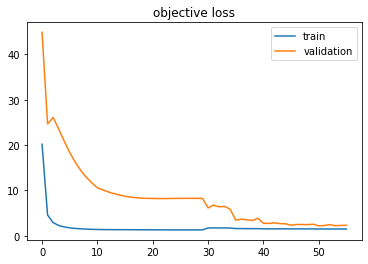

auc =  0.9765387574098376
Loading  1


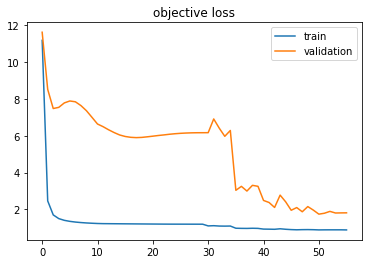

auc =  0.9980753892827061
Loading  2


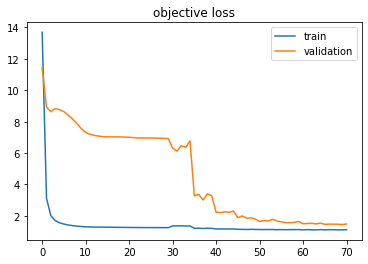

auc =  0.8651858200388634
Loading  3


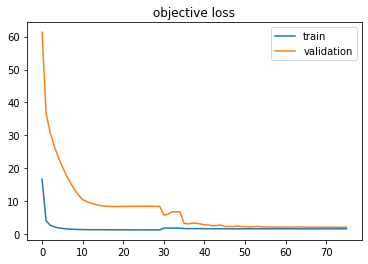

auc =  0.8632548816616924
Loading  4


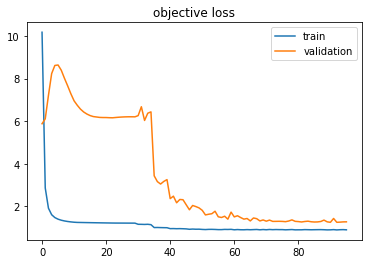

auc =  0.9226675637184559
Loading  5


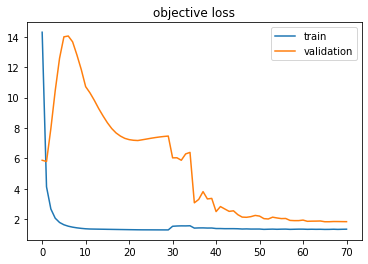

auc =  0.8834709691967442
Loading  6


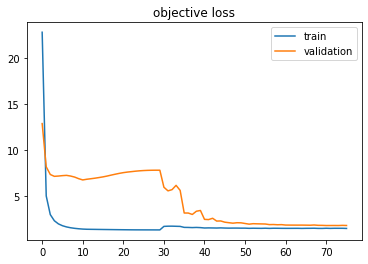

auc =  0.9634253788513727
Loading  7


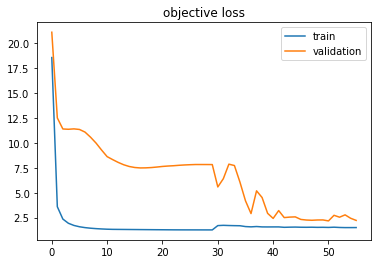

auc =  0.9454858262020537
Loading  8


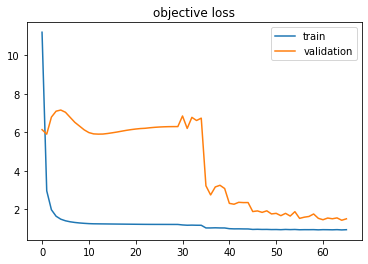

auc =  0.8717837608988135
Loading  9


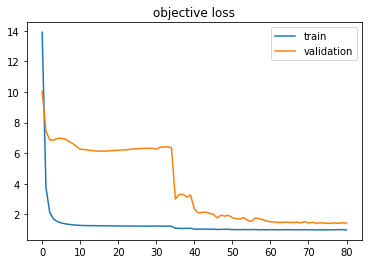

auc =  0.9418493485226223


In [21]:
nu = 0.1
outlier_nu = 0.
smoothing = 5
warm_up_n_epochs = 30
lr_milestone = 12
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone)
    train_SVDD.train( train_dataset, x_vali, warm_up_n_epochs =  warm_up_n_epochs, smoothing = smoothing)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
    test_confusionmatrix_list.append(confusionmatrix)

Loading  0


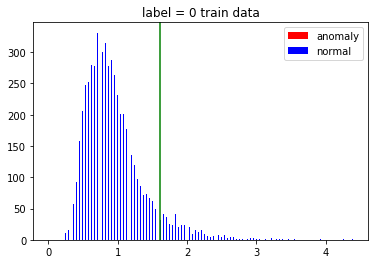

 train label = 0 uncertain_img


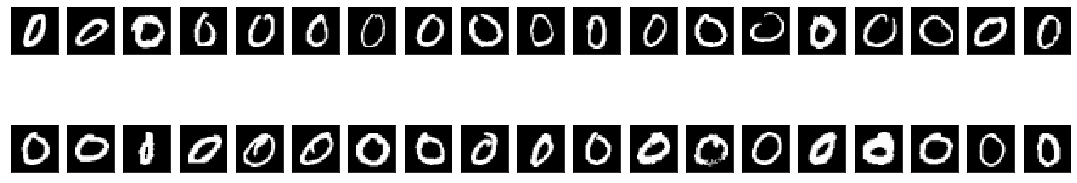

train label = 0 distance oder


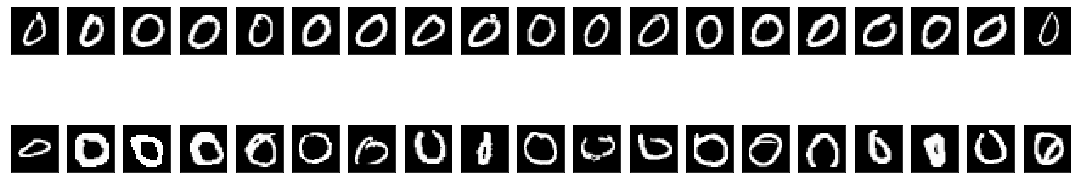

<Figure size 1440x288 with 0 Axes>

AUC: 0.9765387574098376
confusion_matrix:
[[8390  630]
 [  74  906]]


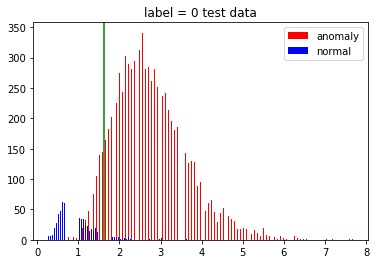

test label = 0 uncertain_img


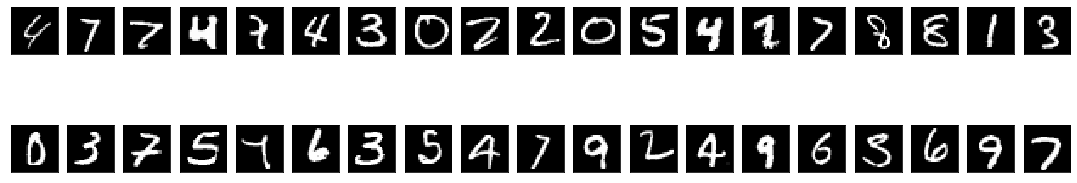

test label = 0 distance oder


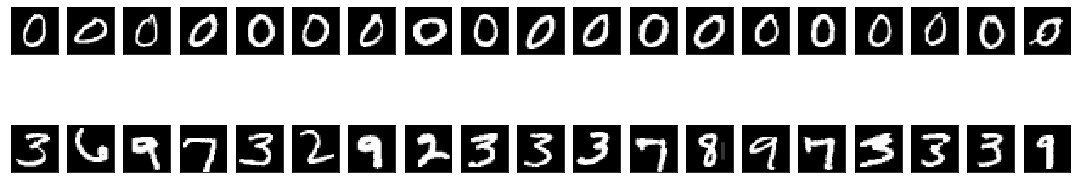

test label = 0 false_img


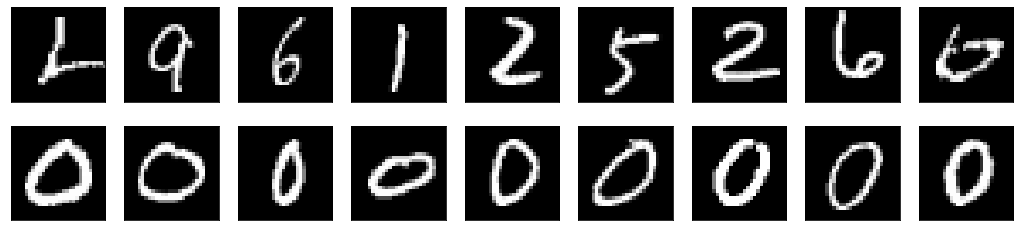

Loading  1


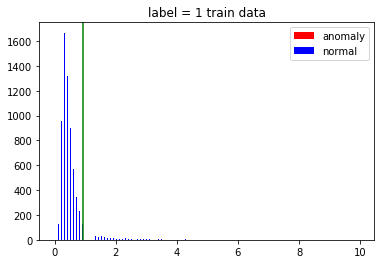

 train label = 1 uncertain_img


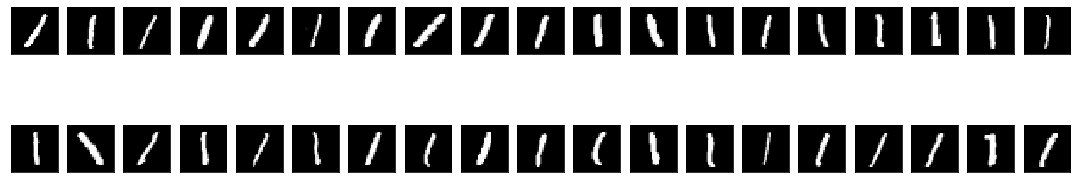

train label = 1 distance oder


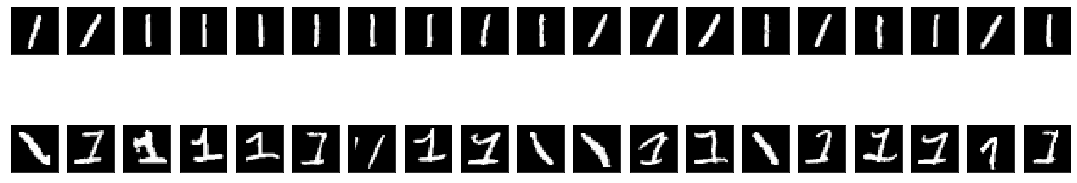

<Figure size 1440x288 with 0 Axes>

AUC: 0.9980753892827061
confusion_matrix:
[[8857    8]
 [  82 1053]]


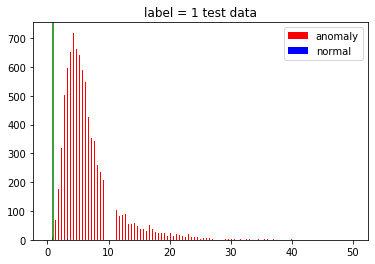

test label = 1 uncertain_img


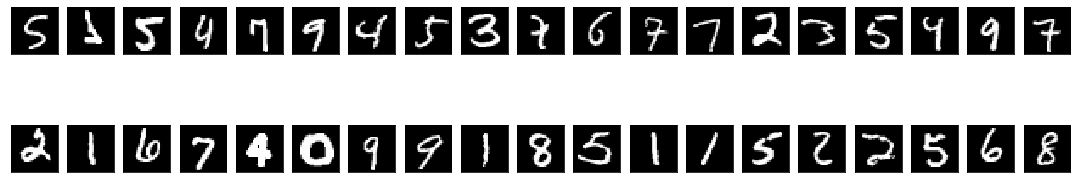

test label = 1 distance oder


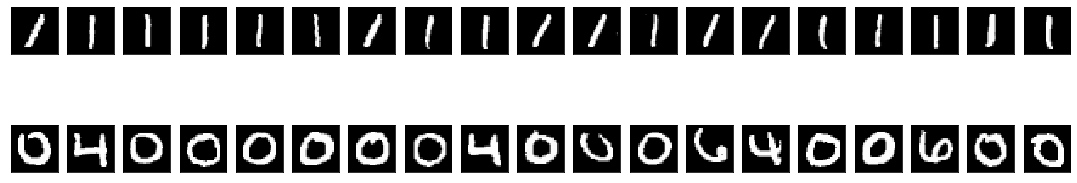

test label = 1 false_img


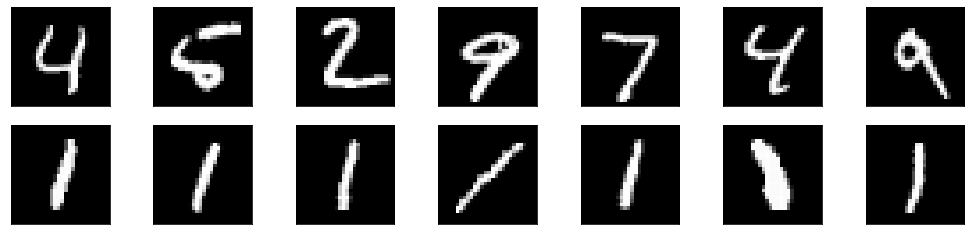

Loading  2


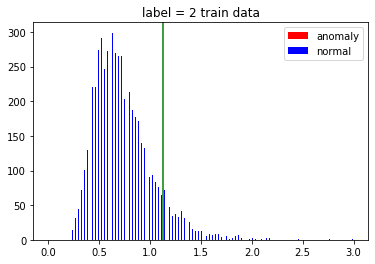

 train label = 2 uncertain_img


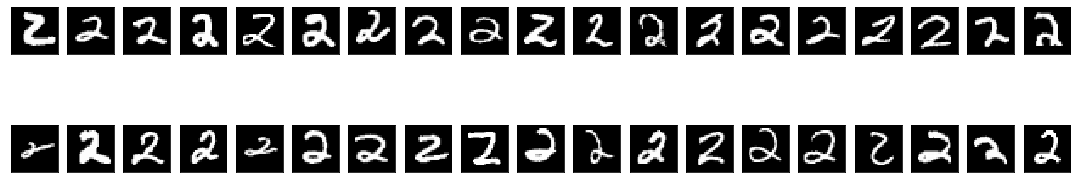

train label = 2 distance oder


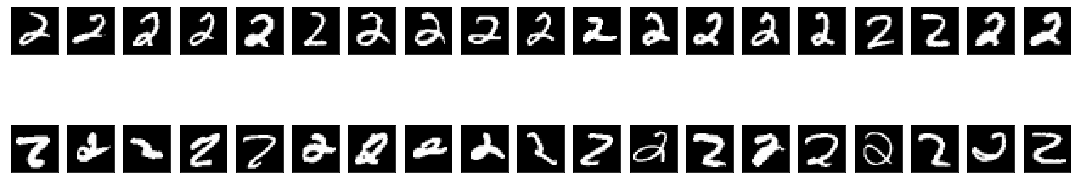

<Figure size 1440x288 with 0 Axes>

AUC: 0.8651858200388634
confusion_matrix:
[[5058 3910]
 [  82  950]]


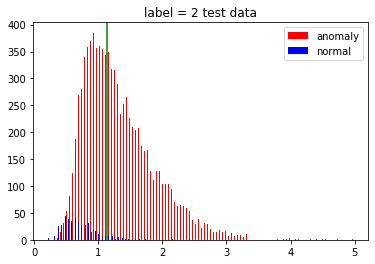

test label = 2 uncertain_img


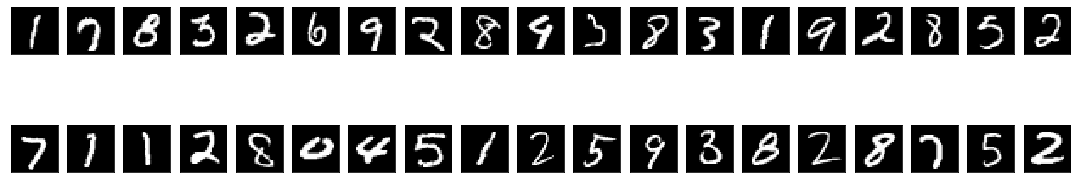

test label = 2 distance oder


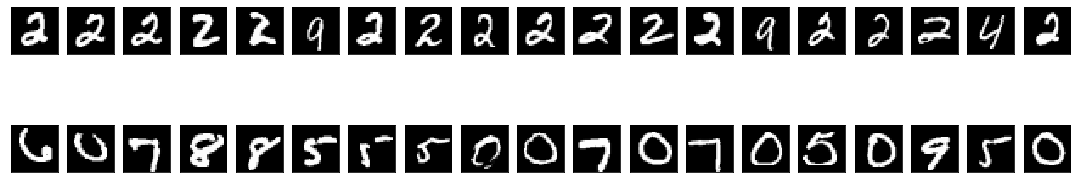

test label = 2 false_img


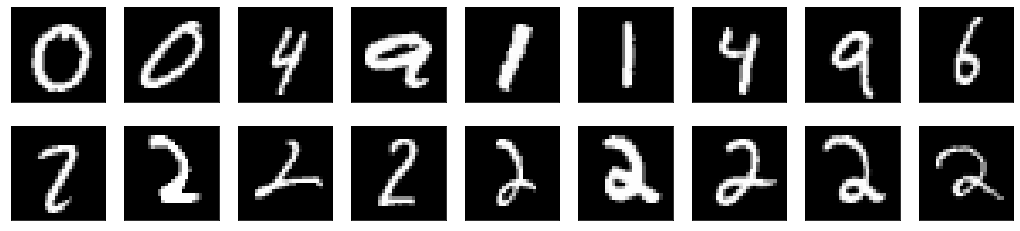

Loading  3


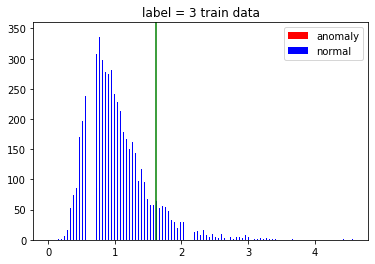

 train label = 3 uncertain_img


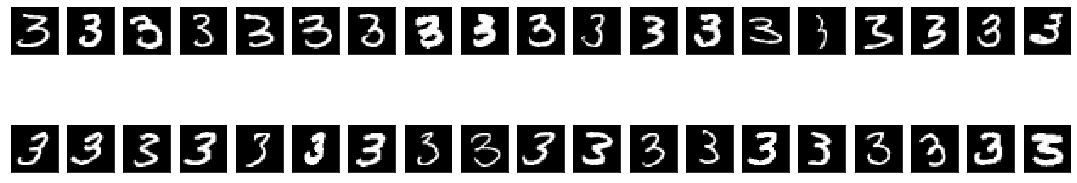

train label = 3 distance oder


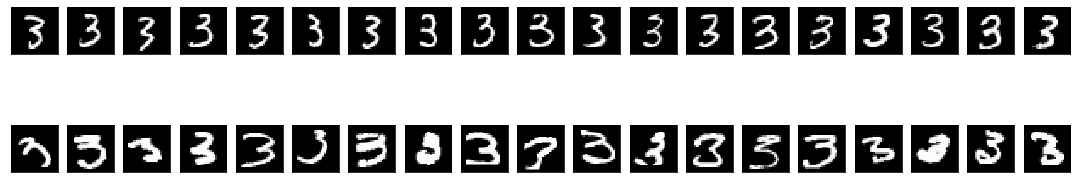

<Figure size 1440x288 with 0 Axes>

AUC: 0.8632548816616924
confusion_matrix:
[[5442 3548]
 [  82  928]]


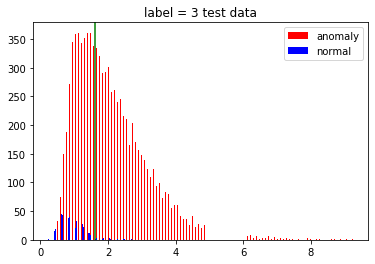

test label = 3 uncertain_img


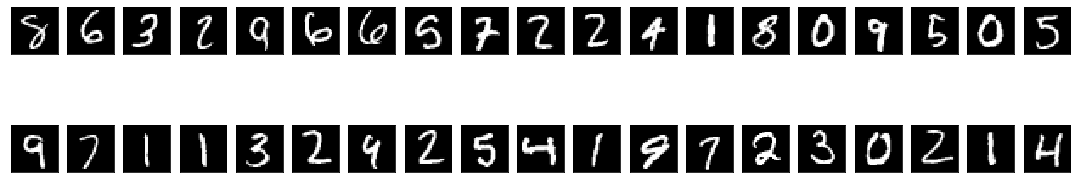

test label = 3 distance oder


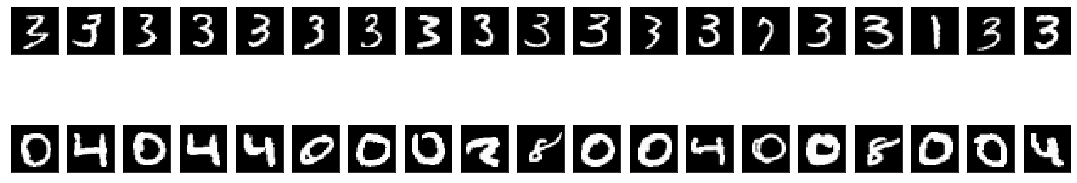

test label = 3 false_img


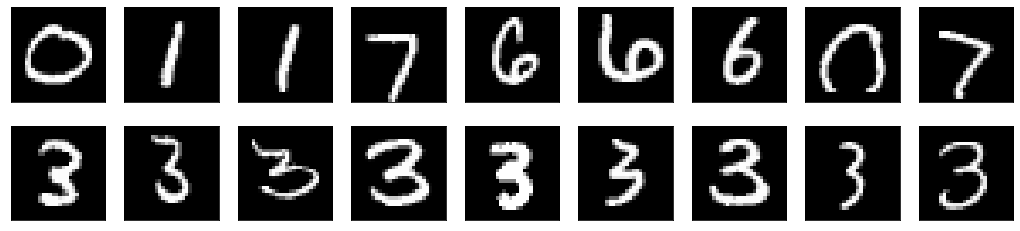

Loading  4


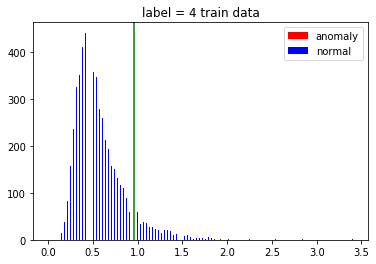

 train label = 4 uncertain_img


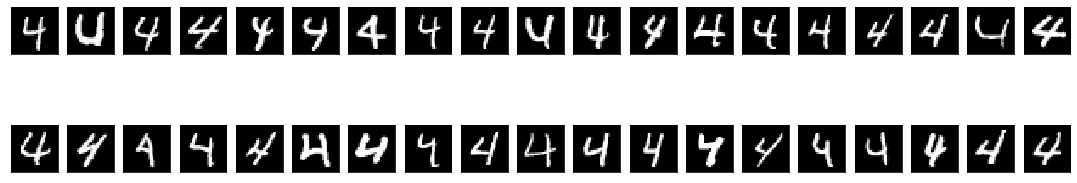

train label = 4 distance oder


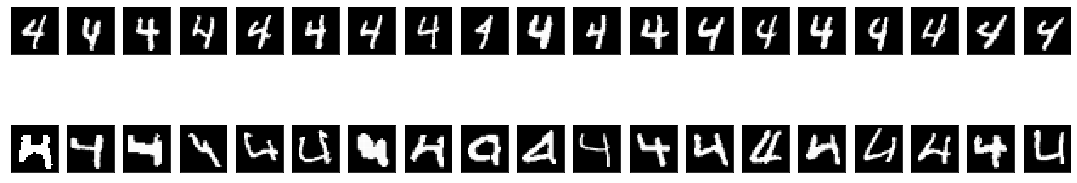

<Figure size 1440x288 with 0 Axes>

AUC: 0.9226675637184559
confusion_matrix:
[[6747 2271]
 [  78  904]]


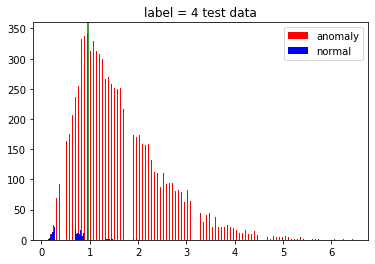

test label = 4 uncertain_img


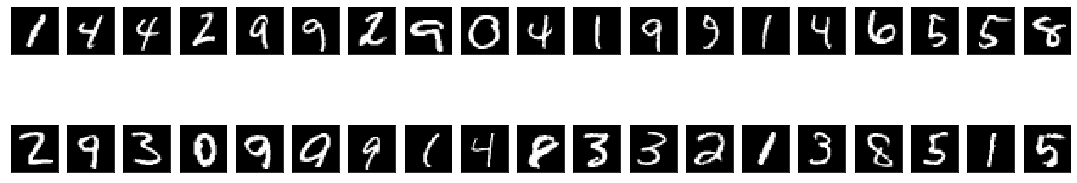

test label = 4 distance oder


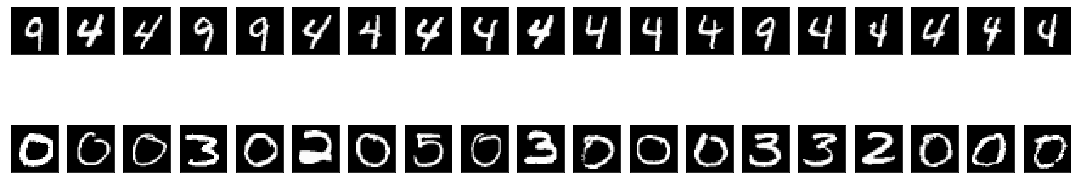

test label = 4 false_img


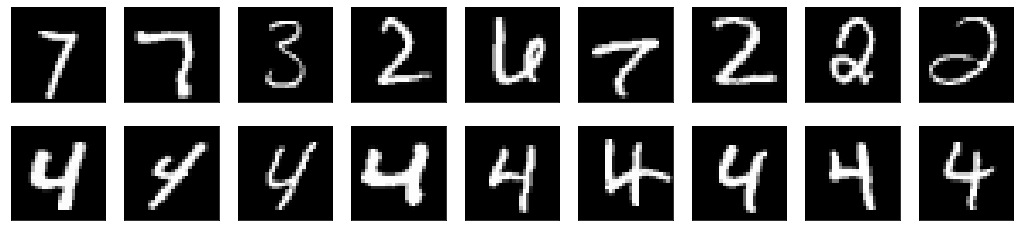

Loading  5


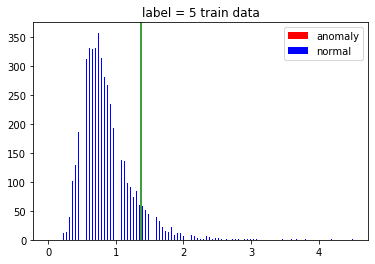

 train label = 5 uncertain_img


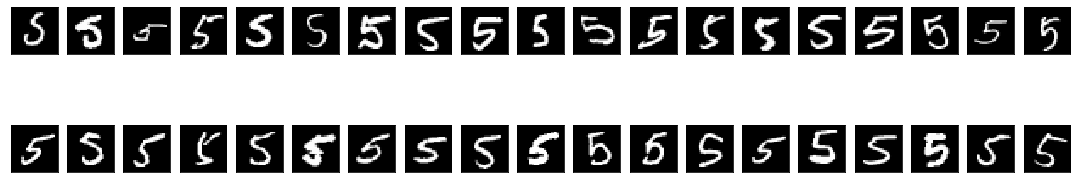

train label = 5 distance oder


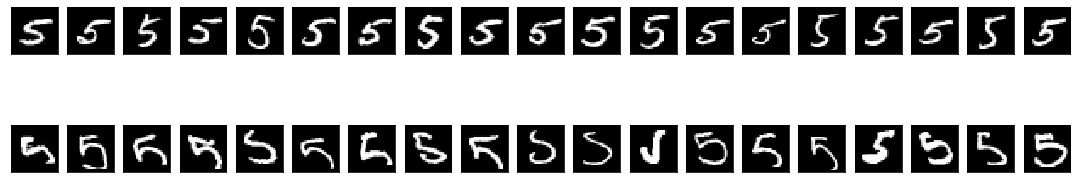

<Figure size 1440x288 with 0 Axes>

AUC: 0.8834709691967442
confusion_matrix:
[[5700 3408]
 [  78  814]]


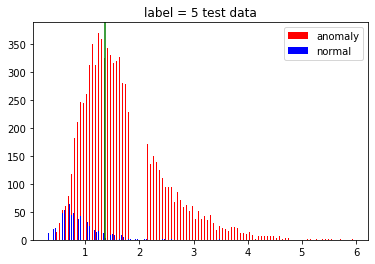

test label = 5 uncertain_img


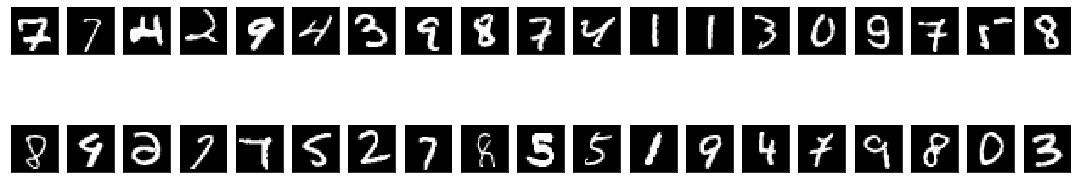

test label = 5 distance oder


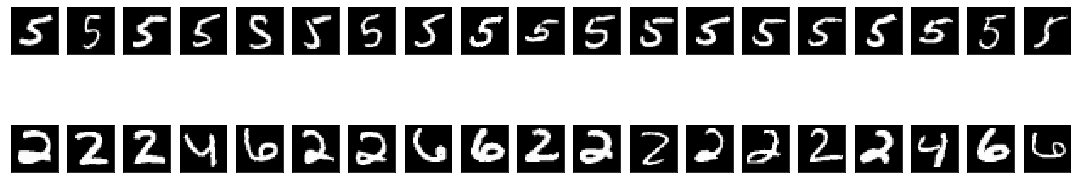

test label = 5 false_img


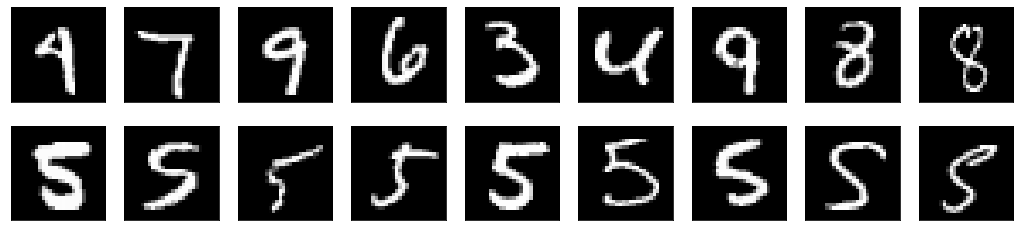

Loading  6


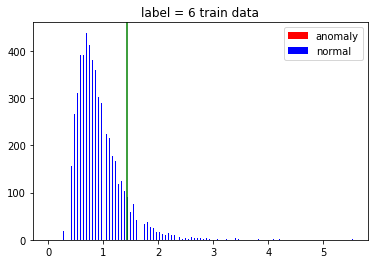

 train label = 6 uncertain_img


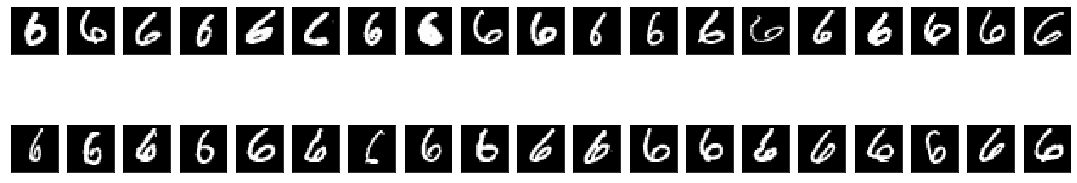

train label = 6 distance oder


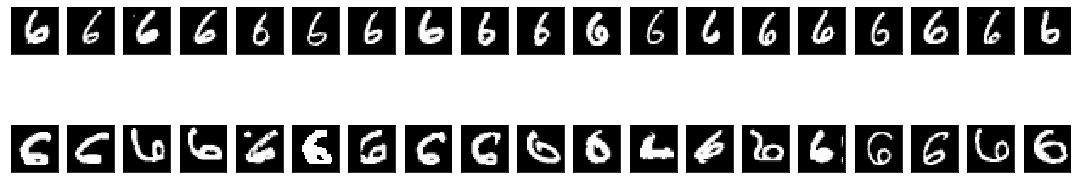

<Figure size 1440x288 with 0 Axes>

AUC: 0.9634253788513727
confusion_matrix:
[[8136  906]
 [ 106  852]]


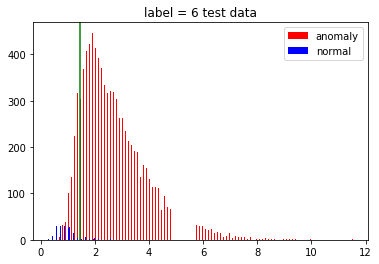

test label = 6 uncertain_img


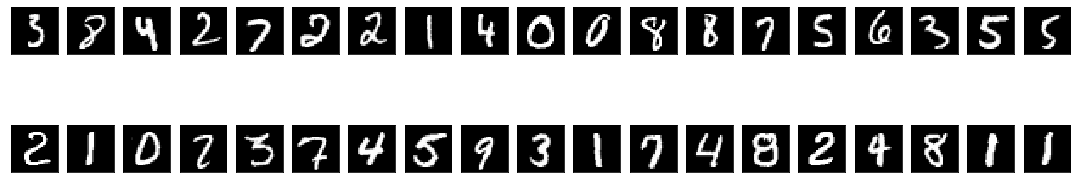

test label = 6 distance oder


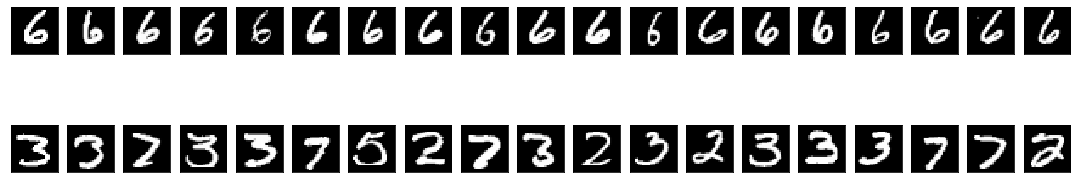

test label = 6 false_img


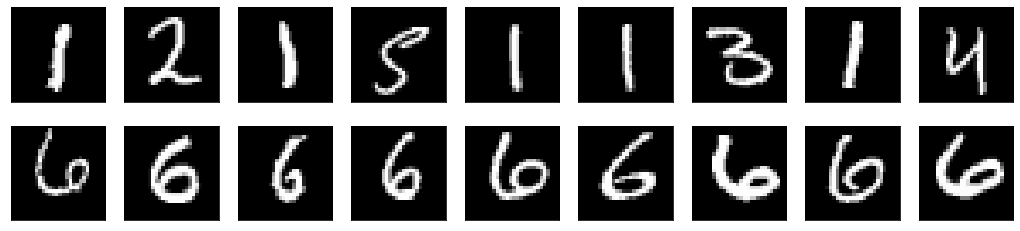

Loading  7


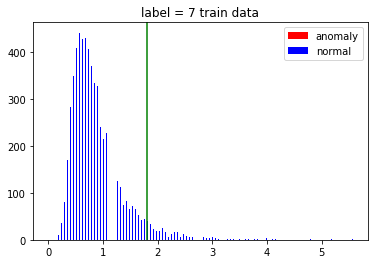

 train label = 7 uncertain_img


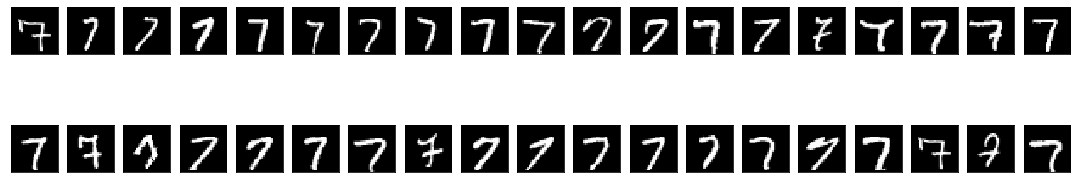

train label = 7 distance oder


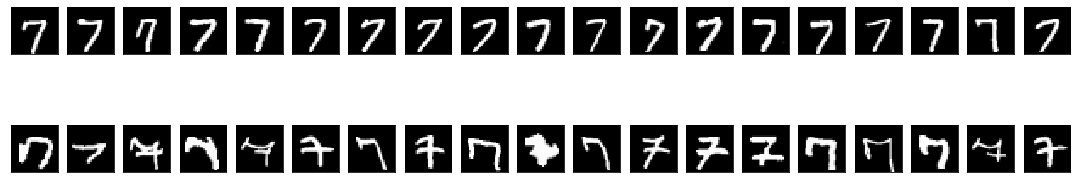

<Figure size 1440x288 with 0 Axes>

AUC: 0.9454858262020537
confusion_matrix:
[[6563 2409]
 [  53  975]]


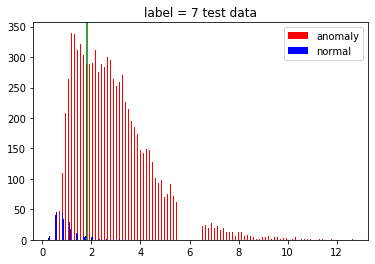

test label = 7 uncertain_img


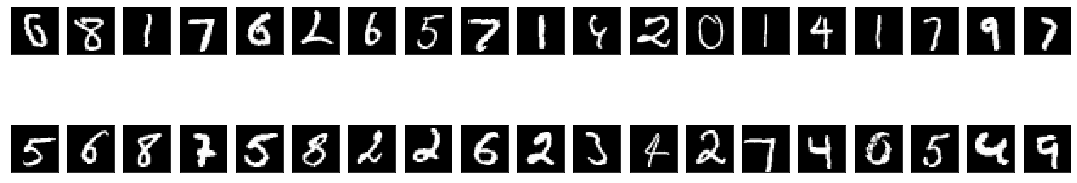

test label = 7 distance oder


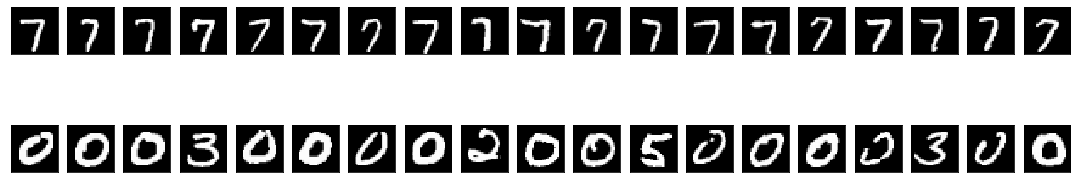

test label = 7 false_img


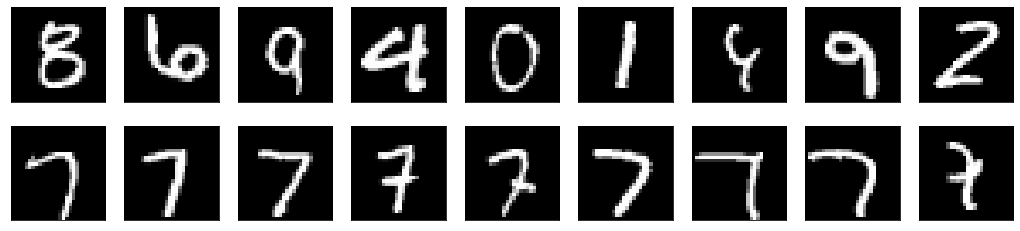

Loading  8


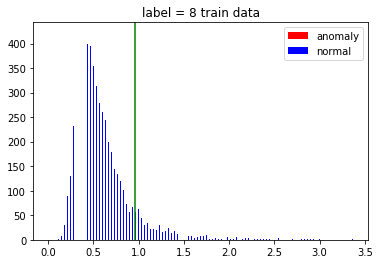

 train label = 8 uncertain_img


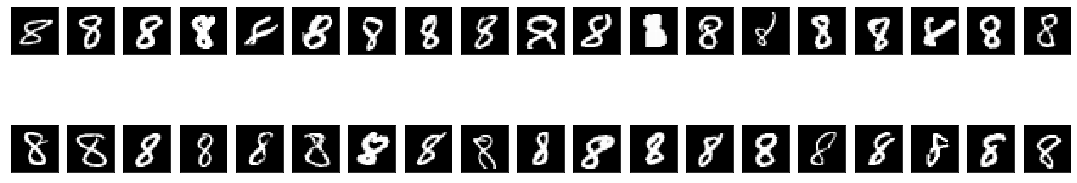

train label = 8 distance oder


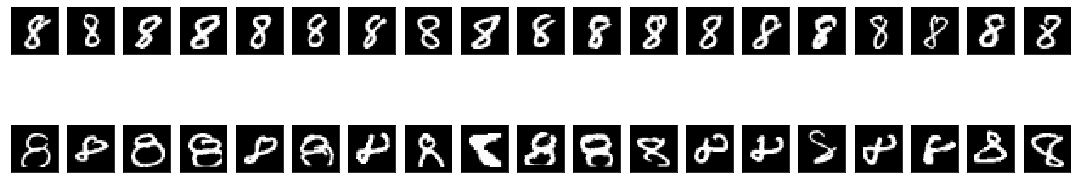

<Figure size 1440x288 with 0 Axes>

AUC: 0.8717837608988135
confusion_matrix:
[[5031 3995]
 [  79  895]]


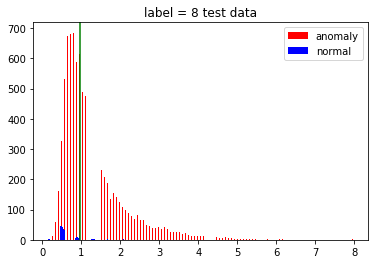

test label = 8 uncertain_img


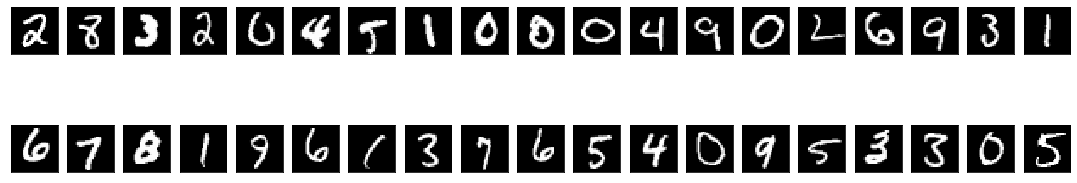

test label = 8 distance oder


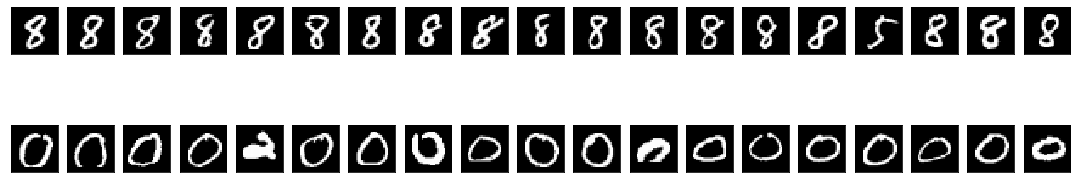

test label = 8 false_img


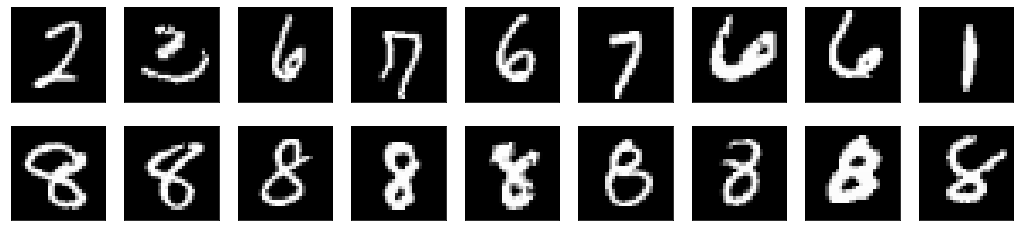

Loading  9


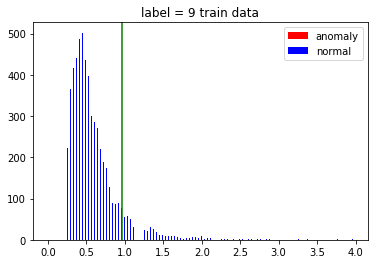

 train label = 9 uncertain_img


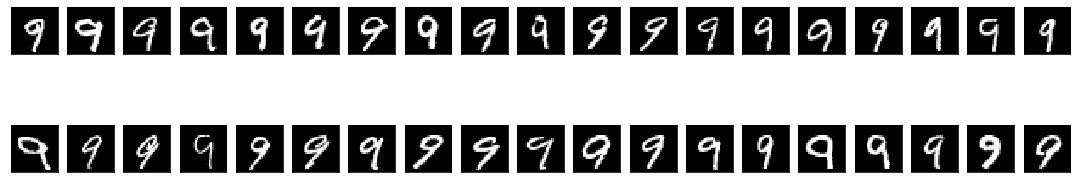

train label = 9 distance oder


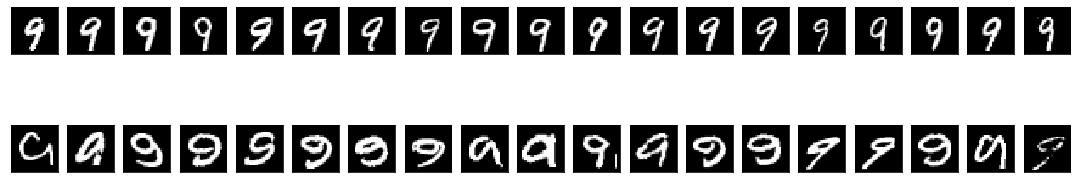

<Figure size 1440x288 with 0 Axes>

AUC: 0.9418493485226223
confusion_matrix:
[[7476 1515]
 [  96  913]]


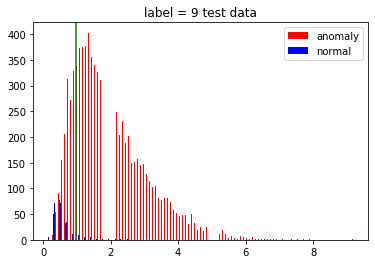

test label = 9 uncertain_img


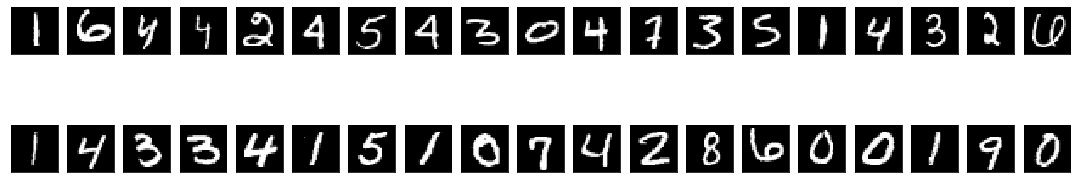

test label = 9 distance oder


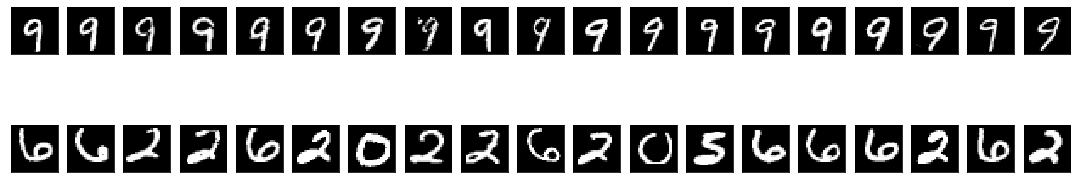

test label = 9 false_img


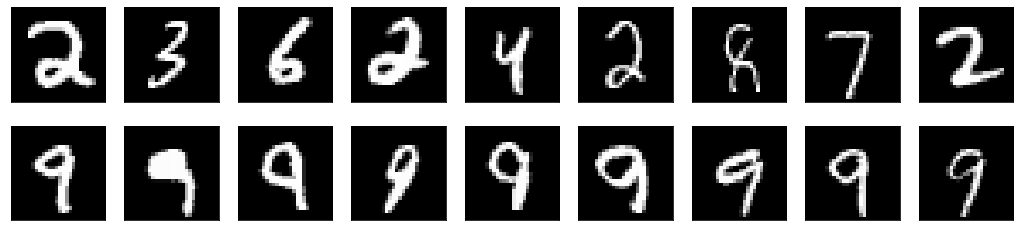

In [24]:
nu = 0.1
outlier_nu = 0.
smoothing = 5
warm_up_n_epochs = 30
lr_milestone = 12
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone)
    train_SVDD.train_result( x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)


## 已知 outlier 比例

In [19]:
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []


Loading  0


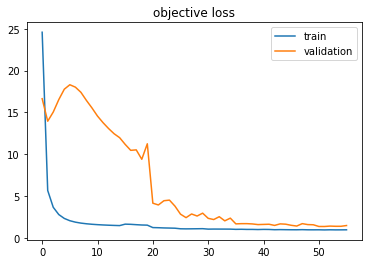

auc =  0.9577575908412147
Loading  1


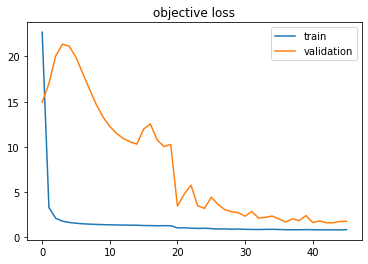

auc =  0.9910730462567489
Loading  2


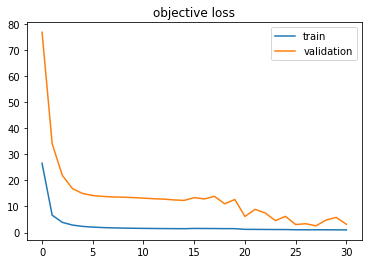

auc =  0.815608111787648
Loading  3


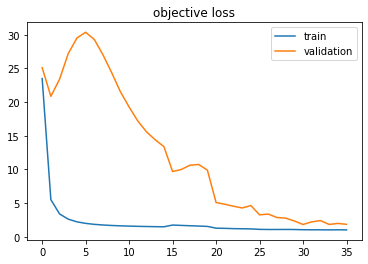

auc =  0.8617408782035045
Loading  4


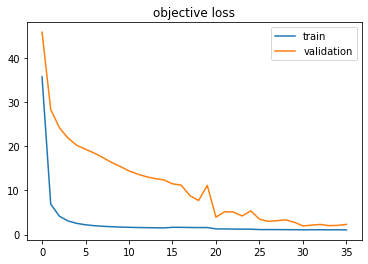

auc =  0.8862237055646571
Loading  5


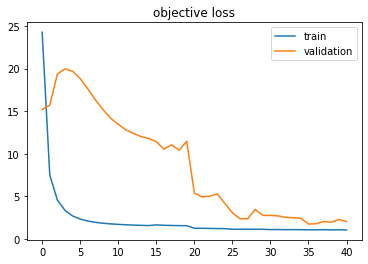

auc =  0.8887602629925695
Loading  6


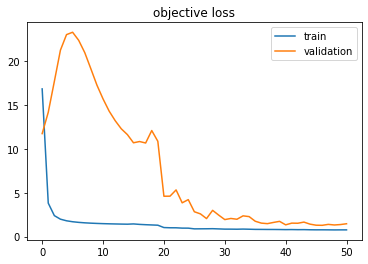

auc =  0.9420949163703229
Loading  7


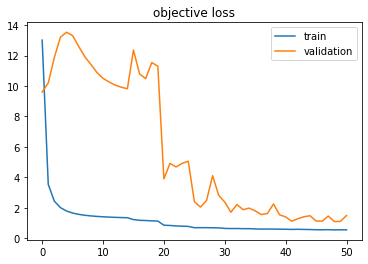

auc =  0.8777316935871392
Loading  8


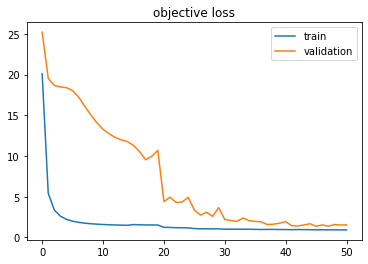

auc =  0.8251385684340605
Loading  9


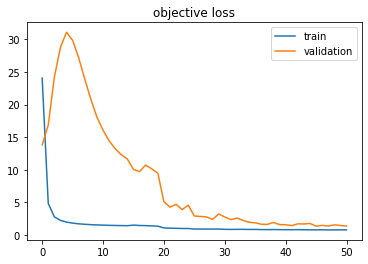

auc =  0.9272711760323257


array([[ 0.        ,  0.95591852,  0.95775759, 27.62993121],
       [ 1.        ,  0.98757952,  0.99107305, 23.50449419],
       [ 2.        ,  0.82496895,  0.81560811, 13.21599889],
       [ 3.        ,  0.85245133,  0.86174088, 16.71809387],
       [ 4.        ,  0.89508894,  0.88622371, 15.62650132],
       [ 5.        ,  0.86701368,  0.88876026, 17.5350275 ],
       [ 6.        ,  0.94877621,  0.94209492, 25.05524707],
       [ 7.        ,  0.87750243,  0.87773169, 25.90584421],
       [ 8.        ,  0.78528024,  0.82513857, 24.47569013],
       [ 9.        ,  0.91243131,  0.92727118, 25.19458342]])

In [40]:
smoothing =5
lr_change = 0.1
warm_up_n_epochs = 15
lr_milestone = 25
nu = 0.05
outlier_nu = 0.05
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(0, train_dataset)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_SVDD.train( train_dataset, x_vali, warm_up_n_epochs =  warm_up_n_epochs, smoothing = smoothing)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    train_confusionmatrix_list.append(train_confusionmatrix)
    test_confusionmatrix_list.append(confusionmatrix)
result

Loading  0
AUC: 0.9657302499190056
confusion_matrix:
[[ 191  105]
 [ 123 5800]]


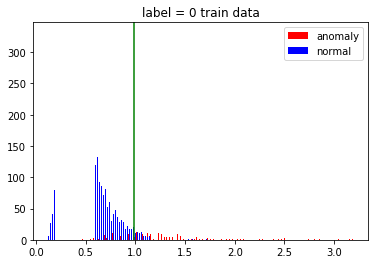

 train label = 0 uncertain_img


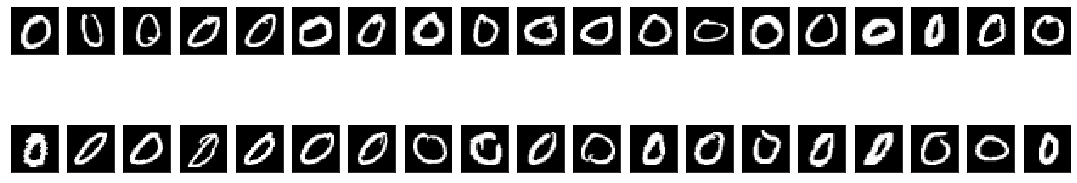

train label = 0 distance oder


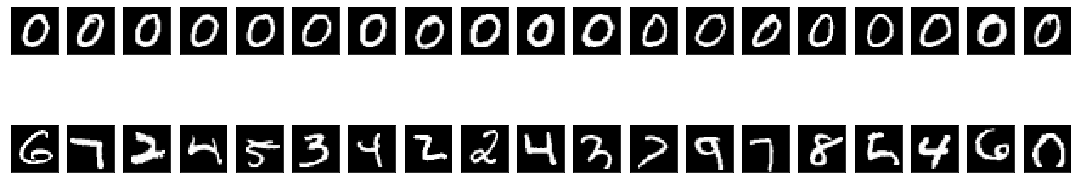

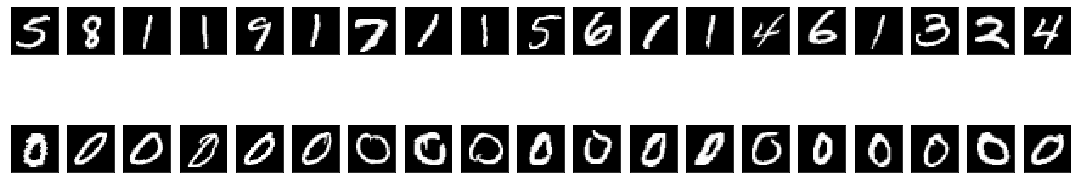

AUC: 0.9577575908412147
confusion_matrix:
[[5600 3420]
 [  25  955]]


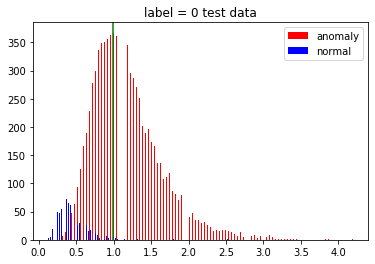

test label = 0 uncertain_img


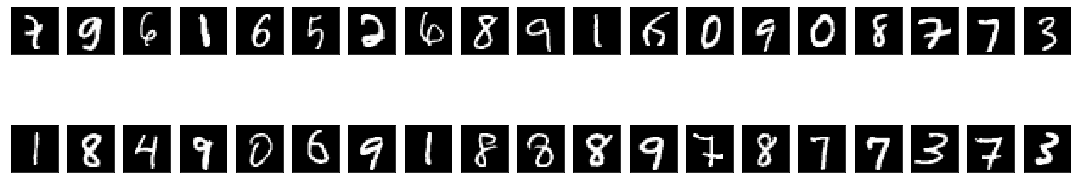

test label = 0 distance oder


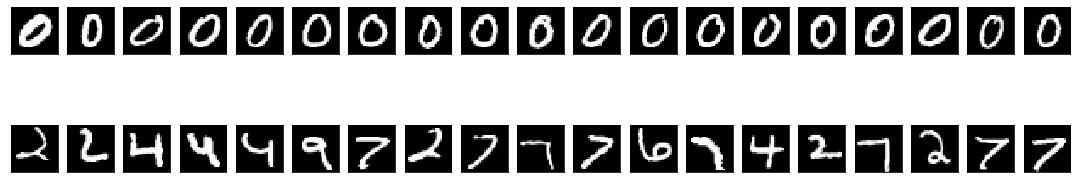

test label = 0 false_img


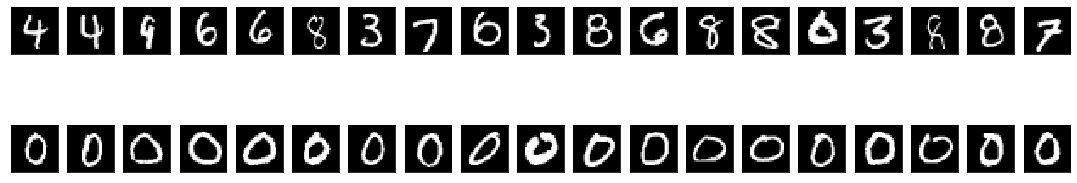

Loading  1
AUC: 0.9885724547039816
confusion_matrix:
[[ 238   99]
 [  84 6658]]


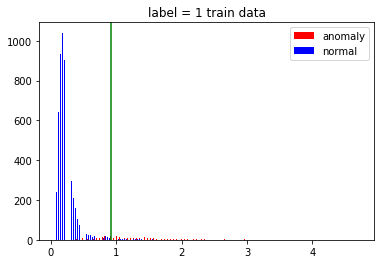

 train label = 1 uncertain_img


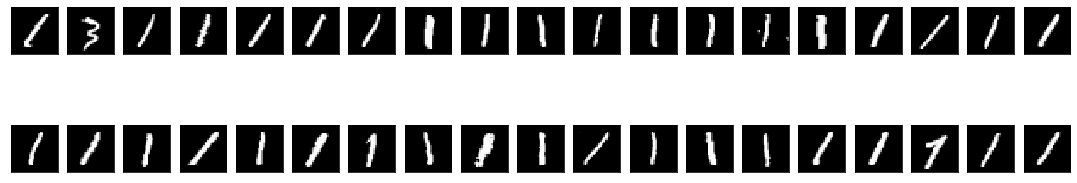

train label = 1 distance oder


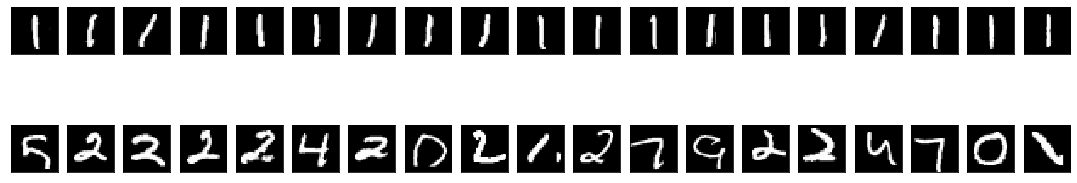

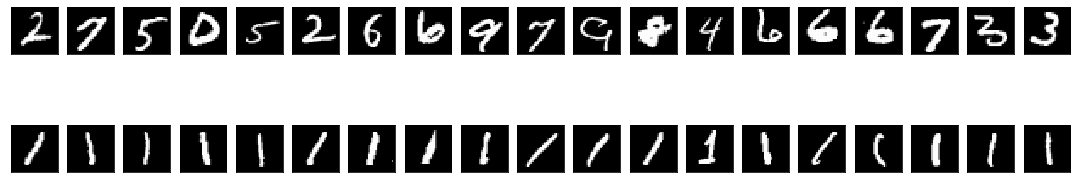

AUC: 0.9910730462567489
confusion_matrix:
[[6263 2602]
 [   9 1126]]


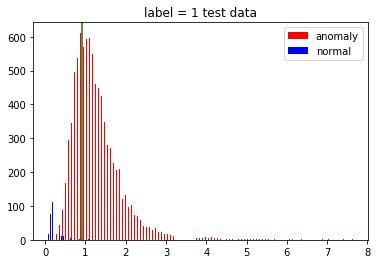

test label = 1 uncertain_img


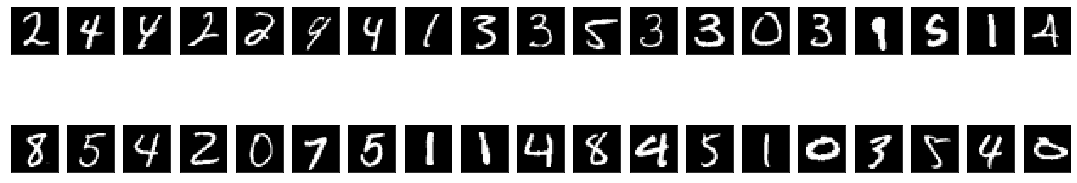

test label = 1 distance oder


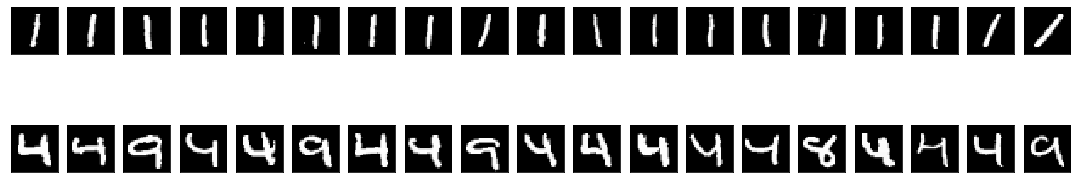

test label = 1 false_img


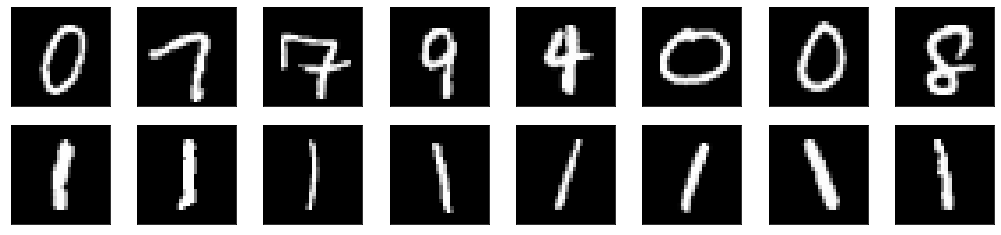

Loading  2
AUC: 0.8180425153402663
confusion_matrix:
[[ 104  193]
 [ 326 5632]]


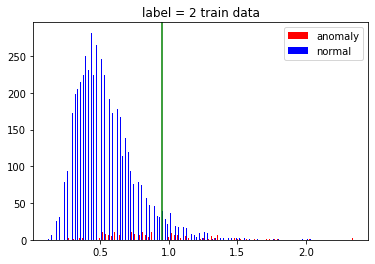

 train label = 2 uncertain_img


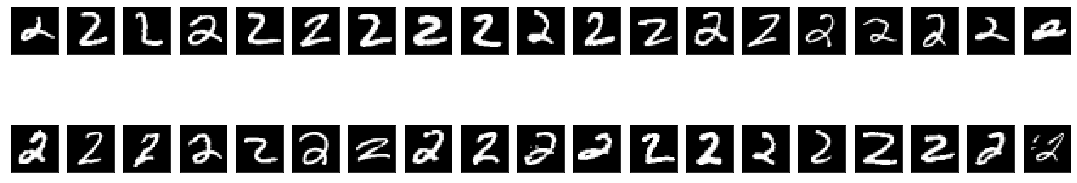

train label = 2 distance oder


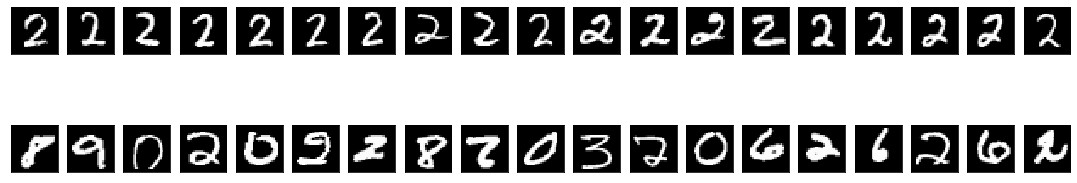

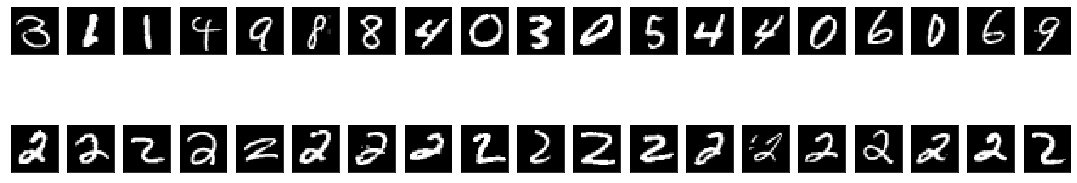

AUC: 0.815608111787648
confusion_matrix:
[[3196 5772]
 [  61  971]]


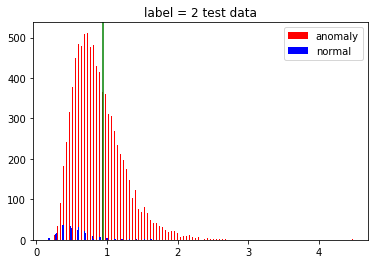

test label = 2 uncertain_img


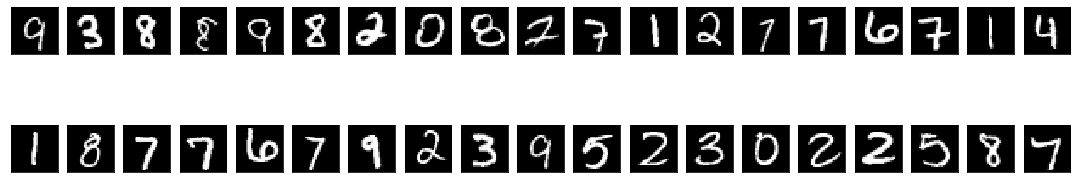

test label = 2 distance oder


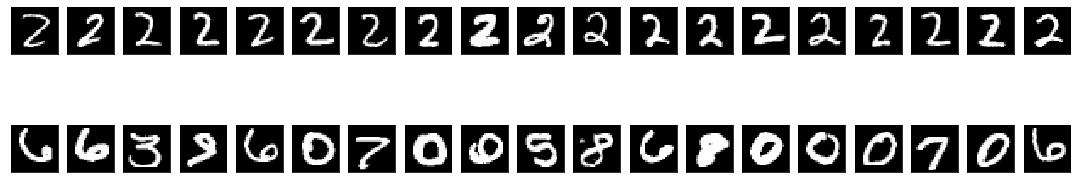

test label = 2 false_img


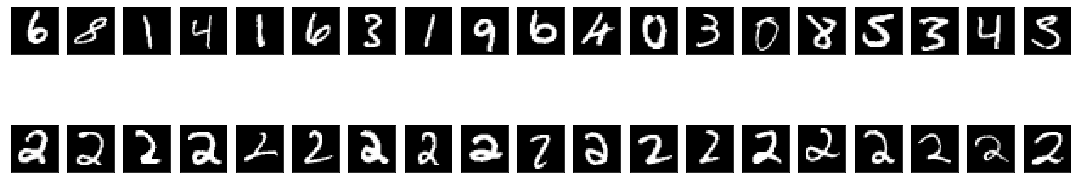

Loading  3
AUC: 0.8418356088153741
confusion_matrix:
[[  66  240]
 [  83 6048]]


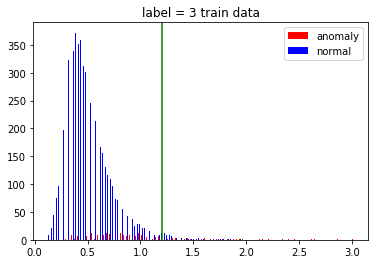

 train label = 3 uncertain_img


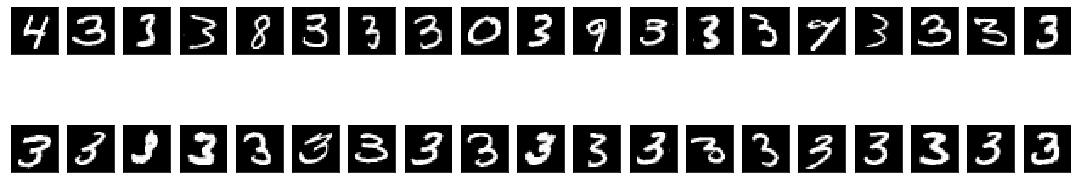

train label = 3 distance oder


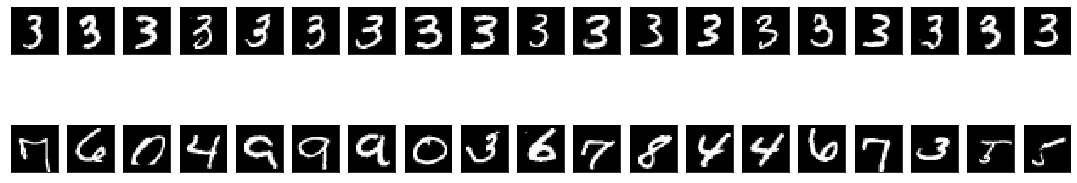

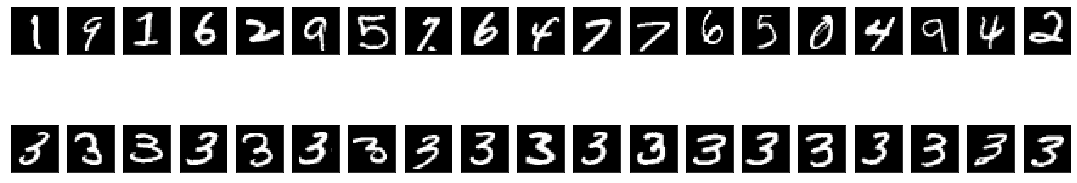

AUC: 0.8617408782035045
confusion_matrix:
[[2259 6731]
 [  17  993]]


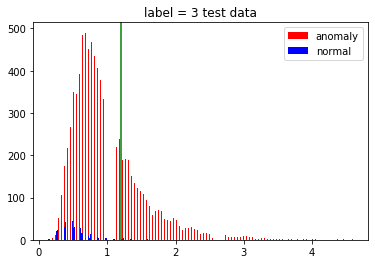

test label = 3 uncertain_img


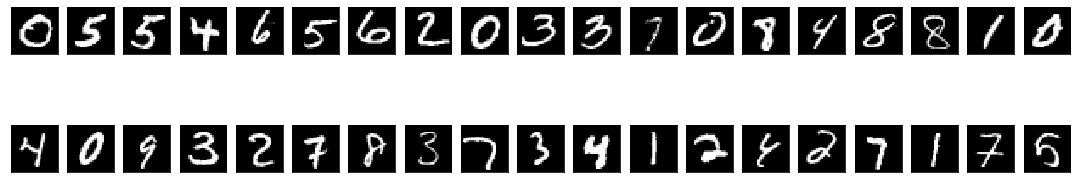

test label = 3 distance oder


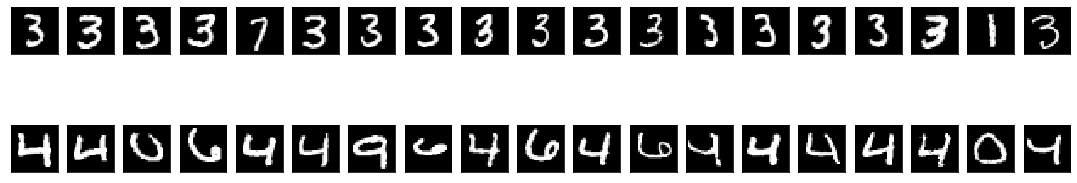

test label = 3 false_img


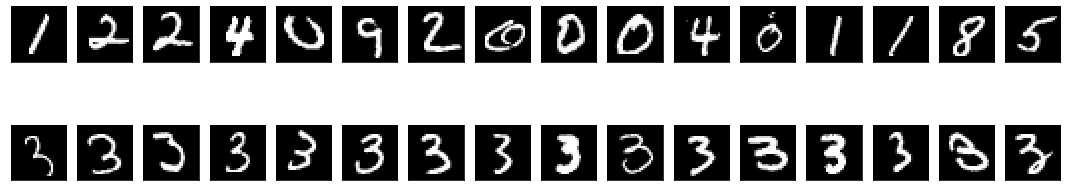

Loading  4
AUC: 0.8854398709393012
confusion_matrix:
[[  82  210]
 [  67 5775]]


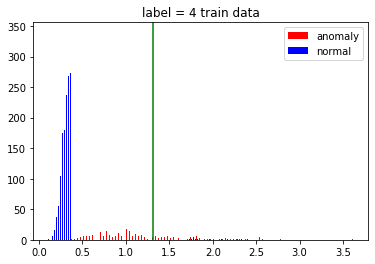

 train label = 4 uncertain_img


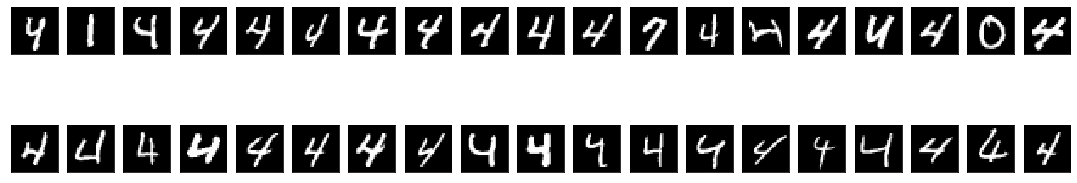

train label = 4 distance oder


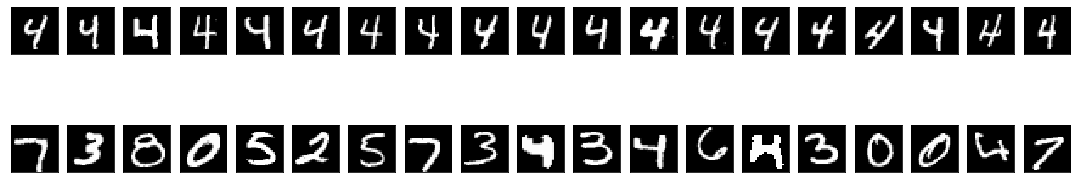

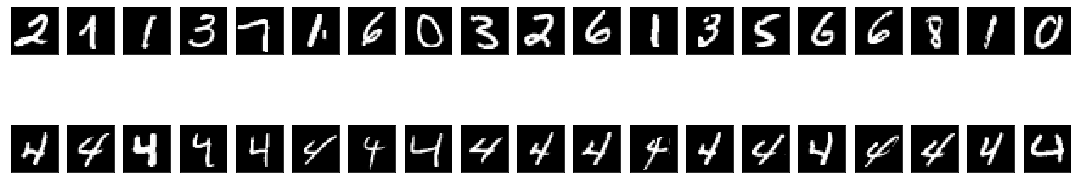

AUC: 0.8862237055646571
confusion_matrix:
[[2609 6409]
 [  11  971]]


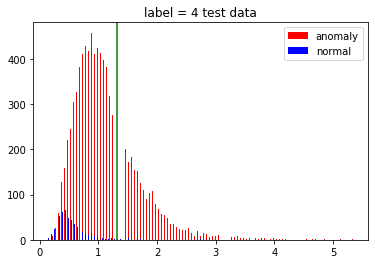

test label = 4 uncertain_img


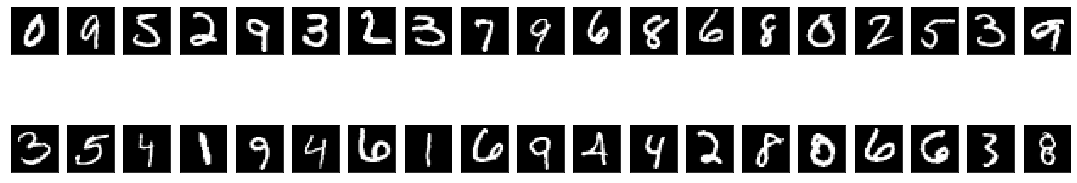

test label = 4 distance oder


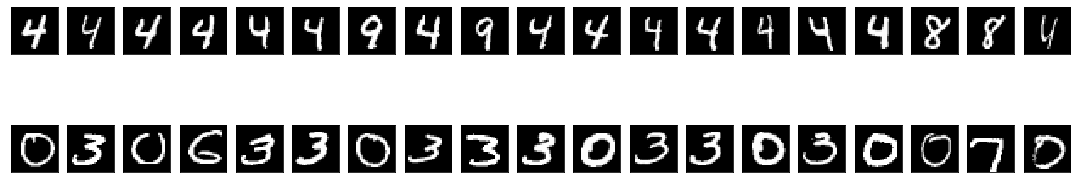

test label = 4 false_img


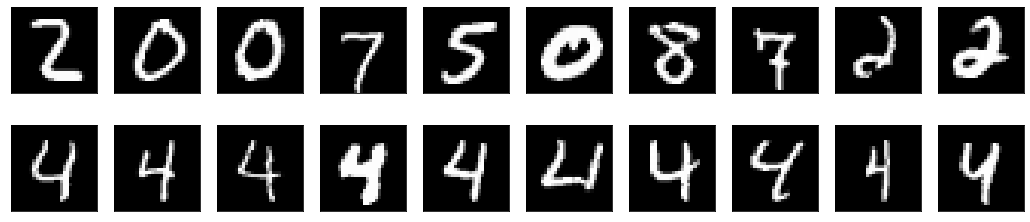

Loading  5
AUC: 0.8942169001103404
confusion_matrix:
[[  80  191]
 [  88 5333]]


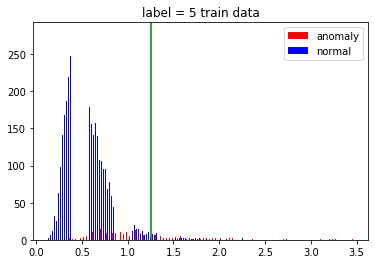

 train label = 5 uncertain_img


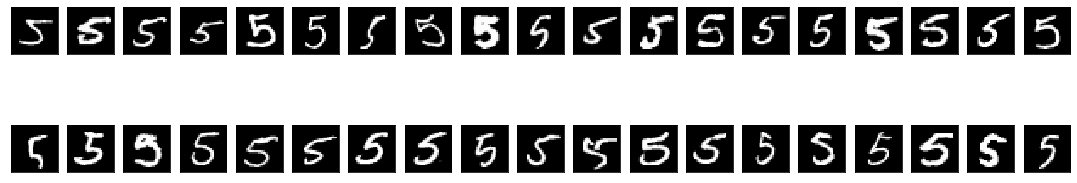

train label = 5 distance oder


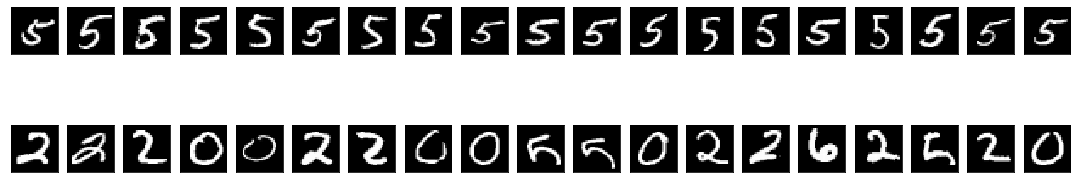

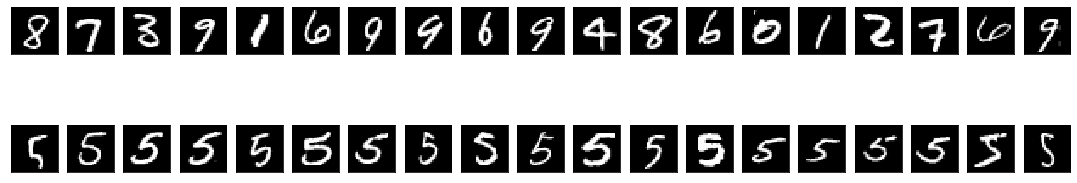

AUC: 0.8887602629925695
confusion_matrix:
[[2512 6596]
 [  13  879]]


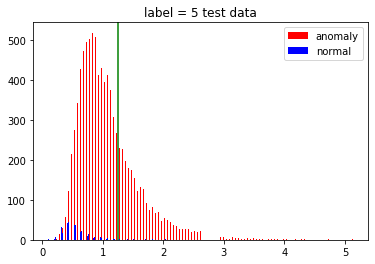

test label = 5 uncertain_img


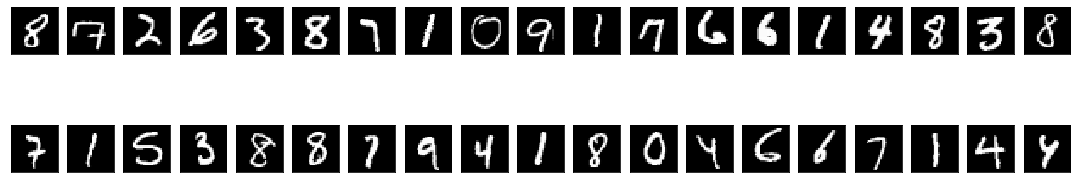

test label = 5 distance oder


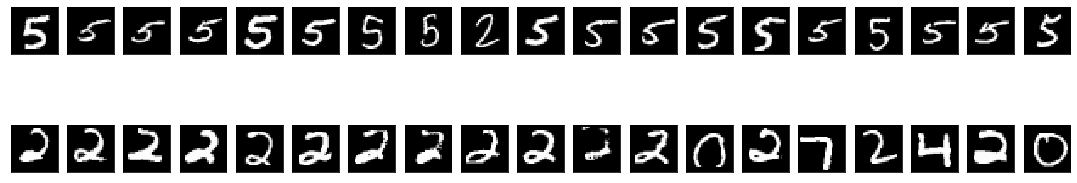

test label = 5 false_img


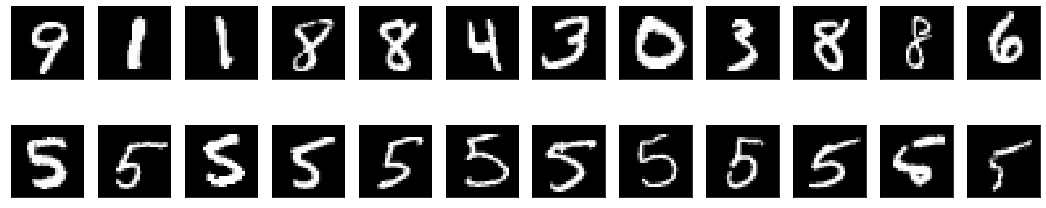

Loading  6
AUC: 0.9563239986023679
confusion_matrix:
[[ 163  132]
 [ 111 5807]]


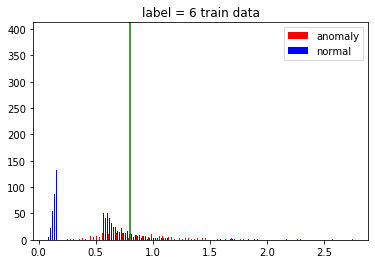

 train label = 6 uncertain_img


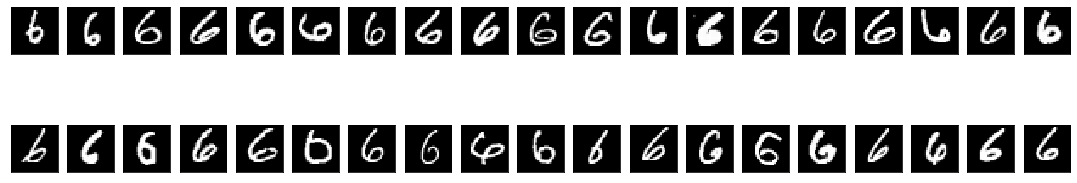

train label = 6 distance oder


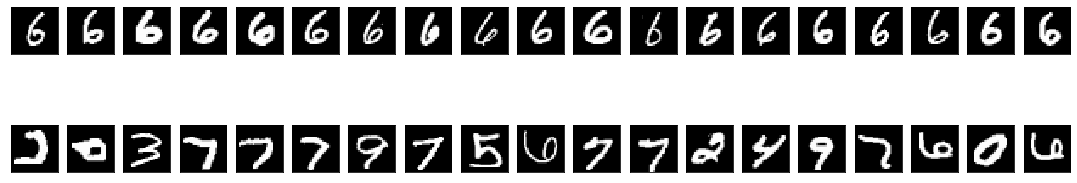

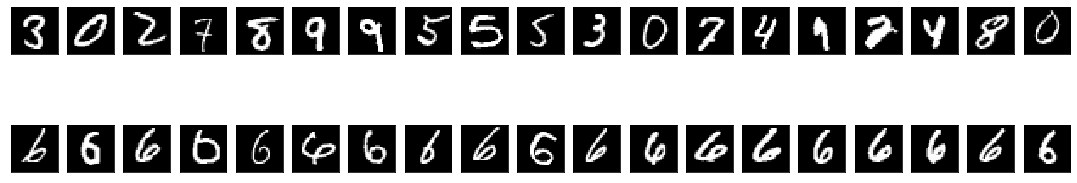

AUC: 0.9420949163703229
confusion_matrix:
[[4630 4412]
 [  16  942]]


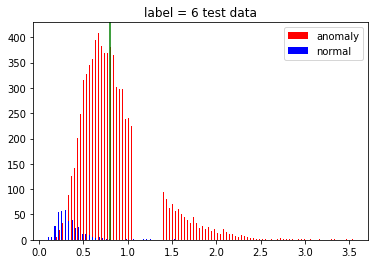

test label = 6 uncertain_img


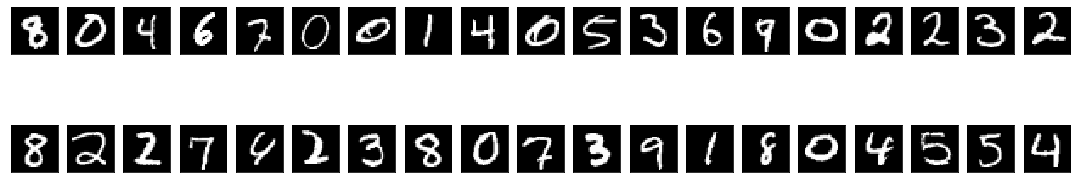

test label = 6 distance oder


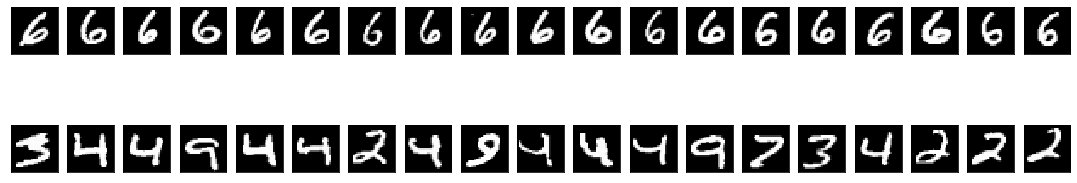

test label = 6 false_img


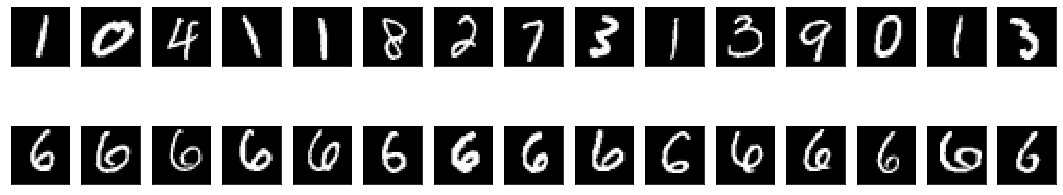

Loading  7
AUC: 0.8727246302165538
confusion_matrix:
[[ 111  202]
 [ 197 6068]]


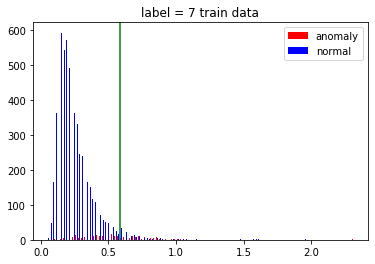

 train label = 7 uncertain_img


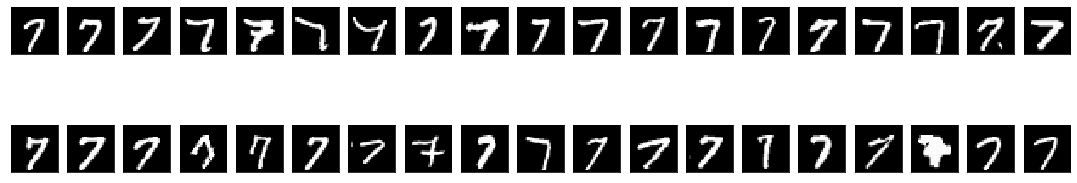

train label = 7 distance oder


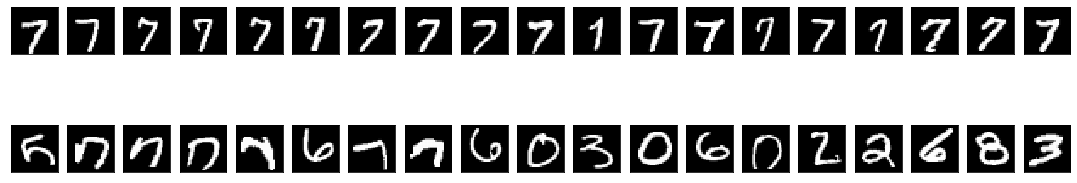

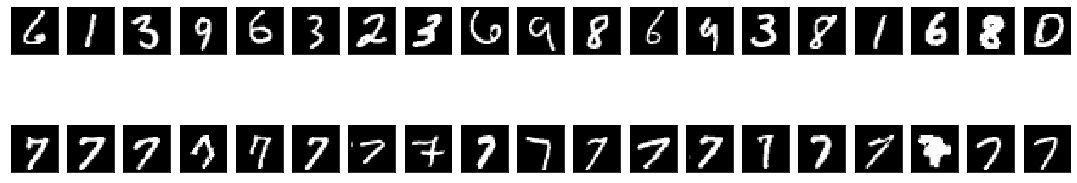

AUC: 0.8777316935871392
confusion_matrix:
[[3058 5914]
 [  27 1001]]


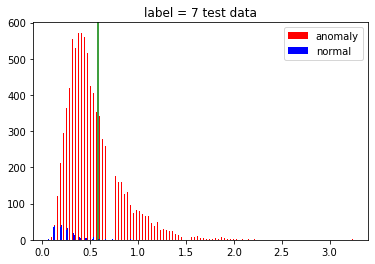

test label = 7 uncertain_img


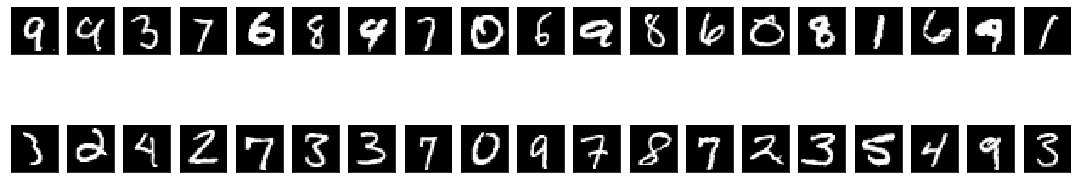

test label = 7 distance oder


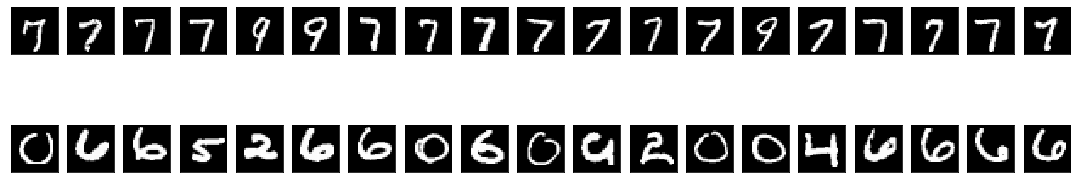

test label = 7 false_img


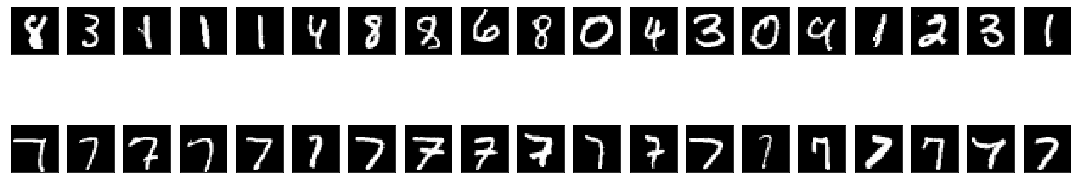

Loading  8
AUC: 0.8051784848860867
confusion_matrix:
[[  98  194]
 [ 176 5675]]


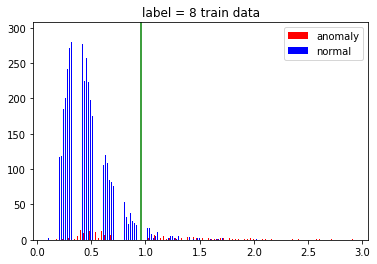

 train label = 8 uncertain_img


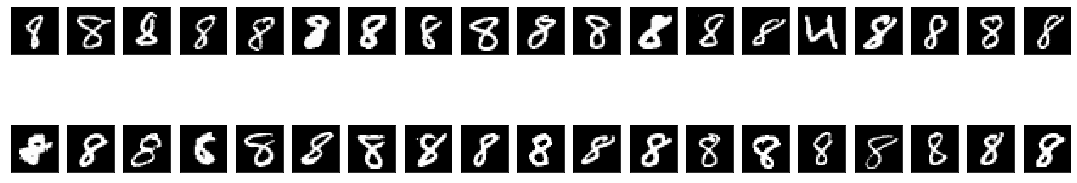

train label = 8 distance oder


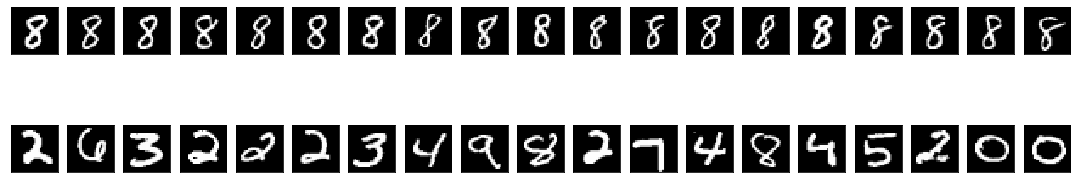

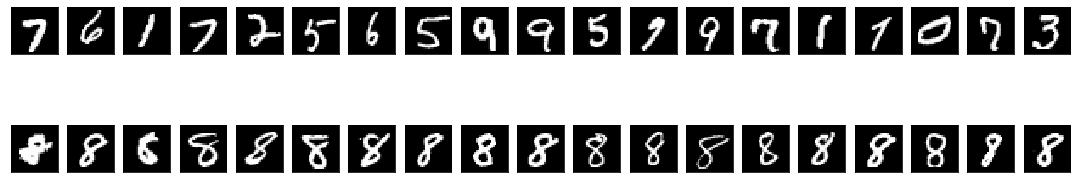

AUC: 0.8251385684340605
confusion_matrix:
[[2948 6078]
 [  21  953]]


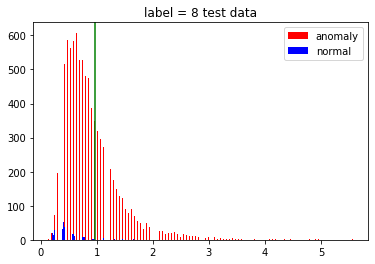

test label = 8 uncertain_img


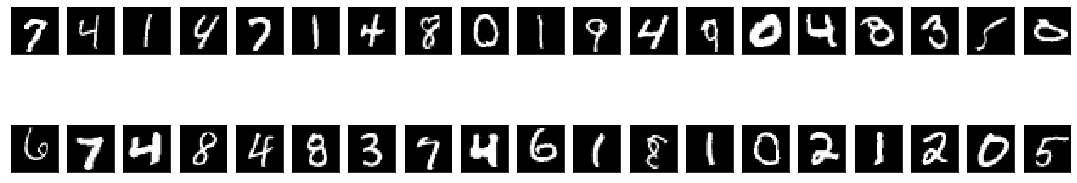

test label = 8 distance oder


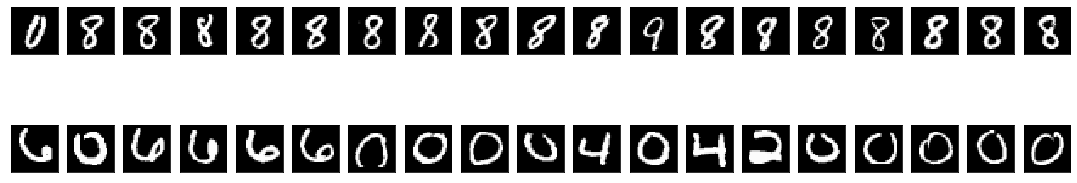

test label = 8 false_img


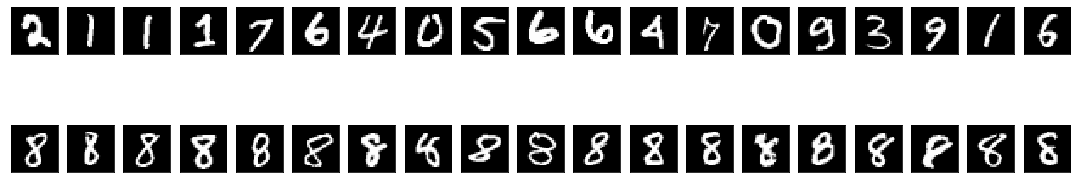

Loading  9
AUC: 0.9323078943183163
confusion_matrix:
[[ 142  155]
 [ 104 5845]]


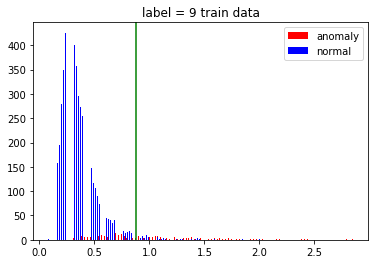

 train label = 9 uncertain_img


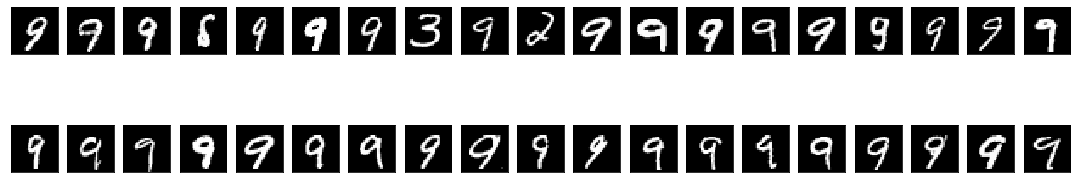

train label = 9 distance oder


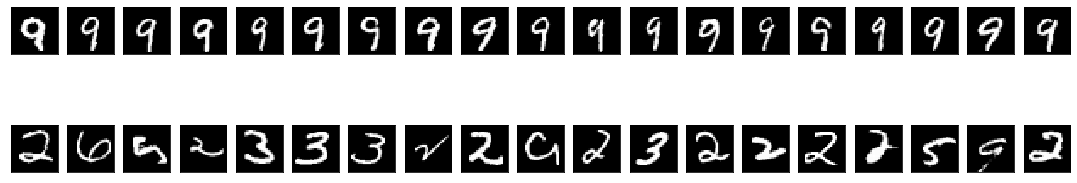

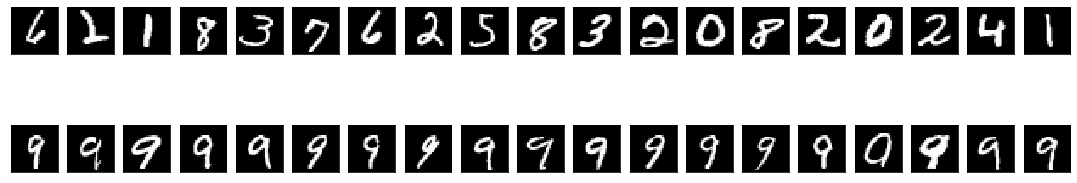

AUC: 0.9272711760323257
confusion_matrix:
[[3993 4998]
 [  12  997]]


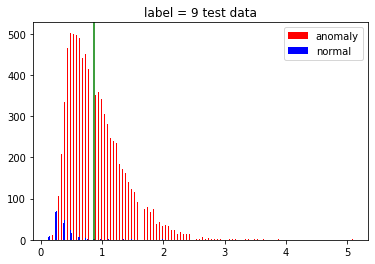

test label = 9 uncertain_img


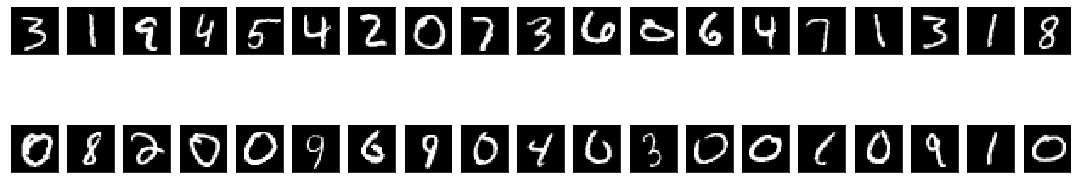

test label = 9 distance oder


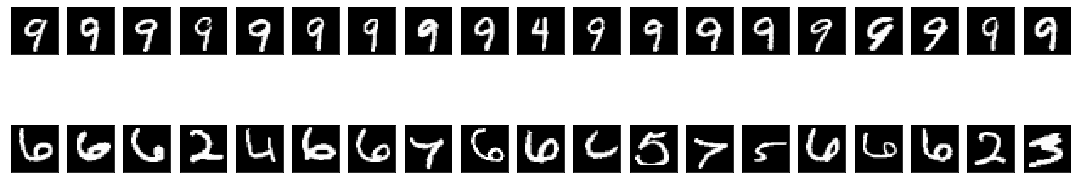

test label = 9 false_img


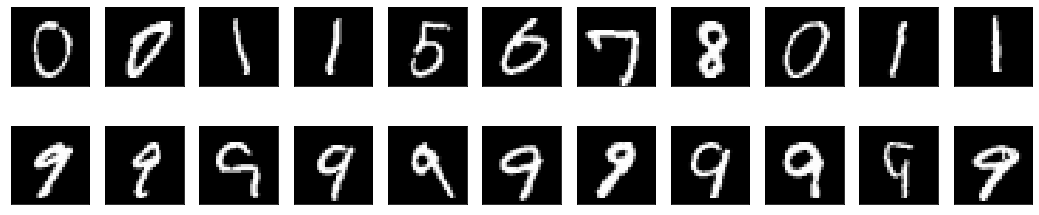

In [42]:
outlier_nu = 0.05
nu = 0.05
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)

Loading  0


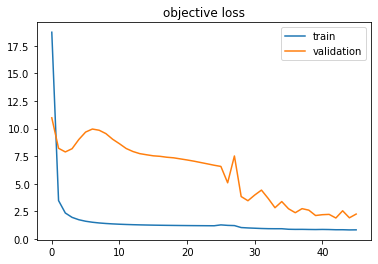

auc =  0.9314119417168197
Loading  1


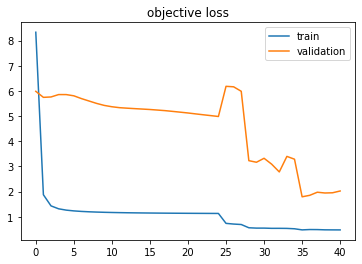

auc =  0.9892129370811811
Loading  2


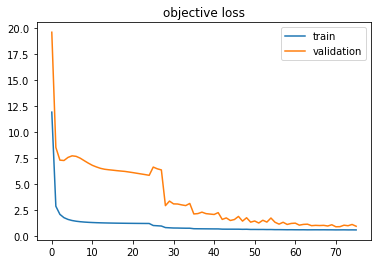

auc =  0.7692305198846544
Loading  3


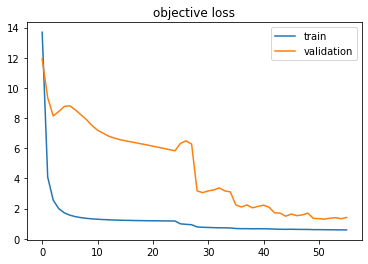

auc =  0.8740975120871375
Loading  4


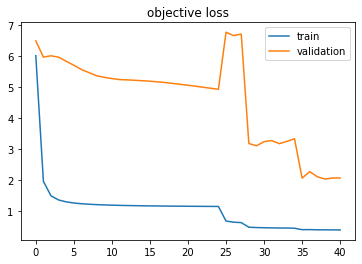

auc =  0.8461417287624344
Loading  5


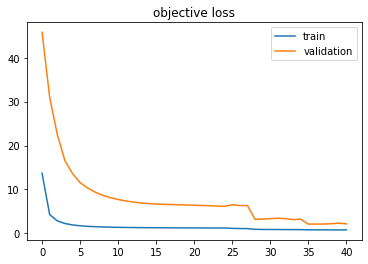

auc =  0.8384365811556784
Loading  6


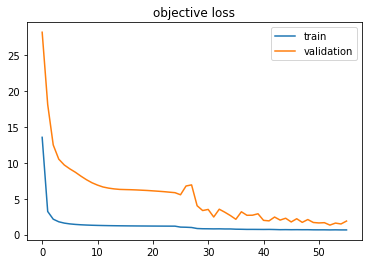

auc =  0.9133100275725574
Loading  7


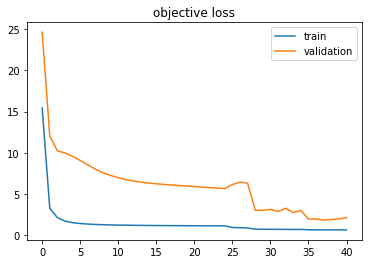

auc =  0.8931222037952923
Loading  8


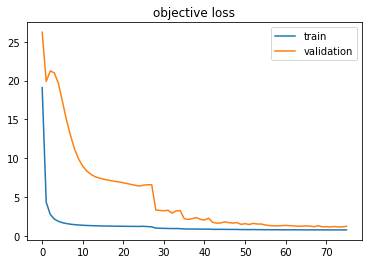

auc =  0.832981130032291
Loading  9


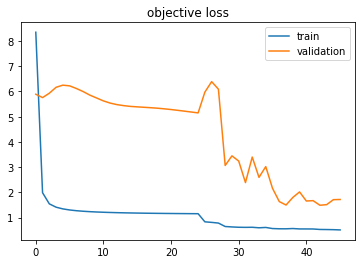

auc =  0.9271838736655387


array([[ 0.        ,  0.93449237,  0.93141194, 17.38549662],
       [ 1.        ,  0.98649724,  0.98921294, 16.02942491],
       [ 2.        ,  0.75460803,  0.76923052, 35.38091874],
       [ 3.        ,  0.8670807 ,  0.87409751, 22.75000882],
       [ 4.        ,  0.83839919,  0.84614173, 14.15799308],
       [ 5.        ,  0.83489365,  0.83843658, 13.55460954],
       [ 6.        ,  0.92382299,  0.91331003, 23.34692502],
       [ 7.        ,  0.88708276,  0.8931222 , 15.19308758],
       [ 8.        ,  0.84566419,  0.83298113, 32.84502029],
       [ 9.        ,  0.92894825,  0.92718387, 17.47334957]])

In [67]:
smoothing =7
warm_up_n_epochs = 25
lr_change = 0.1
lr_milestone = 30
nu = 0.1
outlier_nu = 0.1
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(0, train_dataset)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_SVDD.train( train_dataset, x_vali, warm_up_n_epochs =  warm_up_n_epochs, smoothing = smoothing)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    train_confusionmatrix_list.append(train_confusionmatrix)
    test_confusionmatrix_list.append(confusionmatrix)
result

Loading  0
AUC: 0.9346828784719211
confusion_matrix:
[[ 406  186]
 [ 335 5588]]


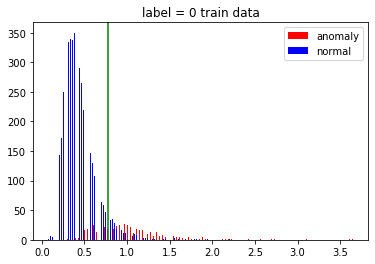

 train label = 0 uncertain_img


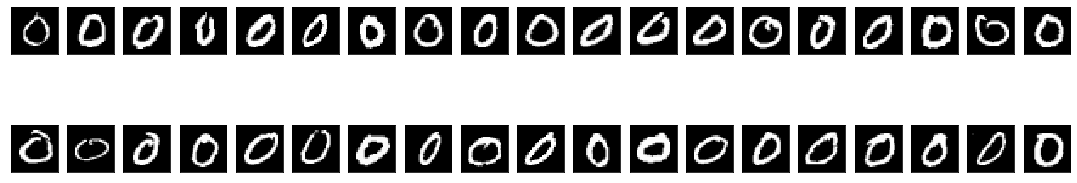

train label = 0 distance oder


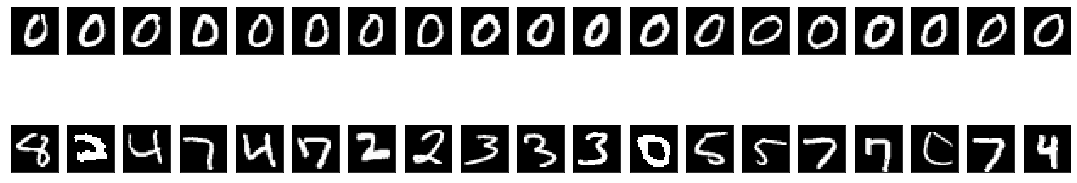

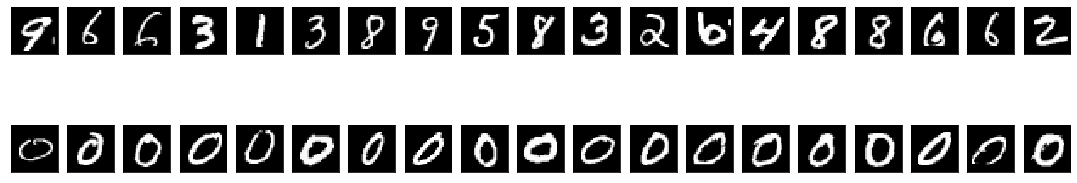

AUC: 0.9314119417168197
confusion_matrix:
[[6070 2950]
 [  48  932]]


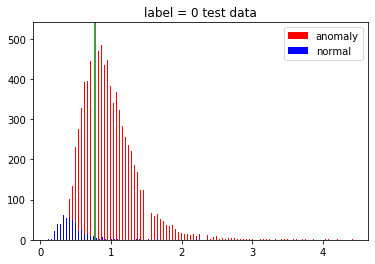

test label = 0 uncertain_img


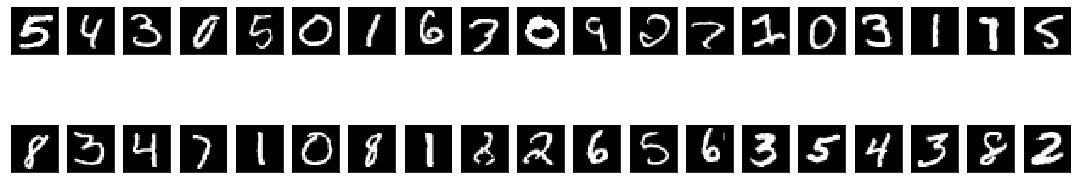

test label = 0 distance oder


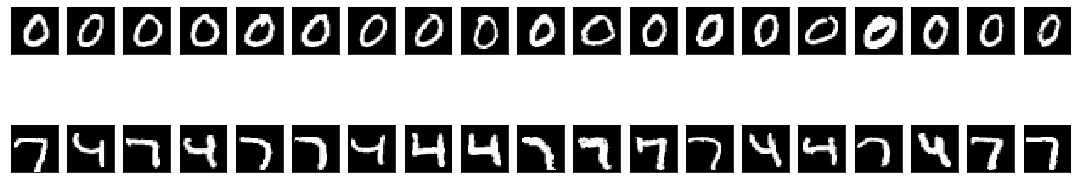

test label = 0 false_img


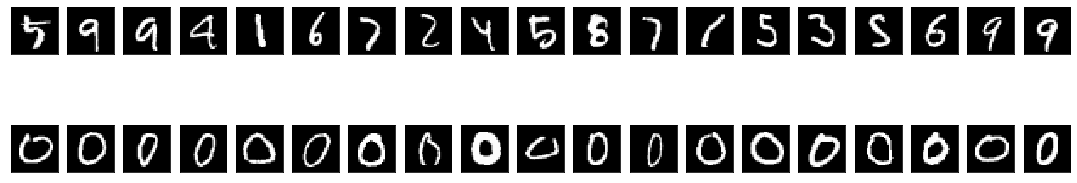

Loading  1
AUC: 0.9869725807573237
confusion_matrix:
[[ 511  163]
 [ 105 6637]]


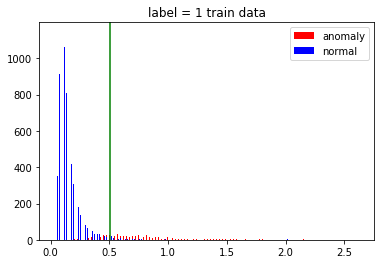

 train label = 1 uncertain_img


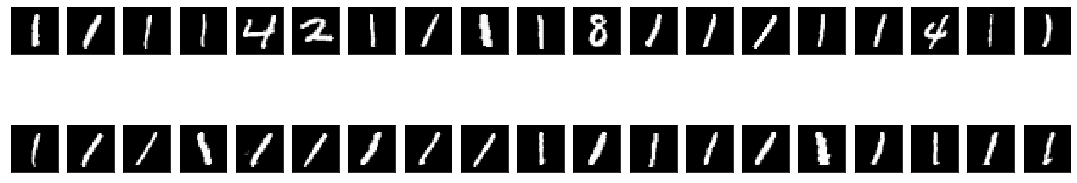

train label = 1 distance oder


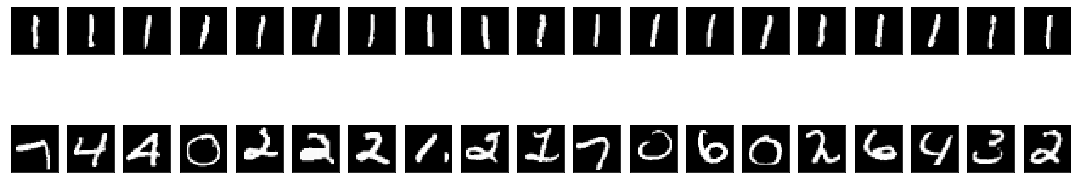

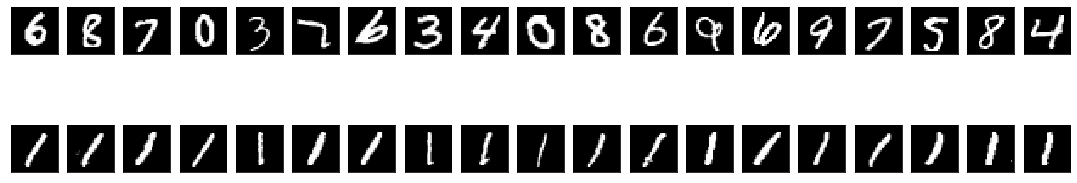

AUC: 0.9892129370811811
confusion_matrix:
[[6851 2014]
 [  16 1119]]


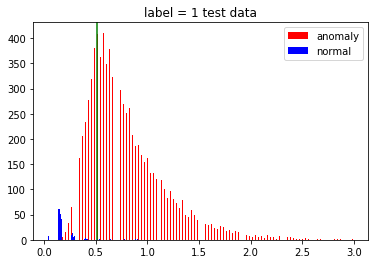

test label = 1 uncertain_img


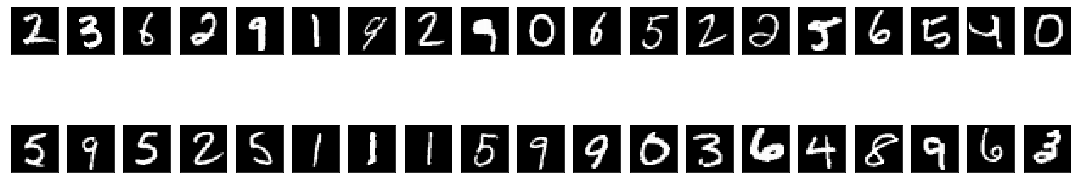

test label = 1 distance oder


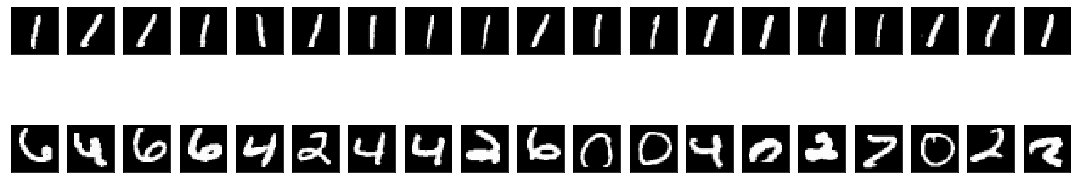

test label = 1 false_img


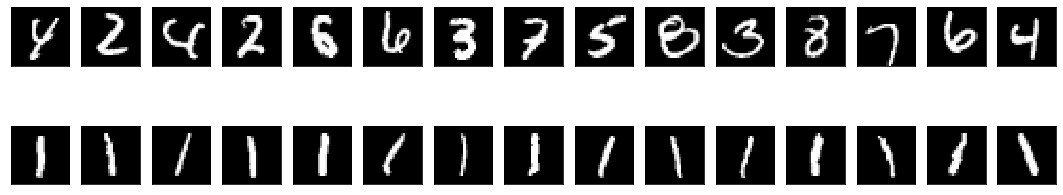

Loading  2
AUC: 0.7794595783932909
confusion_matrix:
[[ 133  462]
 [ 165 5793]]


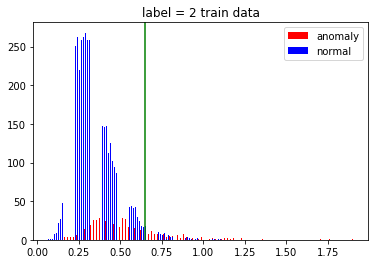

 train label = 2 uncertain_img


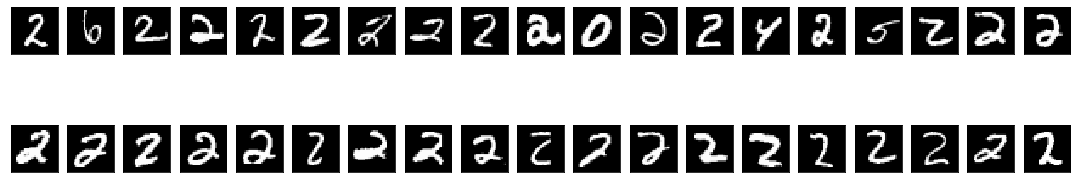

train label = 2 distance oder


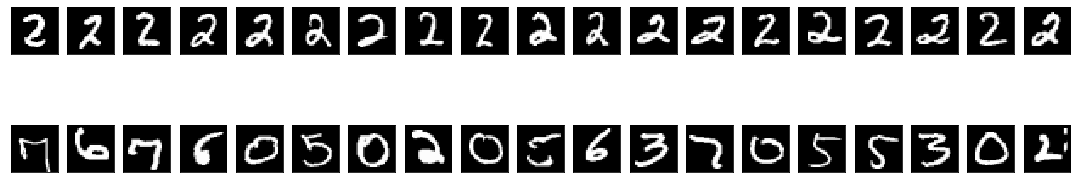

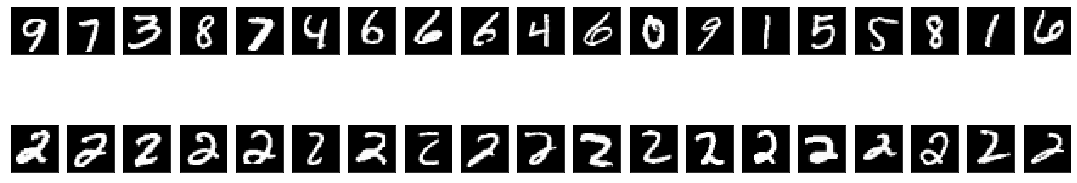

AUC: 0.7692305198846544
confusion_matrix:
[[1913 7055]
 [  23 1009]]


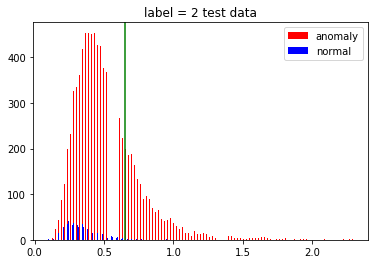

test label = 2 uncertain_img


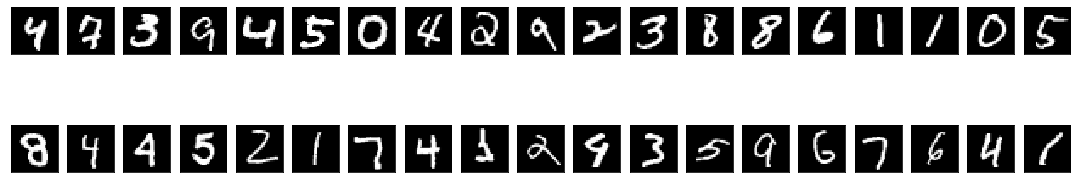

test label = 2 distance oder


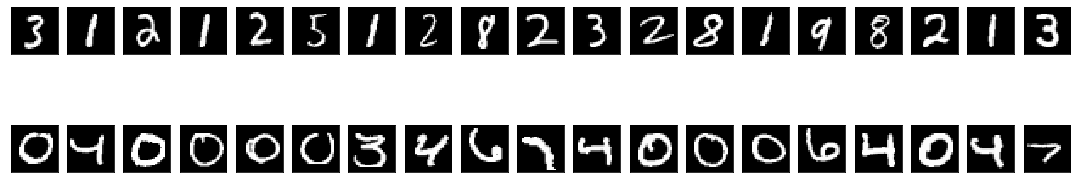

test label = 2 false_img


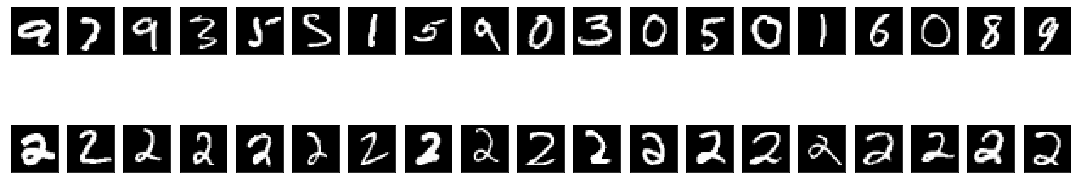

Loading  3
AUC: 0.8666509858305729
confusion_matrix:
[[ 293  320]
 [ 356 5775]]


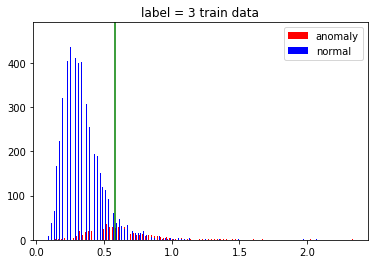

 train label = 3 uncertain_img


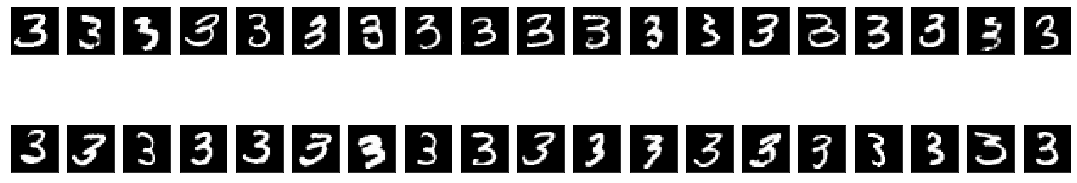

train label = 3 distance oder


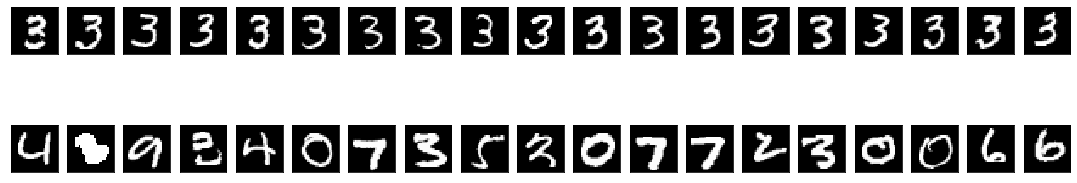

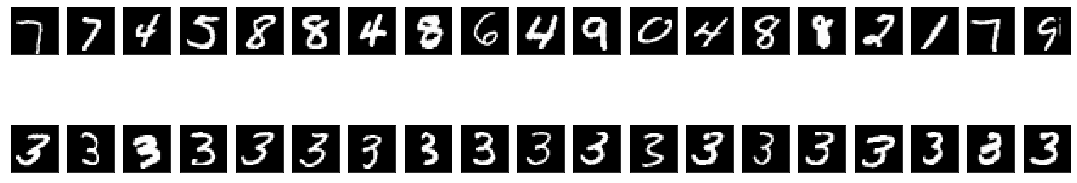

AUC: 0.8740975120871375
confusion_matrix:
[[4418 4572]
 [  65  945]]


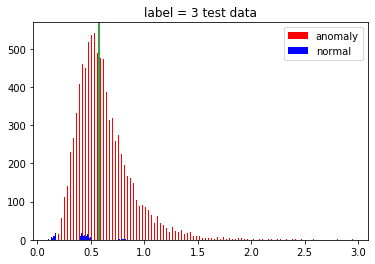

test label = 3 uncertain_img


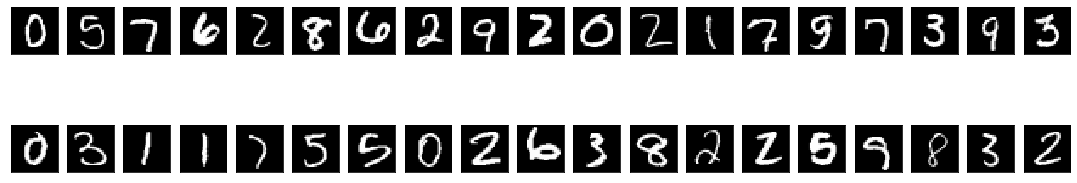

test label = 3 distance oder


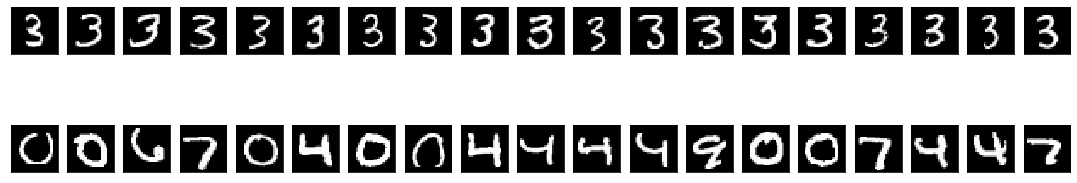

test label = 3 false_img


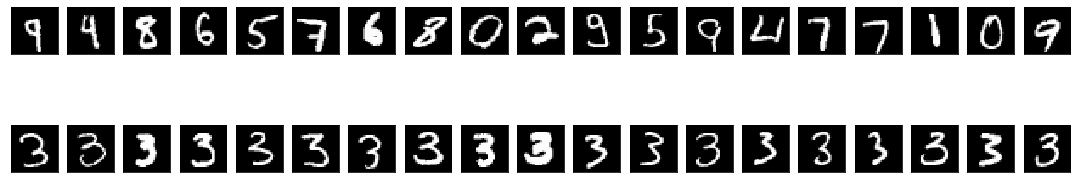

Loading  4
AUC: 0.8448273133145432
confusion_matrix:
[[ 251  333]
 [ 340 5502]]


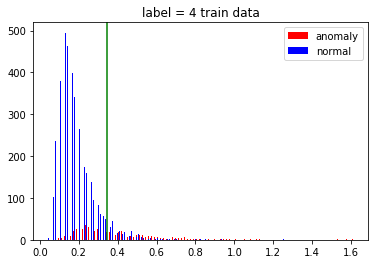

 train label = 4 uncertain_img


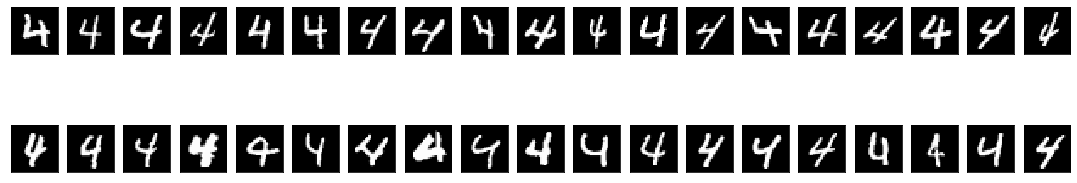

train label = 4 distance oder


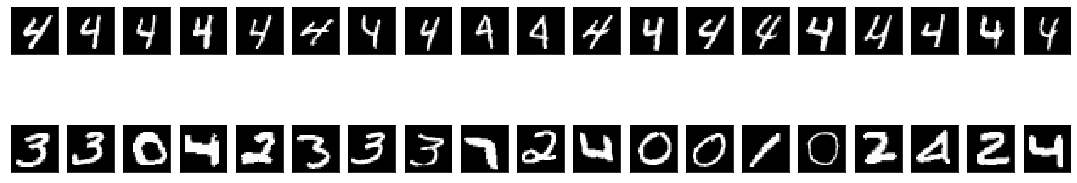

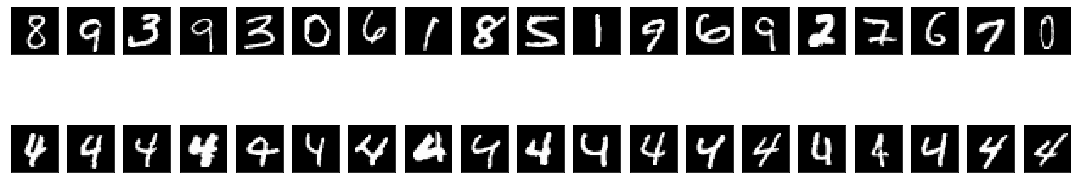

AUC: 0.8461417287624344
confusion_matrix:
[[3966 5052]
 [  56  926]]


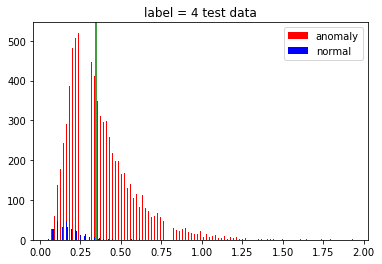

test label = 4 uncertain_img


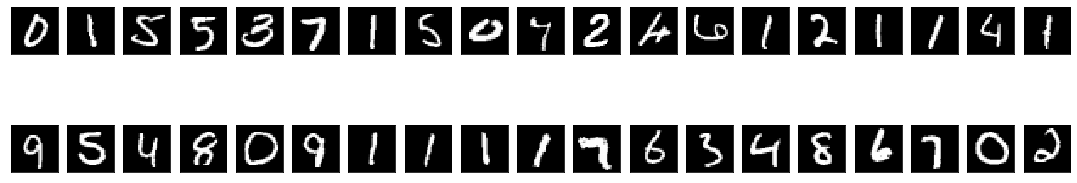

test label = 4 distance oder


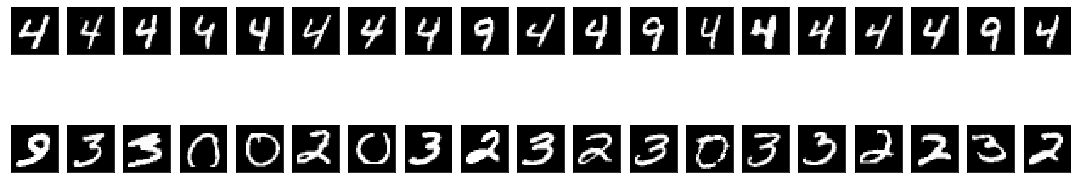

test label = 4 false_img


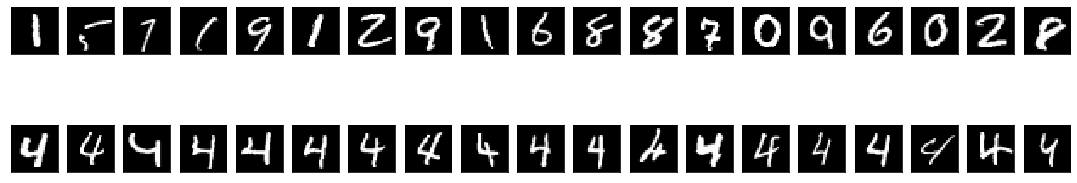

Loading  5
AUC: 0.856000751485102
confusion_matrix:
[[ 255  287]
 [ 288 5133]]


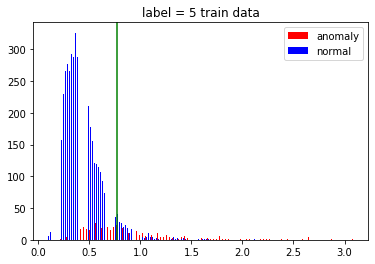

 train label = 5 uncertain_img


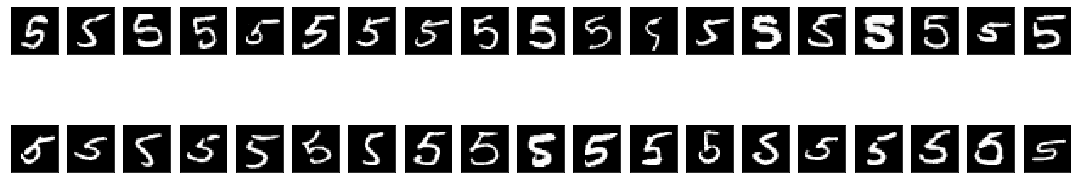

train label = 5 distance oder


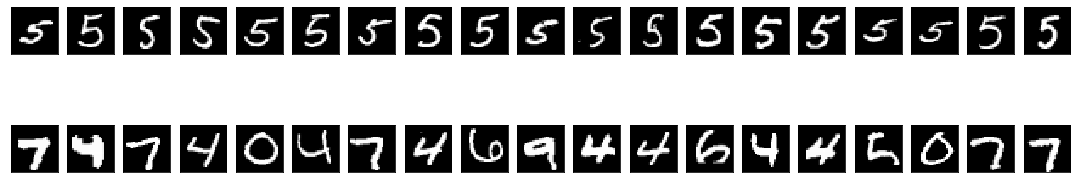

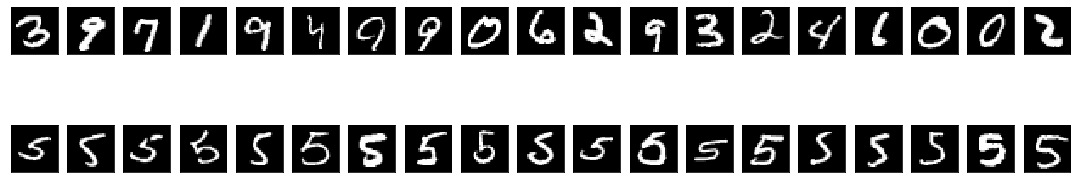

AUC: 0.8384365811556784
confusion_matrix:
[[3898 5210]
 [  51  841]]


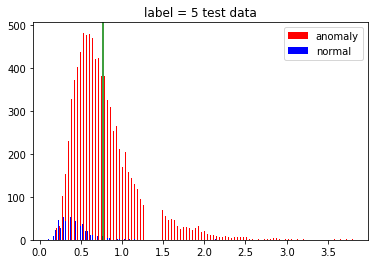

test label = 5 uncertain_img


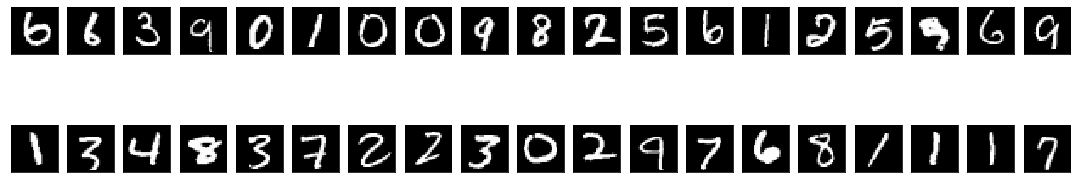

test label = 5 distance oder


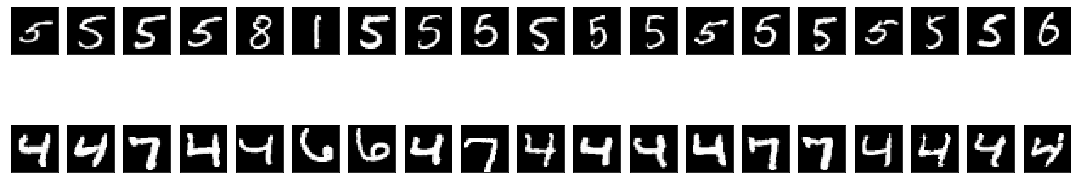

test label = 5 false_img


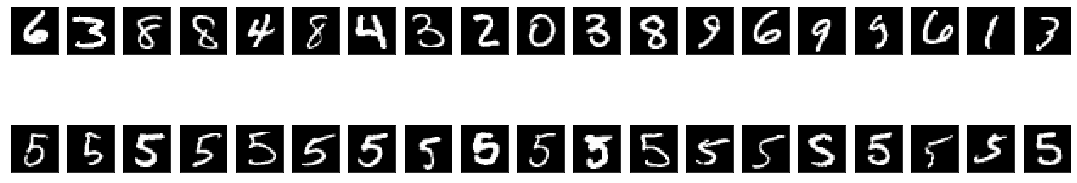

Loading  6
AUC: 0.9193143862911568
confusion_matrix:
[[ 475  116]
 [ 781 5137]]


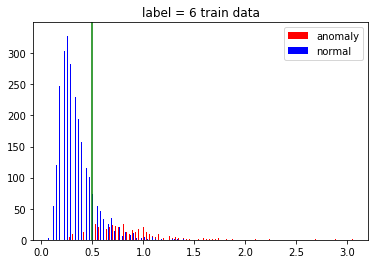

 train label = 6 uncertain_img


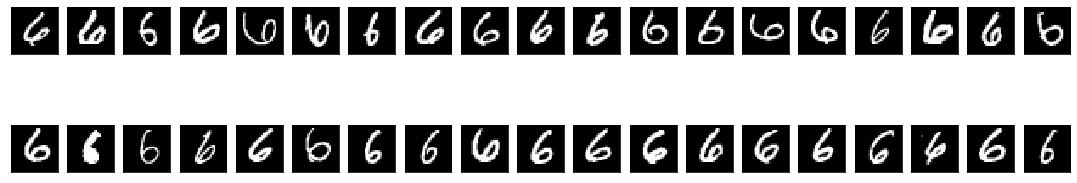

train label = 6 distance oder


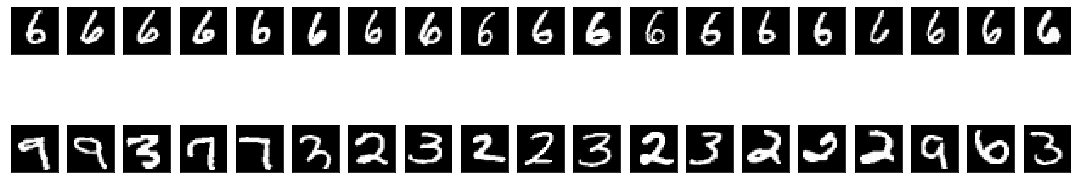

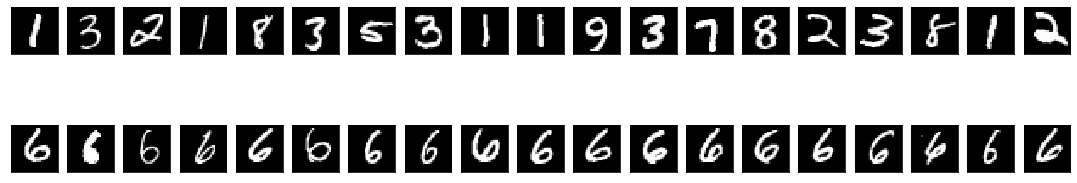

AUC: 0.9133100275725574
confusion_matrix:
[[7376 1666]
 [ 146  812]]


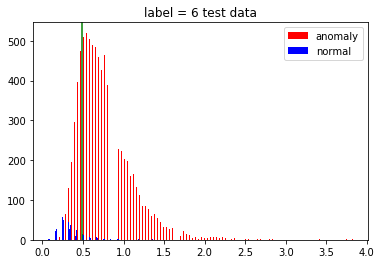

test label = 6 uncertain_img


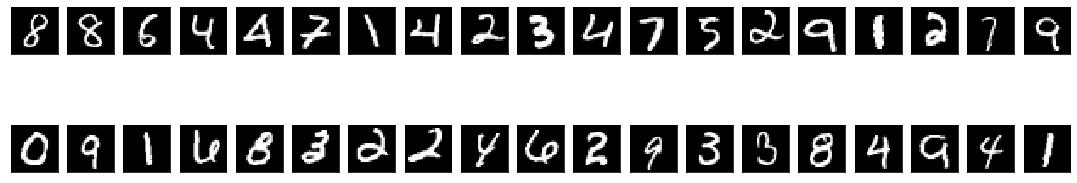

test label = 6 distance oder


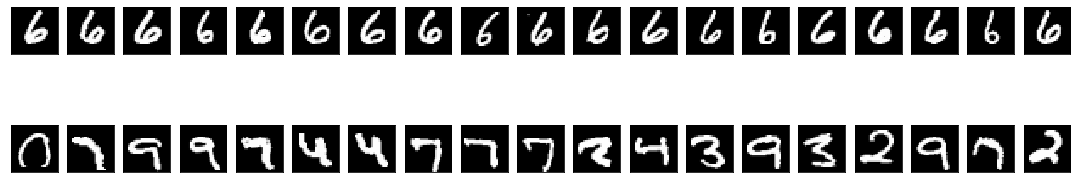

test label = 6 false_img


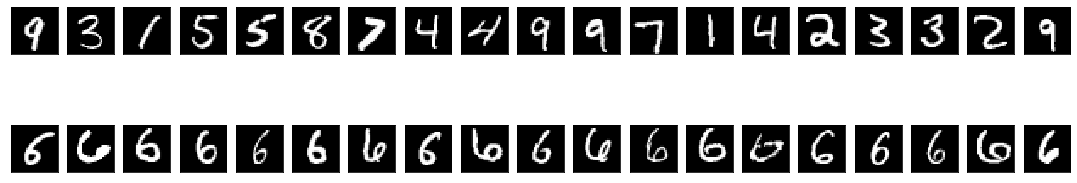

Loading  7
AUC: 0.8893645665737693
confusion_matrix:
[[ 335  291]
 [ 256 6009]]


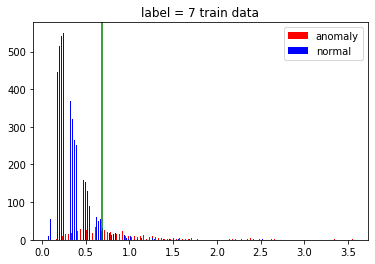

 train label = 7 uncertain_img


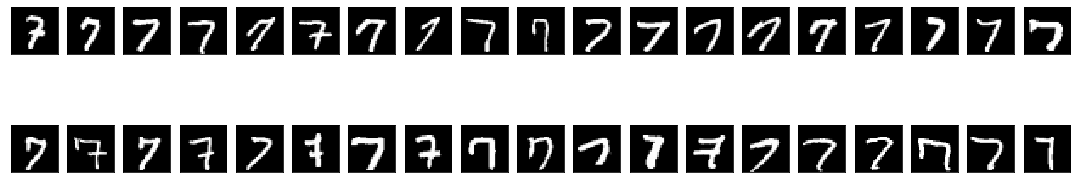

train label = 7 distance oder


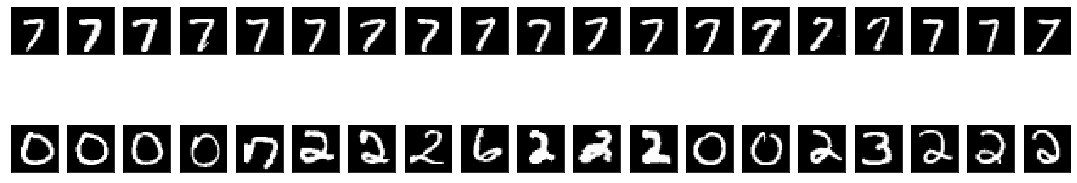

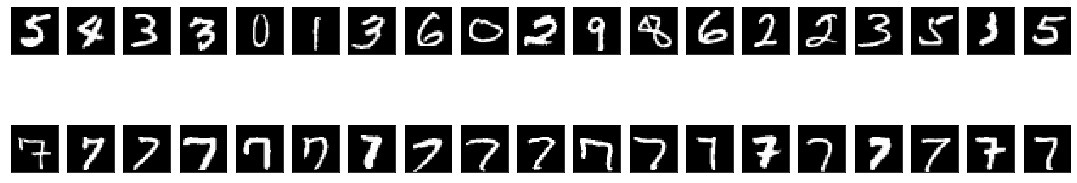

AUC: 0.8931222037952923
confusion_matrix:
[[4689 4283]
 [  51  977]]


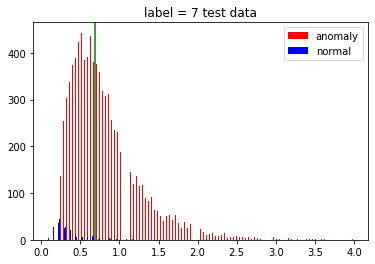

test label = 7 uncertain_img


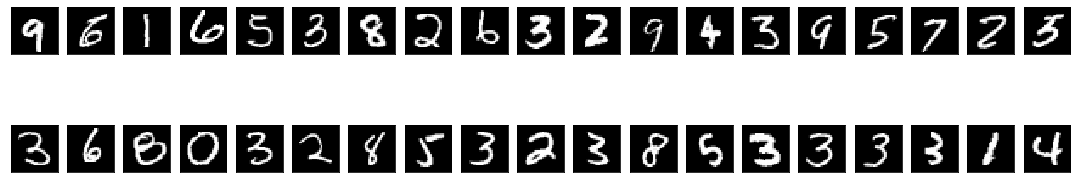

test label = 7 distance oder


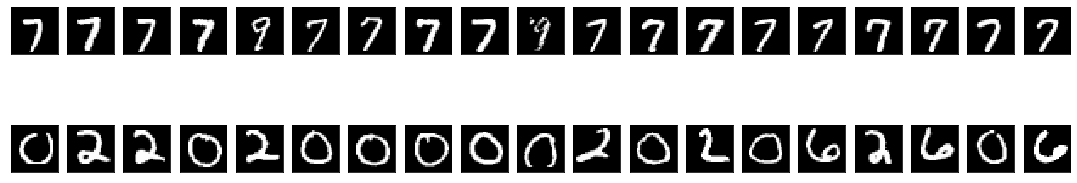

test label = 7 false_img


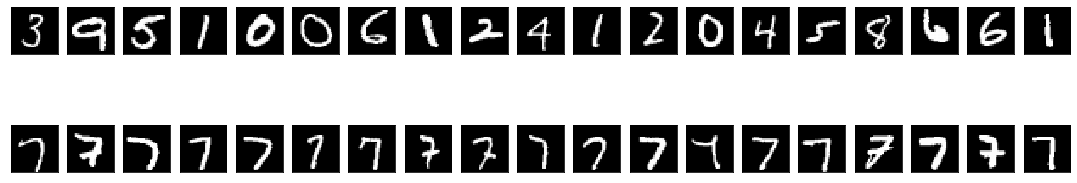

Loading  8
AUC: 0.8353733089675663
confusion_matrix:
[[ 288  297]
 [ 465 5386]]


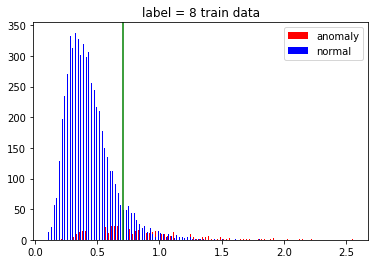

 train label = 8 uncertain_img


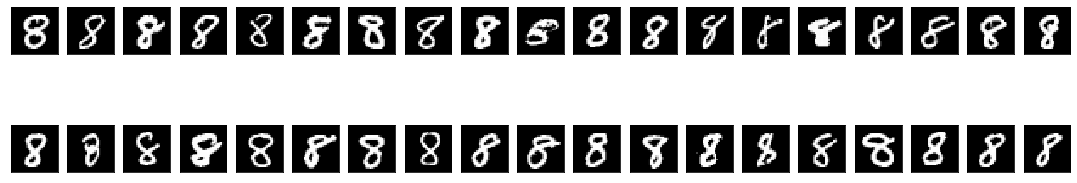

train label = 8 distance oder


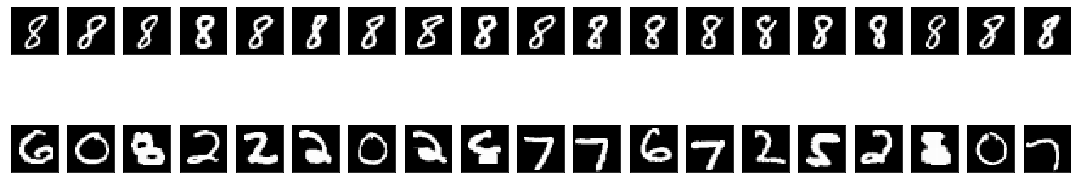

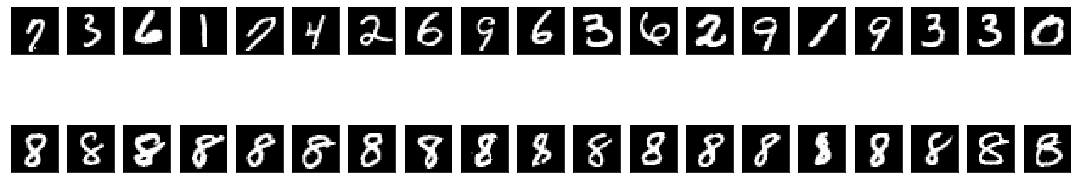

AUC: 0.832981130032291
confusion_matrix:
[[4619 4407]
 [  90  884]]


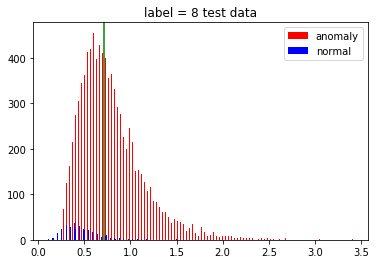

test label = 8 uncertain_img


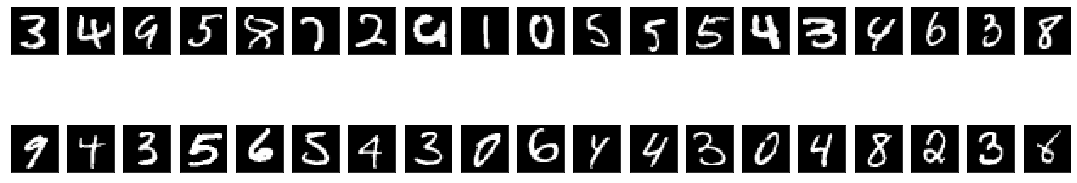

test label = 8 distance oder


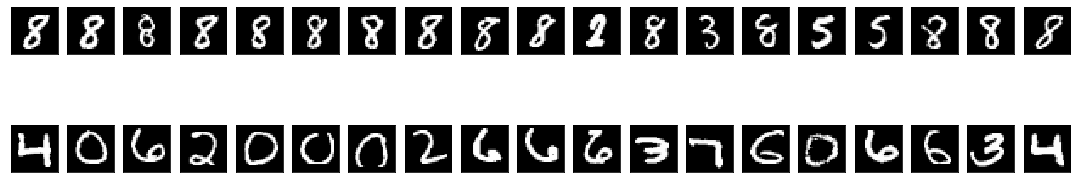

test label = 8 false_img


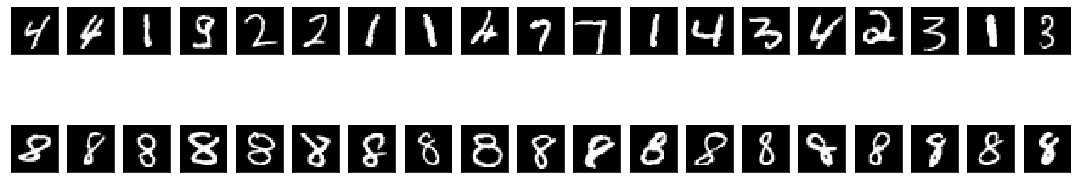

Loading  9
AUC: 0.9356398070467662
confusion_matrix:
[[ 260  334]
 [ 129 5820]]


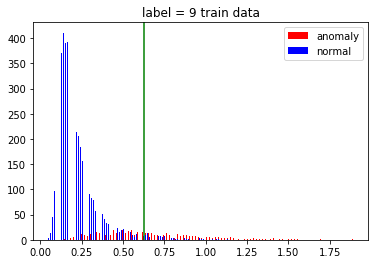

 train label = 9 uncertain_img


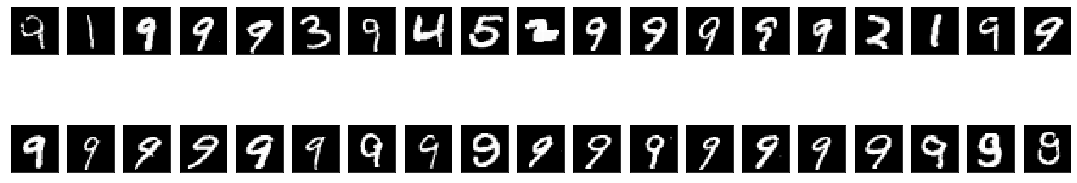

train label = 9 distance oder


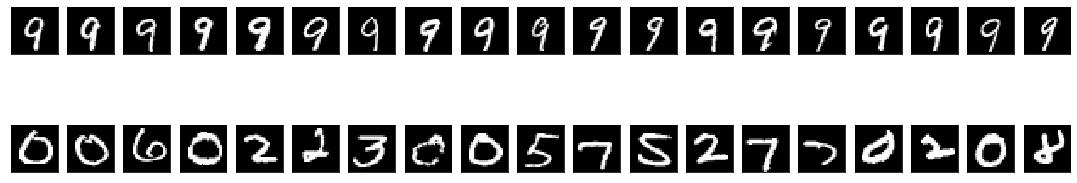

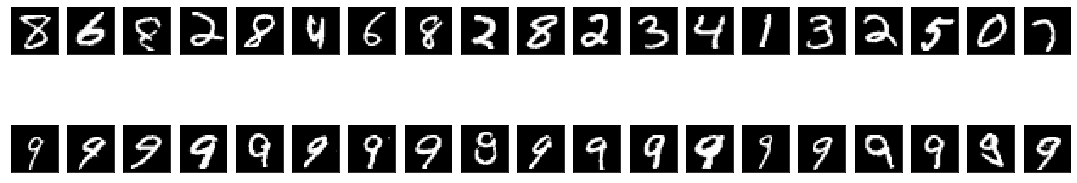

AUC: 0.9271838736655387
confusion_matrix:
[[3679 5312]
 [  22  987]]


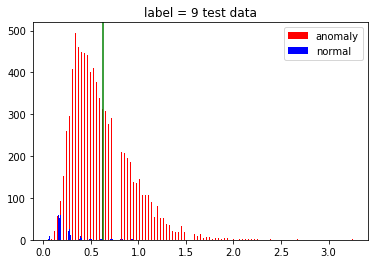

test label = 9 uncertain_img


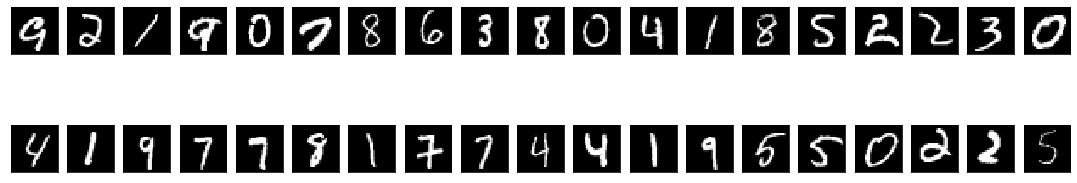

test label = 9 distance oder


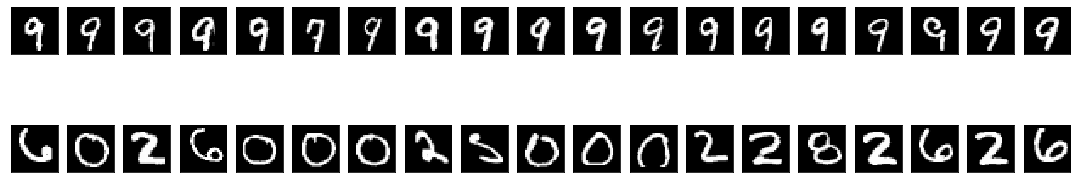

test label = 9 false_img


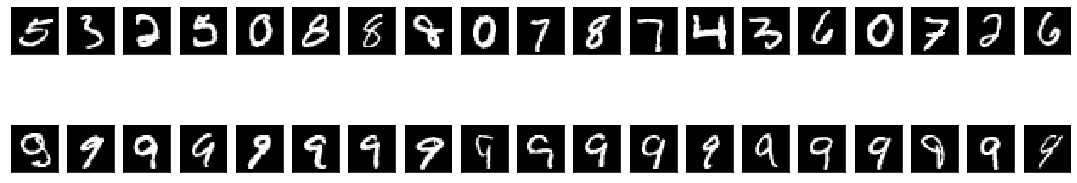

In [69]:
outlier_nu = 0.1
nu = 0.1
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)

Loading  0


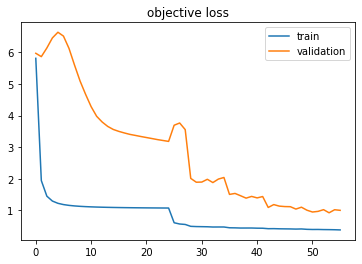

auc =  0.9010498778225259
Loading  1


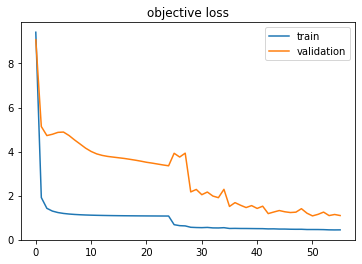

auc =  0.9808478126374324
Loading  2


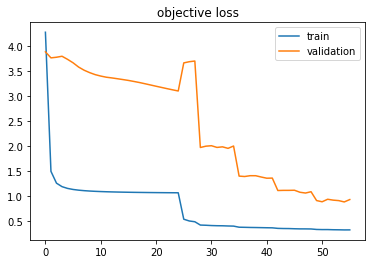

auc =  0.6853412693884889
Loading  3


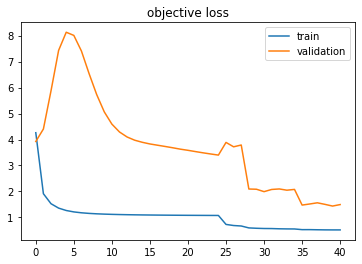

auc =  0.8272189121025562
Loading  4


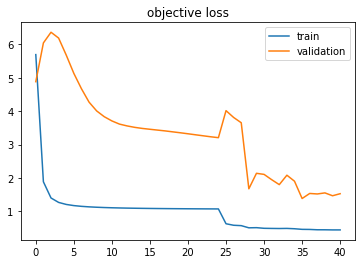

auc =  0.8183594905685347
Loading  5


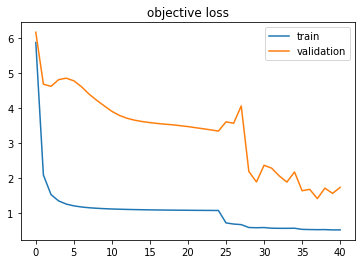

auc =  0.7809102183858472
Loading  6


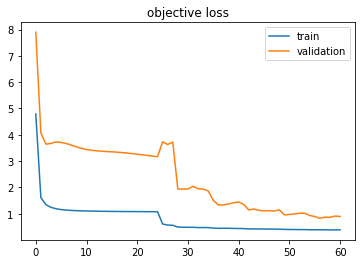

auc =  0.867335870322628
Loading  7


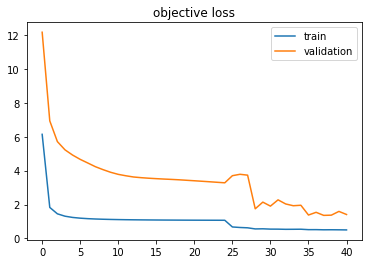

auc =  0.8760573318460719
Loading  8


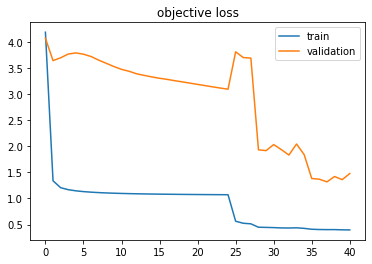

auc =  0.7931592556479548
Loading  9


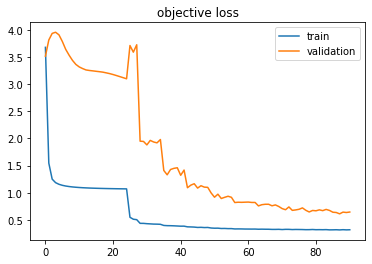

auc =  0.8800101720484937


array([[ 0.        ,  0.90441237,  0.90104988, 23.13343763],
       [ 1.        ,  0.97572488,  0.98084781, 24.54311204],
       [ 2.        ,  0.67607827,  0.68534127, 22.58403492],
       [ 3.        ,  0.81091612,  0.82721891, 16.12246609],
       [ 4.        ,  0.82179998,  0.81835949, 16.52951455],
       [ 5.        ,  0.78556476,  0.78091022, 15.51922774],
       [ 6.        ,  0.88183378,  0.86733587, 29.45549464],
       [ 7.        ,  0.88074202,  0.87605733, 16.47945142],
       [ 8.        ,  0.78848688,  0.79315926, 16.49657774],
       [ 9.        ,  0.87008156,  0.88001017, 44.23834825]])

In [24]:
smoothing =7
warm_up_n_epochs = 25
lr_change = 0.1
lr_milestone = 28
nu = 0.2
outlier_nu = 0.2
result = np.zeros((10, 4))
train_confusionmatrix_list = []
test_confusionmatrix_list = []

for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae(0, train_dataset)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_SVDD.train( train_dataset, x_vali, warm_up_n_epochs =  warm_up_n_epochs, smoothing = smoothing)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 1] = train_auc
    result[label_num, 2] = test_auc
    result[label_num, 3] = train_time
    train_confusionmatrix_list.append(train_confusionmatrix)
    test_confusionmatrix_list.append(confusionmatrix)
result

Loading  0
AUC: 0.9028097350685145
confusion_matrix:
[[ 799  385]
 [ 528 5395]]


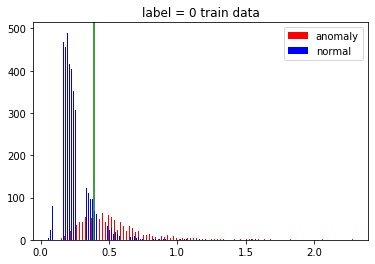

 train label = 0 uncertain_img


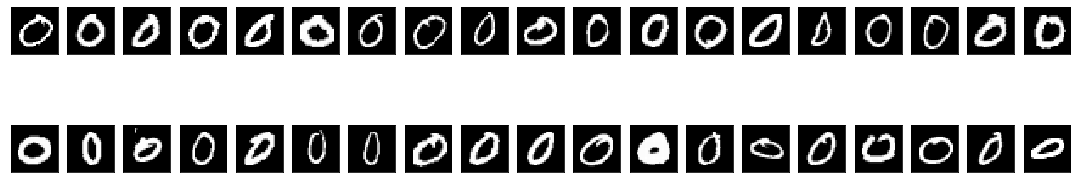

train label = 0 distance oder


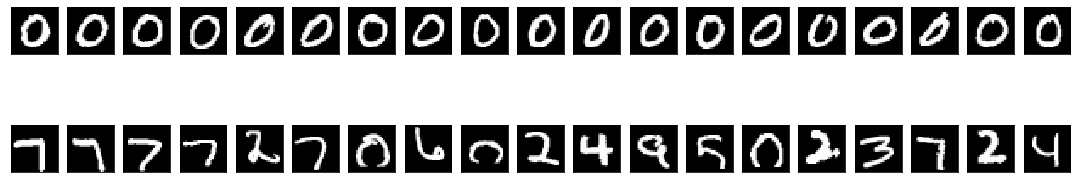

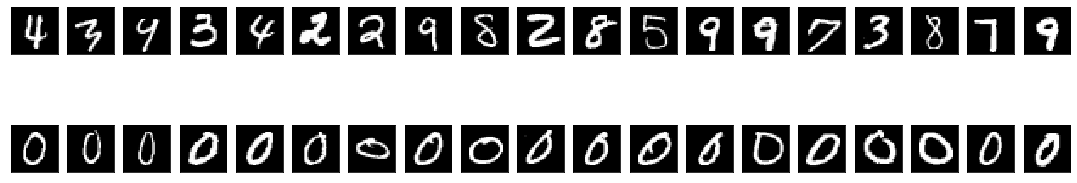

AUC: 0.9010498778225259
confusion_matrix:
[[6060 2960]
 [  94  886]]


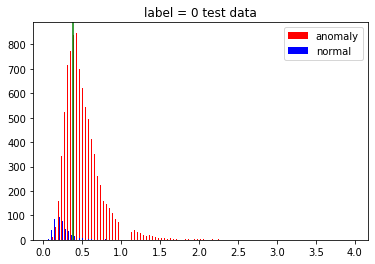

test label = 0 uncertain_img


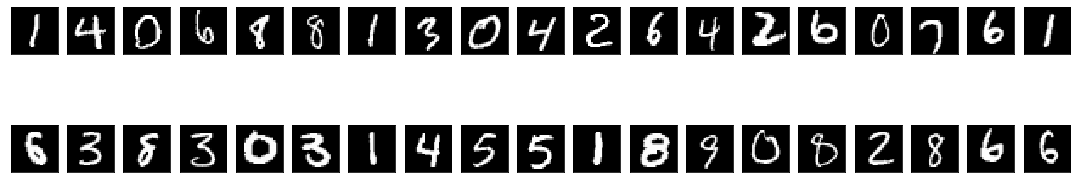

test label = 0 distance oder


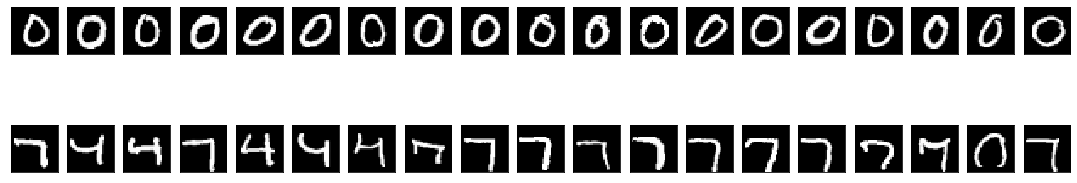

test label = 0 false_img


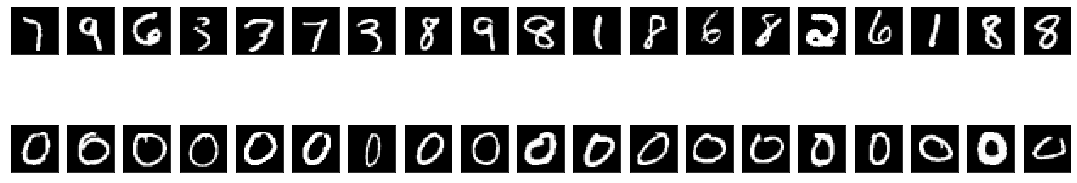

Loading  1
AUC: 0.9772673756873738
confusion_matrix:
[[1136  212]
 [ 266 6476]]


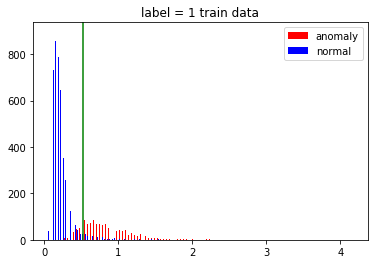

 train label = 1 uncertain_img


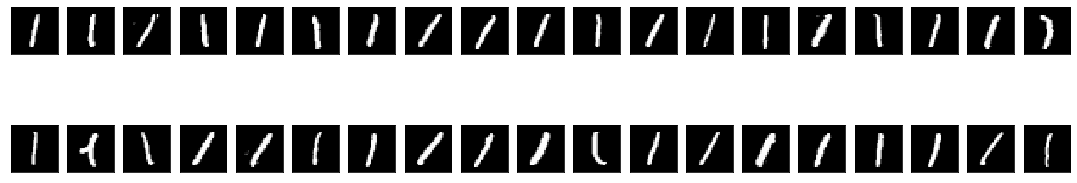

train label = 1 distance oder


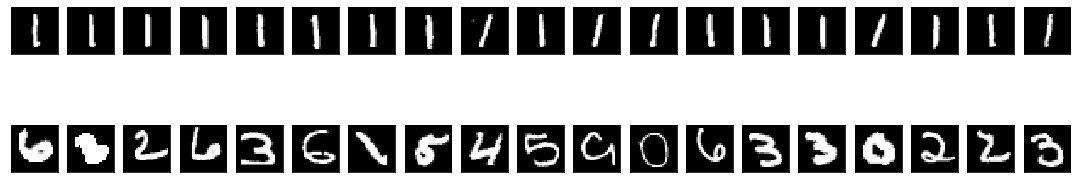

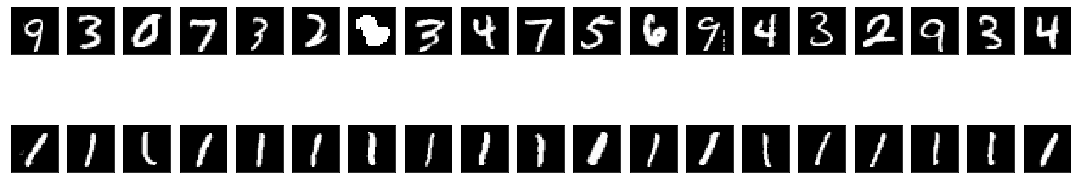

AUC: 0.9808478126374324
confusion_matrix:
[[7399 1466]
 [  27 1108]]


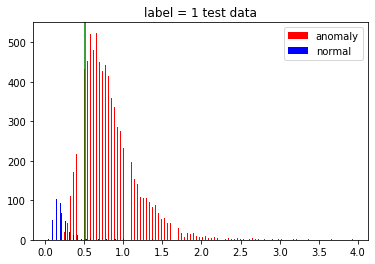

test label = 1 uncertain_img


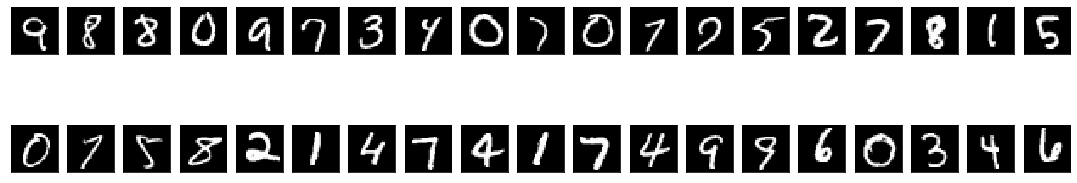

test label = 1 distance oder


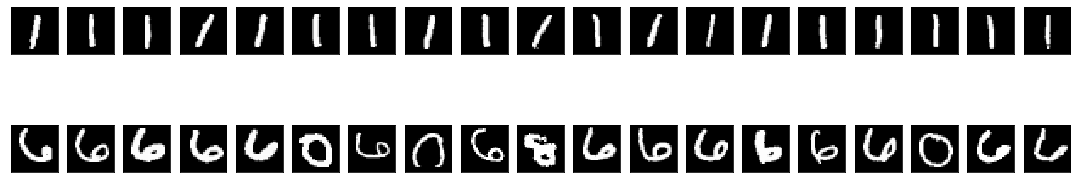

test label = 1 false_img


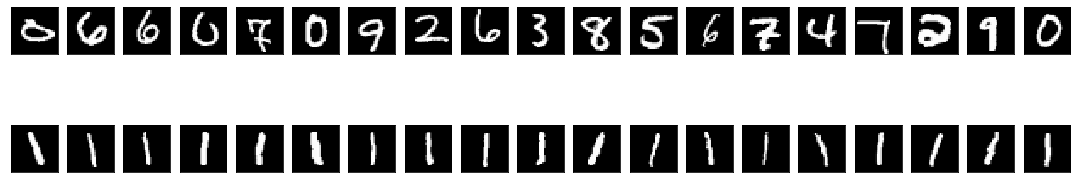

Loading  2
AUC: 0.6763909076381015
confusion_matrix:
[[ 413  778]
 [ 685 5273]]


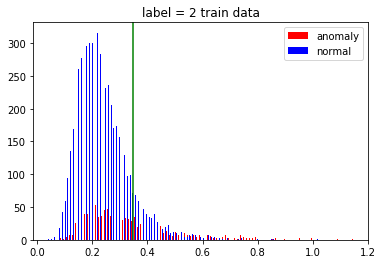

 train label = 2 uncertain_img


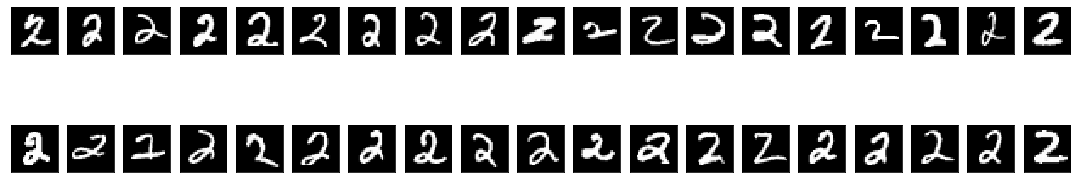

train label = 2 distance oder


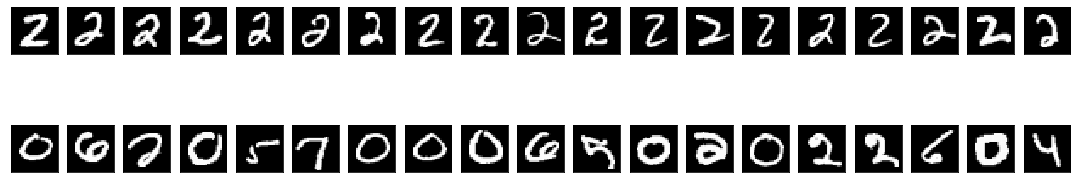

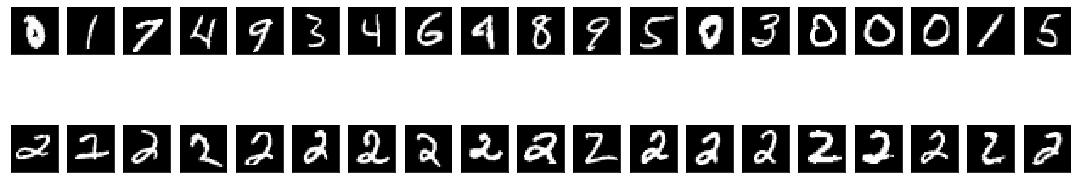

AUC: 0.6853412693884889
confusion_matrix:
[[2971 5997]
 [ 115  917]]


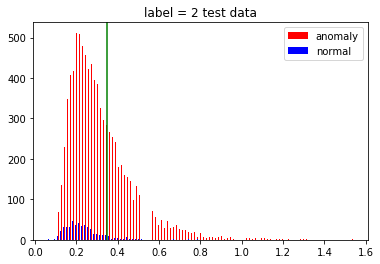

test label = 2 uncertain_img


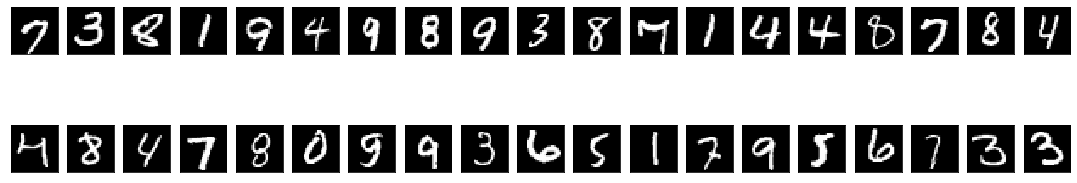

test label = 2 distance oder


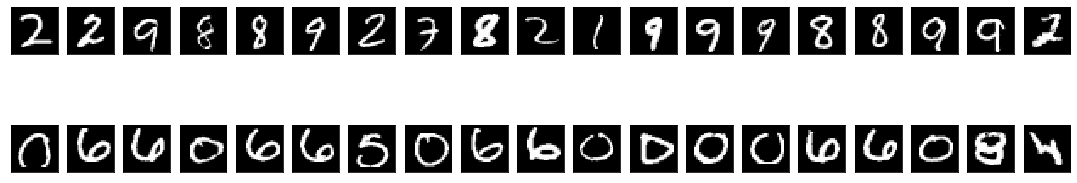

test label = 2 false_img


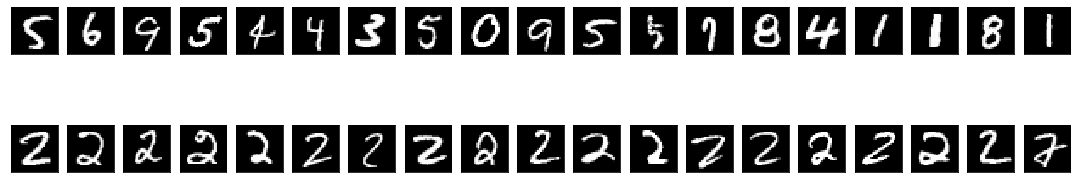

Loading  3
AUC: 0.8096559803719923
confusion_matrix:
[[ 679  547]
 [ 794 5337]]


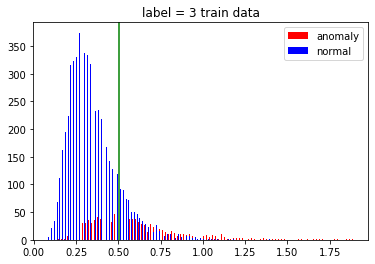

 train label = 3 uncertain_img


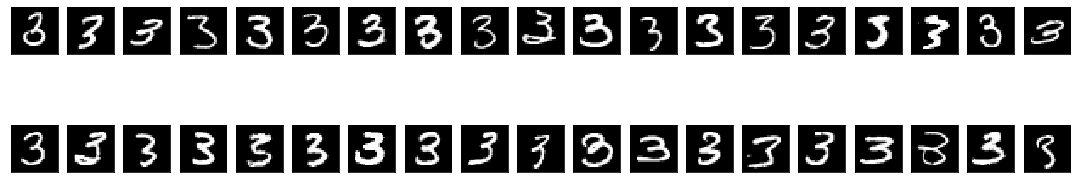

train label = 3 distance oder


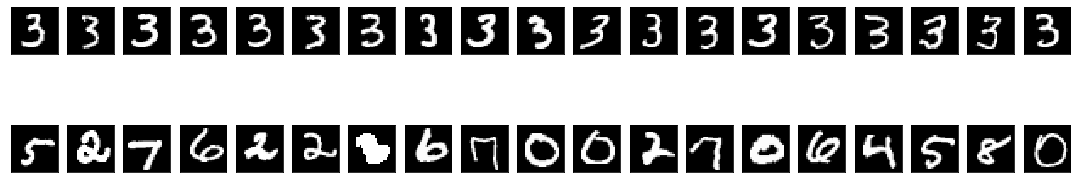

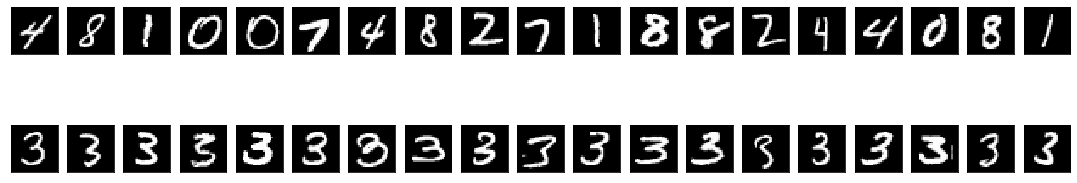

AUC: 0.8272189121025562
confusion_matrix:
[[4910 4080]
 [ 110  900]]


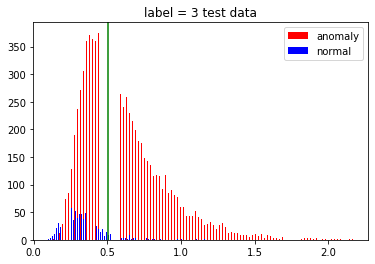

test label = 3 uncertain_img


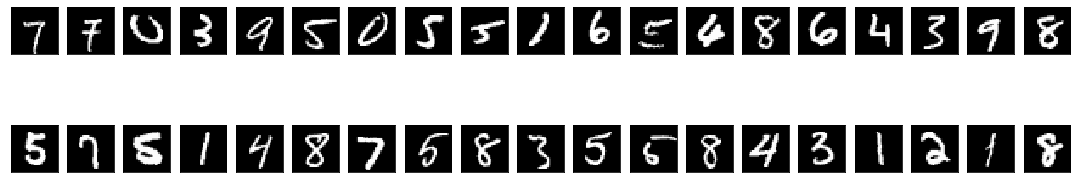

test label = 3 distance oder


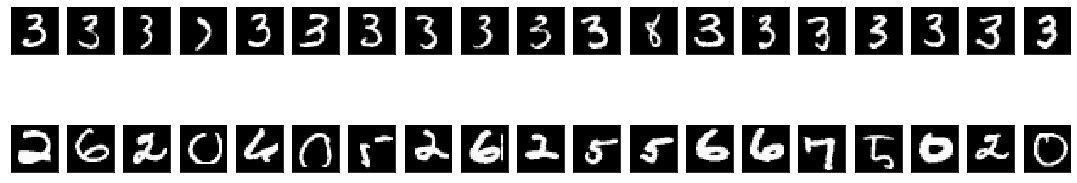

test label = 3 false_img


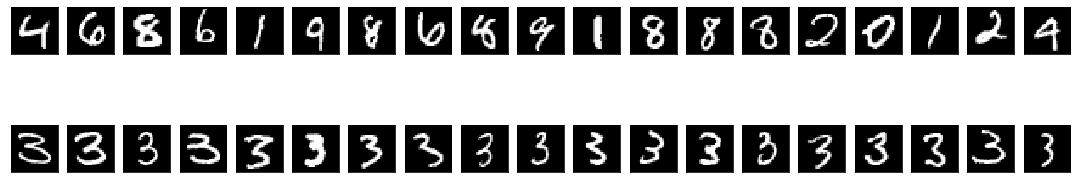

Loading  4
AUC: 0.8122219883882889
confusion_matrix:
[[ 628  540]
 [ 598 5244]]


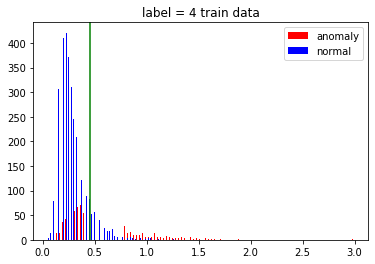

 train label = 4 uncertain_img


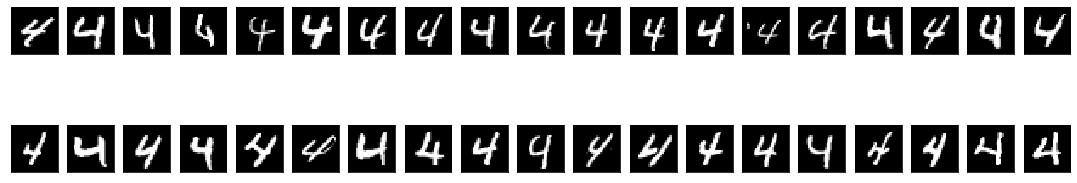

train label = 4 distance oder


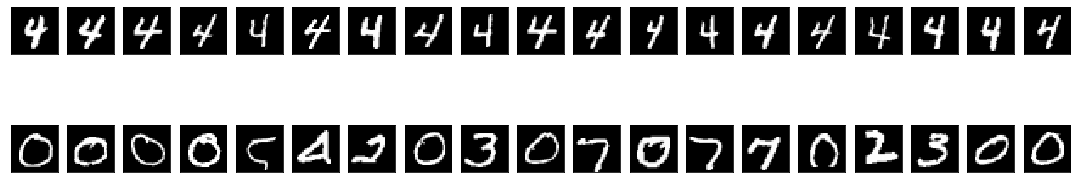

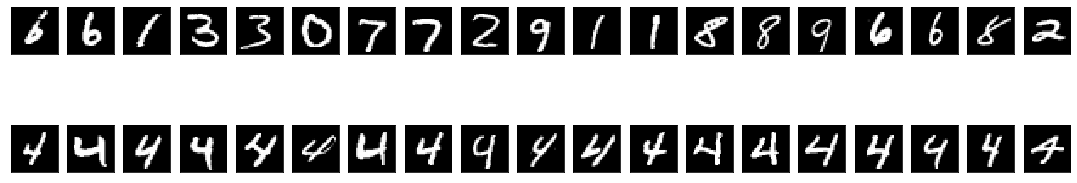

AUC: 0.8183594905685347
confusion_matrix:
[[4720 4298]
 [  95  887]]


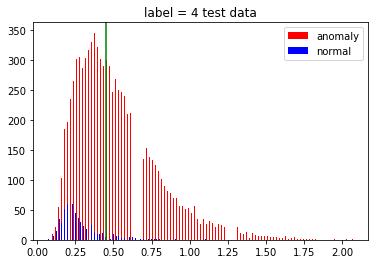

test label = 4 uncertain_img


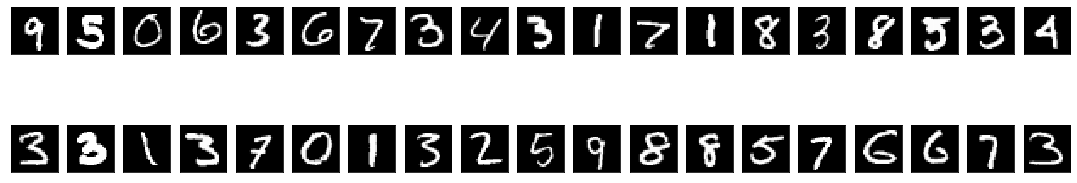

test label = 4 distance oder


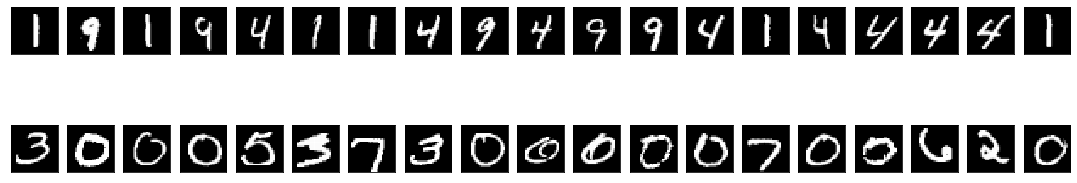

test label = 4 false_img


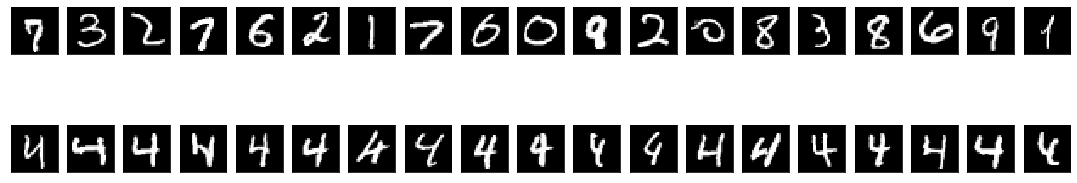

Loading  5
AUC: 0.7855399189022327
confusion_matrix:
[[ 834  250]
 [1923 3498]]


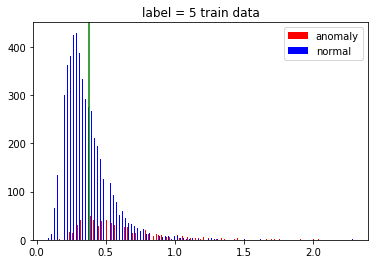

 train label = 5 uncertain_img


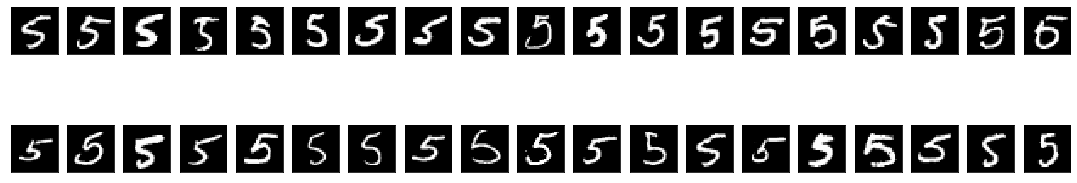

train label = 5 distance oder


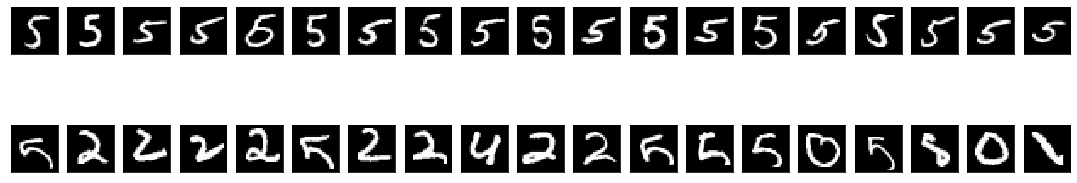

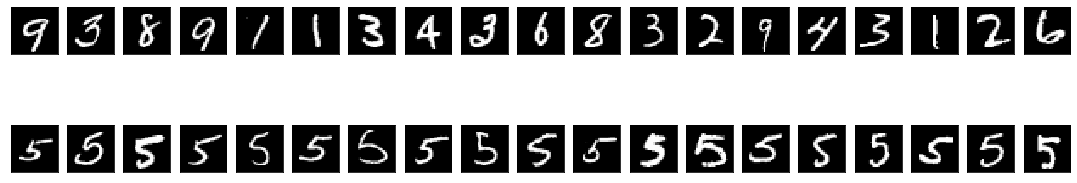

AUC: 0.7809102183858472
confusion_matrix:
[[6889 2219]
 [ 303  589]]


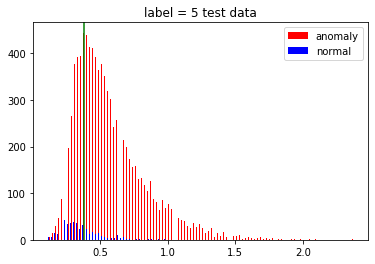

test label = 5 uncertain_img


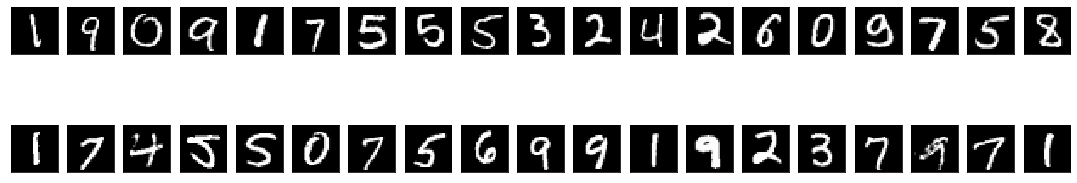

test label = 5 distance oder


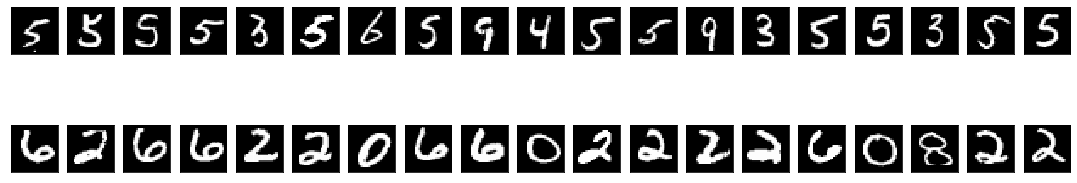

test label = 5 false_img


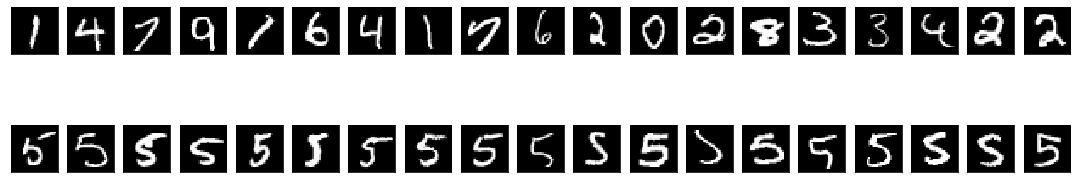

Loading  6
AUC: 0.8841193122005246
confusion_matrix:
[[ 582  601]
 [ 330 5588]]


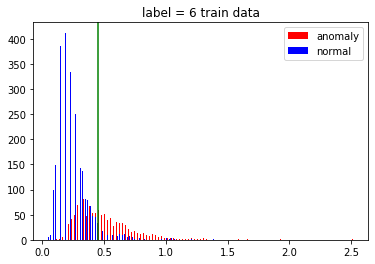

 train label = 6 uncertain_img


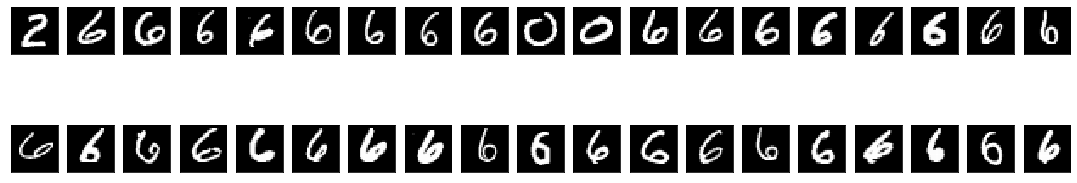

train label = 6 distance oder


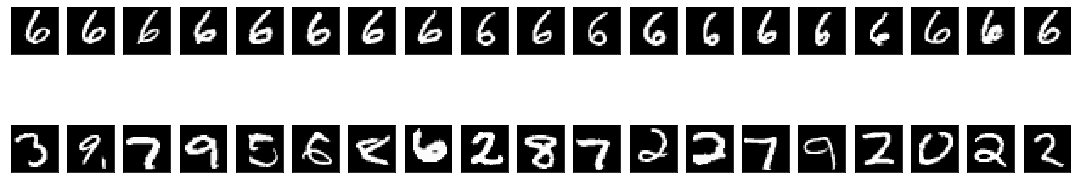

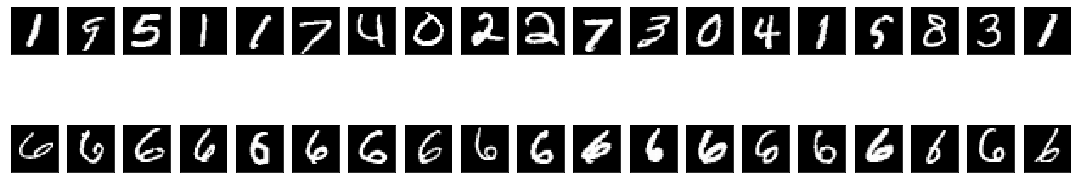

AUC: 0.867335870322628
confusion_matrix:
[[4477 4565]
 [  64  894]]


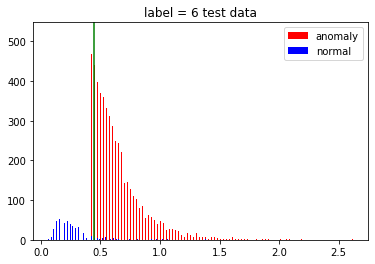

test label = 6 uncertain_img


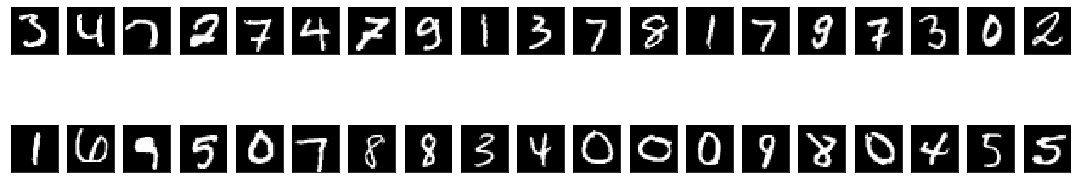

test label = 6 distance oder


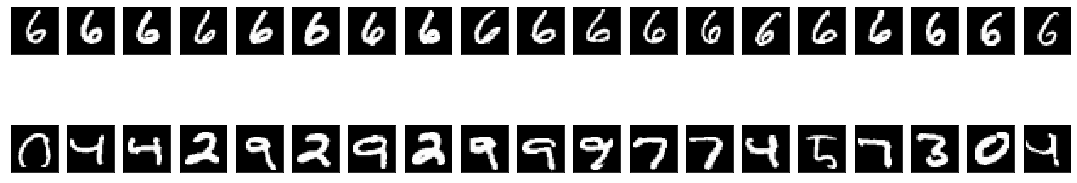

test label = 6 false_img


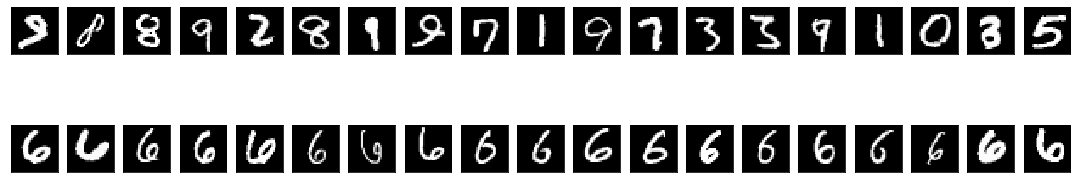

Loading  7
AUC: 0.8796973775309569
confusion_matrix:
[[ 635  618]
 [ 445 5820]]


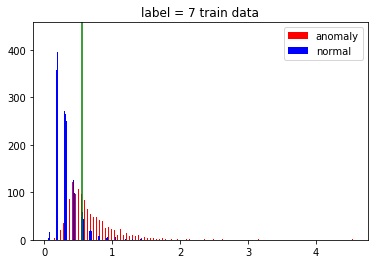

 train label = 7 uncertain_img


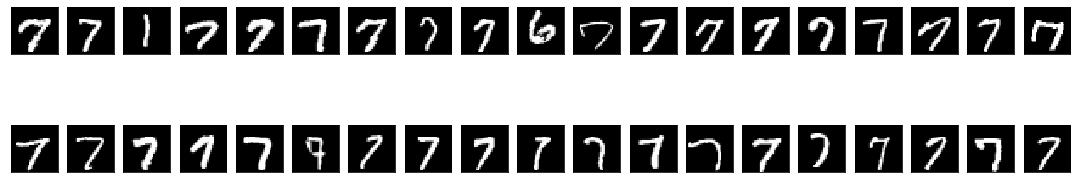

train label = 7 distance oder


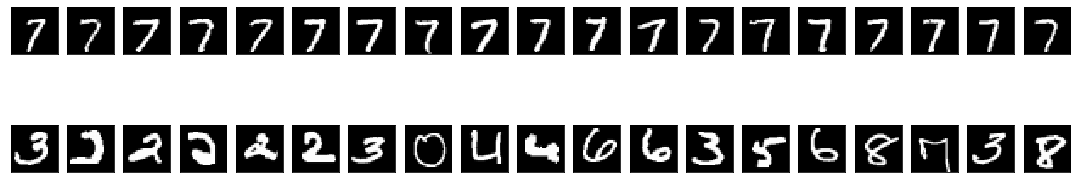

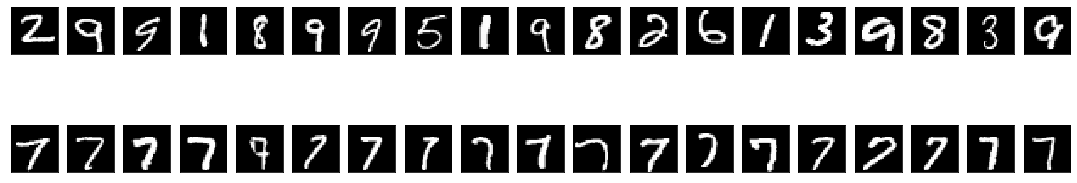

AUC: 0.8760573318460719
confusion_matrix:
[[4700 4272]
 [  72  956]]


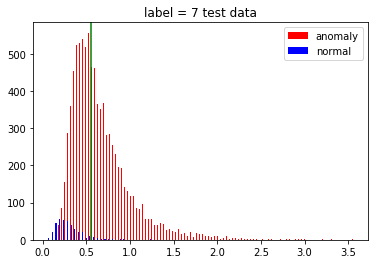

test label = 7 uncertain_img


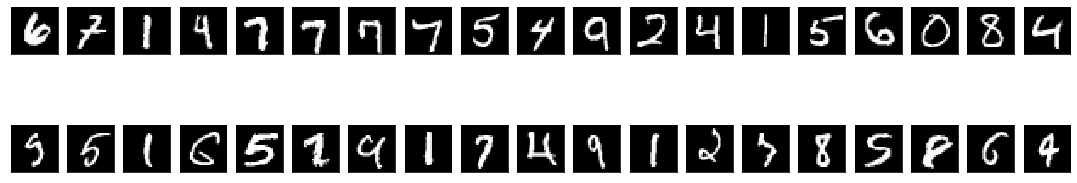

test label = 7 distance oder


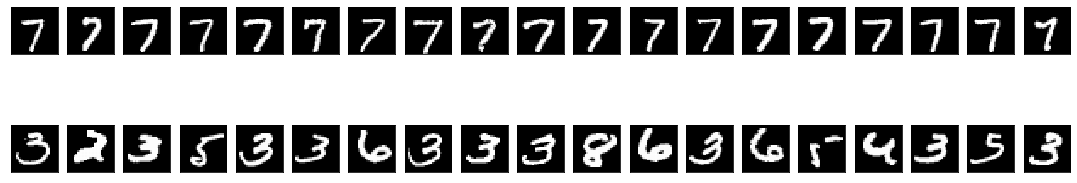

test label = 7 false_img


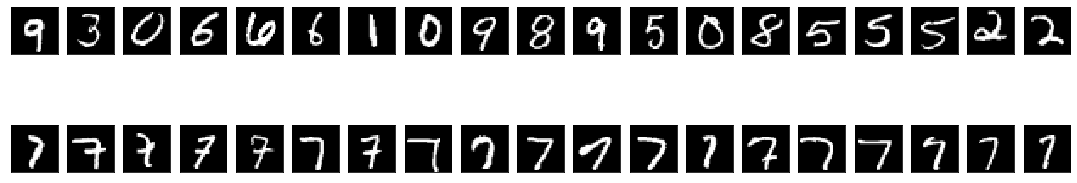

Loading  8
AUC: 0.7937874598103619
confusion_matrix:
[[ 649  521]
 [ 927 4924]]


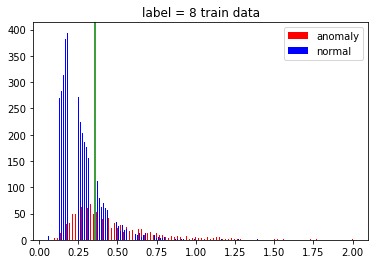

 train label = 8 uncertain_img


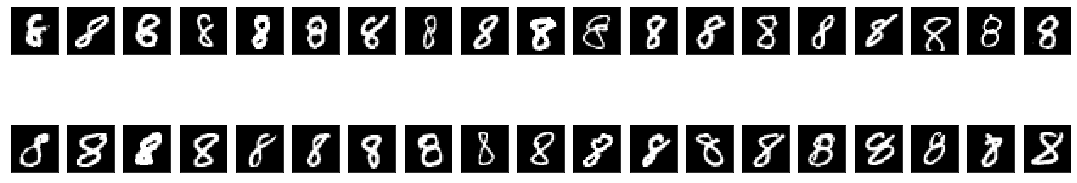

train label = 8 distance oder


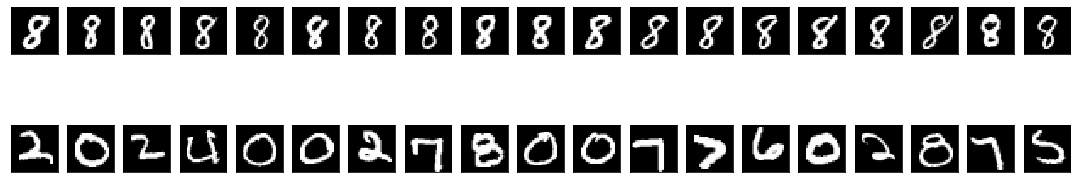

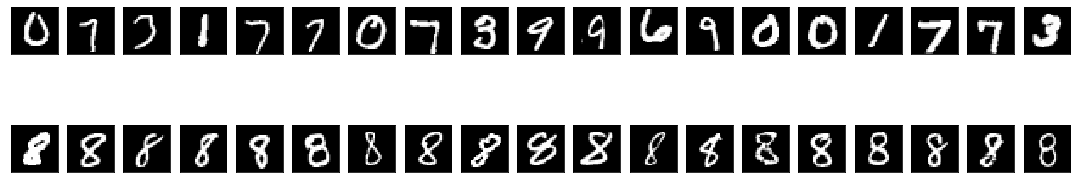

AUC: 0.7931592556479548
confusion_matrix:
[[5058 3968]
 [ 151  823]]


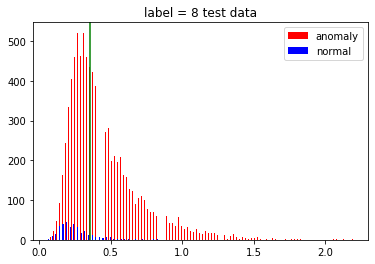

test label = 8 uncertain_img


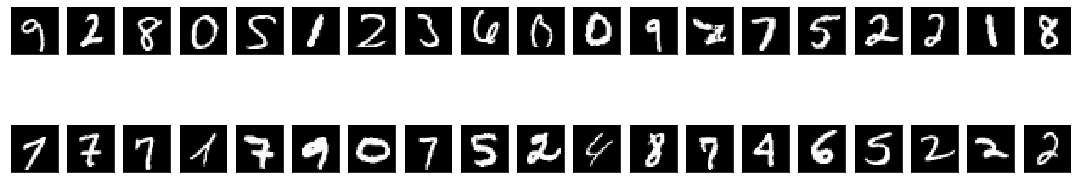

test label = 8 distance oder


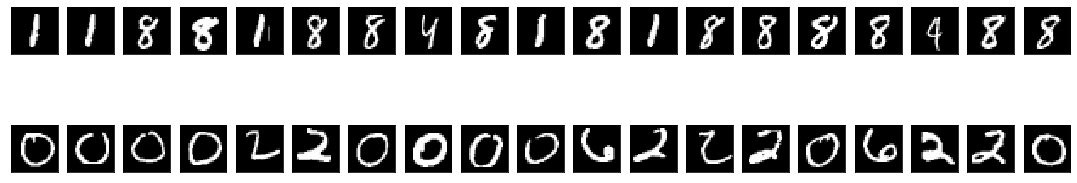

test label = 8 false_img


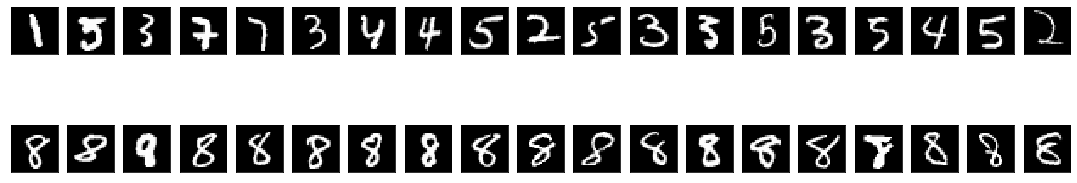

Loading  9
AUC: 0.876553593122138
confusion_matrix:
[[ 805  384]
 [ 763 5186]]


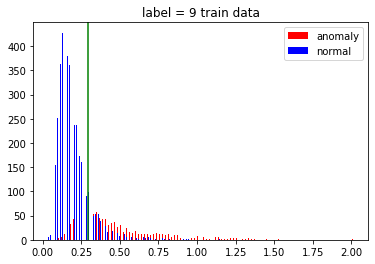

 train label = 9 uncertain_img


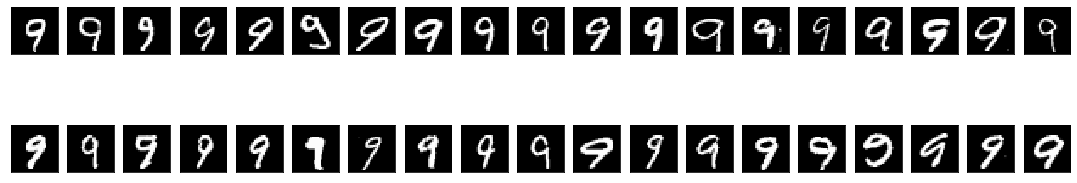

train label = 9 distance oder


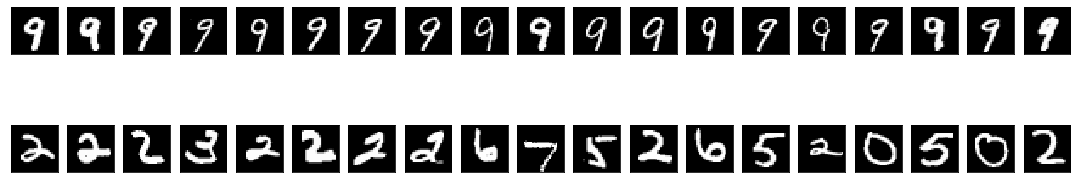

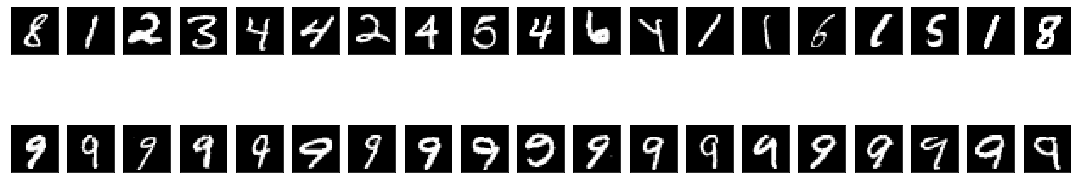

AUC: 0.8800101720484937
confusion_matrix:
[[6090 2901]
 [ 131  878]]


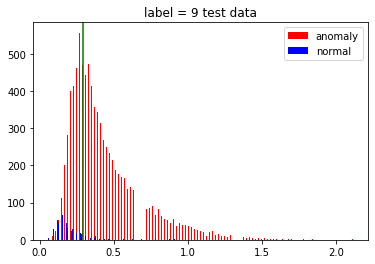

test label = 9 uncertain_img


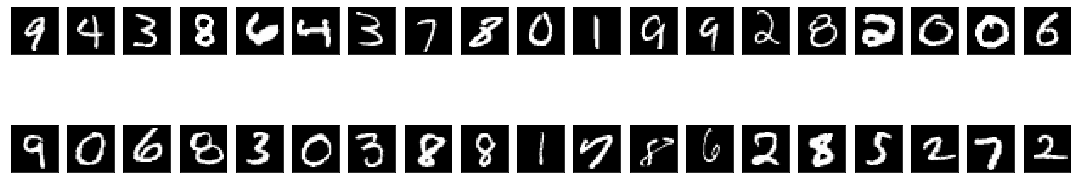

test label = 9 distance oder


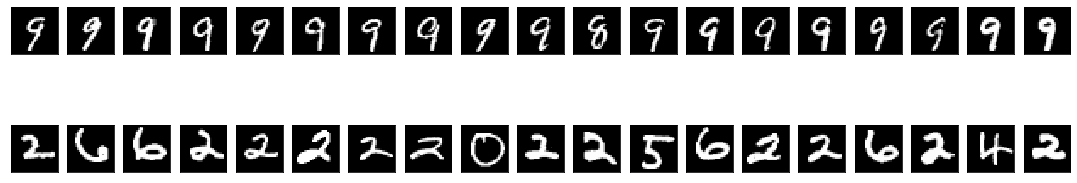

test label = 9 false_img


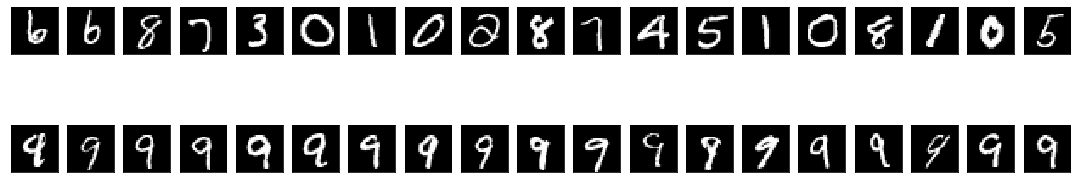

In [25]:
outlier_nu = 0.2
nu = 0.2
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali, n_samples, validation_n = split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    encoder = ae.encoder
    make_SVDD = make_SVDD_model(x_train, encoder)
    SVDD_model = make_SVDD.make_model() 
    train_SVDD = SA_DeepSVDD_Trainer(label_num, nu, SVDD_model, n_samples, validation_n, lr_milestone, lr_change)
    train_auc, train_confusionmatrix = train_SVDD.train_result(x_train, y_train, load_model = True, show_img = True)
    test_auc, confusionmatrix = train_SVDD.test_result(x_test, y_test, load_model = True, show_img = True)